In [2]:
from salad.serialize import read
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table
import matplotlib


matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.facecolor'] = 'white'

def make_results(f, recovery, vmin, vmax, phimin, phimax):
    results = []

    for g in f.group_by("ORBITID").groups:
        idx = np.argsort(g['EXPNUM'])
        binary = len(g) != len(set(g['EXPNUM']))

        g = g[idx]
        orbit = g[0]['ORBITID']
        mag = g['MAG'].mean()
        c = SkyCoord(g['RA'] * u.deg, g['DEC'] * u.deg)
        c_0 = c[0]
        c_1 = c[-1]
        dt = (g[-1]['mjd_mid'] - g[0]['mjd_mid'])*u.day
        v = (c_1.separation(c_0) / dt).to(u.deg/u.day)
        phi = np.arctan2(c_1.dec - c_0.dec, c_1.ra - c_0.ra).to(u.deg)
        findable = False
        if v > vmin and v < vmax:
            if phi > phimin and phi < phimax:
                findable = True

        found = (
            (len(recovery[orbit]['line']) > 0) 
            and 
            any([l['fake']/l['total'] > 0.5 for k, l in recovery[orbit]['line'].items()])
        )
        results.append(
            {
                "orbit": orbit,
                "v": v,
                "phi": phi,
                "findable": findable,
                "mag": mag,
                "found": found,
                "detected": recovery[orbit]['catalog']['fake'],
                "binary": binary,
            }
        )

    results = astropy.table.Table(results)
    return results

def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d

In [3]:
def found_in(match_results):
    found_results = []
    for k in match_results:
        r = match_results[k]
        candidates = []
        for l in r:
            d = r[l]
            ratio = d['fake'] / d['total']
            candidates.append((l, ratio))
        
        # pick highest ratio match
        candidates = sorted(candidates, key=lambda x : x[1], reverse=True) 
        if len(candidates) > 0:
            found_in = candidates[0][0]
            ratio = candidates[0][1]
        else:
            found_in = -1
            ratio = -1.
        found_results.append({"ORBITID": k, "found_in": found_in, "ratio": ratio})
    return astropy.table.Table(found_results)

In [4]:
# prefixes = Path("/epyc/projects/salad/search/tno_search").rglob("snr_[1-5].0/regular/tno_all")
# p = next(iter(prefixes))
# p
# found_in(read(p / "gathered_match_line.pkl"))

In [5]:
from salad.fakes.recover import fakes_info

In [6]:
# def fakes_info_table(fakes):
#     t = []
#     info = fakes_info(fakes)

#     for f in info:
#         d = {"ORBITID": f}
#         d.update({k: v for k, v in info[f].items()})
#         t.append(d)
#     return astropy.table.Table(t)

In [7]:
prefixes = Path("/epyc/projects/salad/search/tno_search/DEEP").rglob("detector_*")
fakes_lookup = {}
fakes_info_lookup = {}
for prefix in prefixes:
    detector = int(prefix.name.split("_")[1])
    fakes_p = prefix / "fakes.pkl"    
    try:
        fakes_lookup[detector] = read(fakes_p)
        fakes_info_lookup[detector] = fakes_info(fakes_lookup[detector])
    except Exception as e:
        print(e)
        print(fakes_p)


Ran out of input
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_2/fakes.pkl
Ran out of input
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_61/fakes.pkl


In [592]:
prefixes = Path("/epyc/projects/salad/search/tno_search/DEEP").rglob("detector_*")
for prefix in prefixes:
    detector = int(prefix.name.split("_")[1])
    catalog = prefix / "snr_5.0" / "regular" / "catalog.pkl"
    if catalog.exists():
        print(catalog)

/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_1/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_3/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_4/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_5/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_6/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_7/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_9/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_10/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_11/snr_5.0/regular/catalog.pkl
/epyc/projects/salad/search/tno_search

In [8]:
from astropy.coordinates import BarycentricMeanEcliptic, SkyCoord, ICRS

In [661]:
b.lon.min(), b.lon.max()

(<Angle 217.30222315 deg>, <Angle 217.61406443 deg>)

In [662]:
b.lat.min(), b.lat.max()

(<Angle 2.99562893 deg>, <Angle 3.21328835 deg>)

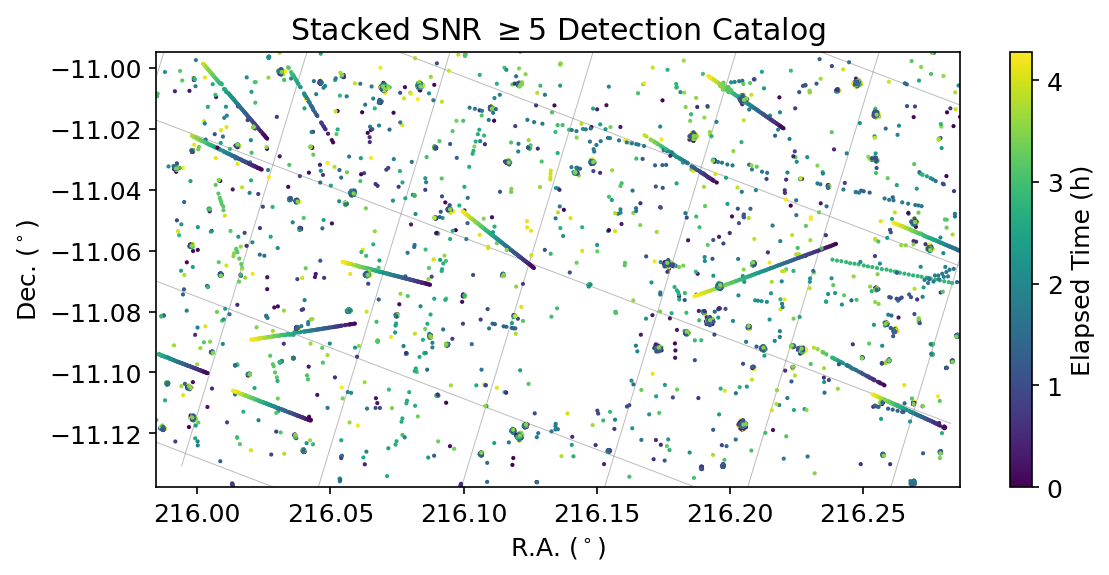

In [659]:
c = read("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_1/snr_5.0/regular/catalog.pkl")

fig = plt.figure(dpi=150, figsize=[8, 4])
plt.scatter(c.ra.to(u.deg), c.dec.to(u.deg), c=(c.time - c.time.min()).to(u.hour).value, s=1, rasterized=True)

b = SkyCoord(c.ra, c.dec).transform_to(BarycentricMeanEcliptic())
for _e in [3.0, 3.05, 3.1, 3.15, 3.2]:
    e = BarycentricMeanEcliptic(
        np.linspace(b.lon.min(), b.lon.max(), 100),
        np.ones(100) * _e * u.deg
    ).transform_to(ICRS())
    plt.plot(e.ra, e.dec, lw=0.5, color='gray', zorder=-1, alpha=0.5)

for _e in [217.3, 217.35, 217.4, 217.45, 217.5, 217.55, 217.6]:
    e = BarycentricMeanEcliptic(
        np.ones(100) * _e * u.deg,
        np.linspace(b.lat.min(), b.lat.max(), 100),
    ).transform_to(ICRS())
    plt.plot(e.ra, e.dec, lw=0.5, color='gray', zorder=-1, alpha=0.5)
    
cbar = plt.colorbar()
cbar.ax.set_ylabel("Elapsed Time (h)")
plt.xlabel("R.A. " + r"($^\circ$)")
plt.ylabel("Dec. " + r"($^\circ$)")
plt.title("Stacked SNR " + r"$\geq 5$ " + "Detection Catalog")
plt.xlim(c.ra.to(u.deg).min().value, c.ra.to(u.deg).max().value)
plt.ylim(c.dec.to(u.deg).min().value, c.dec.to(u.deg).max().value)
plt.tight_layout()
plt.savefig("figures/stacked_catalog.pdf")
plt.savefig("figures/stacked_catalog.png")
plt.show()

In [559]:
fakes_info_lookup[1]

<Table length=16>
ORBITID           vra                    vdec         ...   type   binary
                deg / d                deg / d        ...                
 int64          float64                float64        ...   str8    bool 
-------- ---------------------- --------------------- ... -------- ------
 2405372   -0.01950935166310317  0.004005313270790564 ...      tno  False
 2732908  -0.011655296420758805  0.003895221351861602 ...      tno  False
 3881210   -0.00918594583080613 0.0031365914998971365 ...      tno  False
 3898678  -0.014284347013795775  0.004537530591439663 ...      tno  False
 4279478  -0.011176547258878494  0.005099762757632685 ...      tno  False
 5182786  -0.007471236421779182 0.0035404044855064935 ...      tno  False
 5485151 -0.0006049468632375215 0.0002192280459709196 ...      tno  False
 5962014  -0.013244086661610222  0.004038602096829615 ...      tno  False
 6009903  -0.014682602837850316   0.00314806651609674 ...      tno  False
10041343   -0.29713809493156784  -0.09604963855455591 ... asteroid  False
10053463   -0.15100897047828574 0.0029864641685746636 ... asteroid  False
10564514   -0.11873688880838078   0.12091516029456924 ... asteroid  False
13039521   -0.14286354030928058 0.0033363187450130703 ... asteroid  False
13776855    -0.1256695303635021   0.18511983953004849 ... asteroid  False
14621325   -0.14885474993460884    0.1526942159246714 ... asteroid  False
14813564   -0.16369936876236016 -0.017466331230992248 ... asteroid  False

In [588]:
n = []
for p1 in Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c").rglob("detector*"):
    detector = int(p1.name.split("_")[1])
    for p2 in p1.rglob("snr_5.0/regular/catalog_no_masks_matches.pkl"):
        f = fakes_info_lookup[detector]
        d = read(p2)
        for o in d:
            n.append(
                {
                    "mag": f[f['ORBITID'] == o]['mag'][0],
                    "detected": d[o]['fake'],
                    "total": d[o]['total']
                }
            )
            
n = astropy.table.Table(n)
#         print(p.parent.parent.parent.name)
#         print(p)
#     d = read(p)
#     for o in d:
#         print(o, d[o]['fake'] / d[o]['total'])

In [ ]:
fit_completeness(n['mag'])

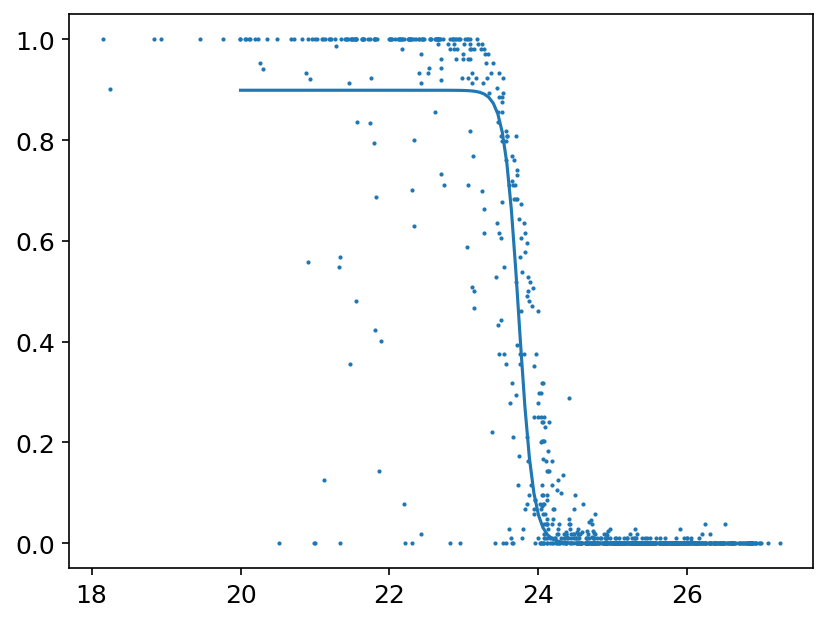

{'c': 0.8987629257841763, 'k': 10.283660610630207, 'm_50': 23.736324962999003, 'sigma_c': 0.022677227390283477, 'sigma_k': 2.0270034209386387, 'sigma_m_50': 0.033778199426526656}


In [590]:
n['t'] = n['detected']/n['total'] > 0.5
res = do_fit(n, found_col='t')
plt.scatter(n['mag'], n['detected']/n['total'], s=1)
_x = np.linspace(20, 26, 100)
_y = p(_x, res['c'], res['k'], res['m_50'])
plt.plot(_x, _y)
plt.show()
print(res)

In [8]:
fakes_info_table = []
for d in fakes_info_lookup:
    g = fakes_info_lookup[d]
    g['detector'] = d
    fakes_info_table.append(g)
fakes_info_table = astropy.table.vstack(fakes_info_table)

In [70]:
def number_of_votes(label):
    prefixes = Path("/epyc/projects/salad/search/tno_search").rglob("snr_[0-5].0/regular/" + label)
    votes = []
    for p in prefixes:
        snr = float(p.parent.parent.name.split("_")[1])
        detector = int(p.parent.parent.parent.name.split("_")[1])
        c_p = p / "clusters.pkl"
        try:
            c = read(c_p)
            for k in c:
                votes.append(
                    {
                        "cluster": k,
                        "votes": c[k].extra['votes'],
                        "detector": detector,
                        "snr": snr,
                    }
                )
        except Exception as e:
            print(e)
            print(c_p)
            
    return astropy.table.Table(votes)

votes_tno = number_of_votes("tno_all")
votes_ast = number_of_votes("ast_all")

def found_results(label):
    prefixes = Path("/epyc/projects/salad/search/tno_search").rglob("snr_[0-5].0/regular/" + label)
    results = []
    for p in prefixes:
        snr = float(p.parent.parent.name.split("_")[1])
        detector = int(p.parent.parent.parent.name.split("_")[1])
        r_p = p / "gathered_match_line.pkl"
        try:
#             c_p = read(p / "clusters.pkl")
            r = found_in(read(r_p))
            r['found'] = (r['found_in'] >= 0)
            r['detector'] = detector
            r['snr'] = snr
            results.append(r)
        except:
            print(r_p)

#             r = astropy.table.join(fakes_info(fakes), found(read()), keys=['ORBITID'])
#             r['detector'] = detector
#             r['snr'] = snr
#             results.append(r)
#         break
    return astropy.table.vstack(results)

found_tno = found_results("tno_all")
found_ast = found_results("ast_all")

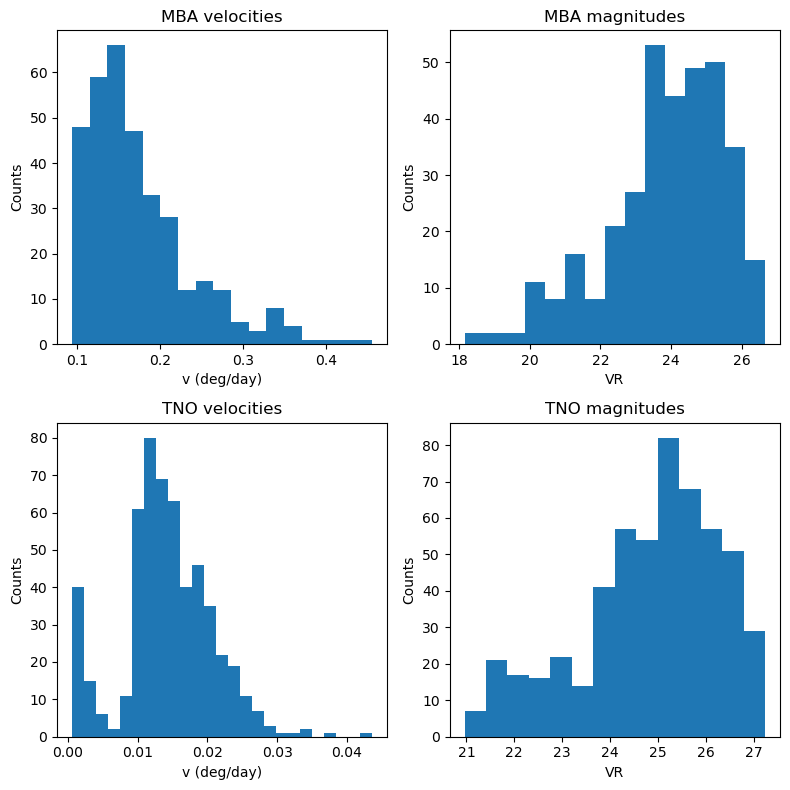

In [9]:
fig = plt.figure(figsize=[8, 8])
axs = fig.subplots(2, 2)

for i, g1 in enumerate(fakes_info_table.group_by("type").groups):
    vra = []
    vdec = []
    v = []
    mag = []
    for g2 in g1.group_by("ORBITID").groups:
        g2.sort("N", reverse=True)
        vra.append(g2[0]['vra'])
        vdec.append(g2[0]['vdec'])
        mag.append(g2[0]['mag'])
        v.append(g2[0]['v'])
        
    v = np.array(v)
    mag = np.array(mag)
    if g1[0]['type'] == "tno":
        m = (v < 0.05)
        v = v[m]
        mag = mag[m]
    
    plt.sca(axs[i, 0])
    plt.hist(v, bins='auto')
    plt.xlabel("v (deg/day)")
    plt.ylabel("Counts")
    plt.title({"tno": "TNO", "asteroid": "MBA"}.get(g1[0]['type']) + " velocities")
    plt.sca(axs[i, 1])
    plt.hist(mag, bins='auto')
    plt.xlabel("VR")
    plt.ylabel("Counts")
    plt.title({"tno": "TNO", "asteroid": "MBA"}.get(g1[0]['type']) + " magnitudes")
plt.tight_layout()
plt.savefig("figures/fakes_distribution.png")
plt.savefig("figures/fakes_distribution.pdf")
plt.show()

In [71]:

# join with info
# found = found_ast
# votes = votes_ast


def make_joined(found, votes, object_type, ratio_threshold=0.5):
    joined = astropy.table.join(
        found, fakes_info_table, 
        keys=['ORBITID', "detector"],
    )

    m = (
        (joined['type'] == object_type) &
        (~joined['binary'])
    )
    joined = joined[m]


    not_found = joined[joined['found_in'] < 0]
    # join with votes
    joined = astropy.table.join(
        joined, votes, 
        keys_left=['found_in', 'detector', 'snr'], keys_right=['cluster', 'detector', 'snr'],
    )
    if len(not_found) > 0:
        not_found['cluster'] = -1
        not_found['votes'] = -1


    joined.rename_columns(['detector_1', 'snr_1'], ['detector', 'snr'])
    joined.remove_columns(['detector_2', 'snr_2'])
    joined = astropy.table.vstack([joined, not_found])

    # group by snr
    # group by ORBITID

    t = []
    for g1 in joined.group_by("snr").groups:
        snr = g1[0]['snr']
        for g2 in g1.group_by("ORBITID").groups:
            orbit = g2[0]['ORBITID']
            g2.sort("ratio", reverse=True)
            r = g2[0]
            r['found'] = r['ratio'] > ratio_threshold
            t.append(r)
    t = astropy.table.vstack(t)


    return t

joined_ast = make_joined(found_ast, votes_ast, "asteroid")
joined_tno = make_joined(found_tno, votes_tno, "tno")

joined_tno['findable'] = (joined_tno['v'] > 0.003*u.deg/u.day) & (joined_tno['v'] < 0.04*u.deg/u.day)
joined_ast['findable'] = (joined_ast['v'] > 0.1*u.deg/u.day) & (joined_ast['v'] < 0.5*u.deg/u.day)

In [72]:
joined_tno

<Table length=1429>
ORBITID found_in        ratio         found ... binary cluster votes findable
                                            ...                              
 int64   int64         float64         bool ...  bool   int64  int32   bool  
------- -------- -------------------- ----- ... ------ ------- ----- --------
  14369        1                  1.0  True ...  False       1    58     True
  19008        0                  1.0  True ...  False       0    92     True
  45334       31                  1.0  True ...  False      31    23     True
  46206        2                  1.0  True ...  False       2    50     True
  62637        1                  1.0  True ...  False       1    53     True
  67139       19                  1.0  True ...  False      19    26     True
  72536       11                  1.0  True ...  False      11    25     True
 125150        0                  1.0  True ...  False       0    98     True
 149889        0                  1.0  True ...  False       0    45     True
    ...      ...                  ...   ... ...    ...     ...   ...      ...
5919819       22                  1.0  True ...  False      22   104     True
5929367       63                  1.0  True ...  False      63    33     True
5948196       12                  1.0  True ...  False      12   104     True
5956563      258                  1.0  True ...  False     258     7     True
5978984       21                  1.0  True ...  False      21   104     True
5990773       15                  1.0  True ...  False      15   104     True
6052289      219                  1.0  True ...  False     219     9     True
6357558       58                  1.0  True ...  False      58    44    False
6357935      383  0.11538461538461539 False ...  False     383     3    False
6359676      131 0.019230769230769232 False ...  False     131    10    False

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, 

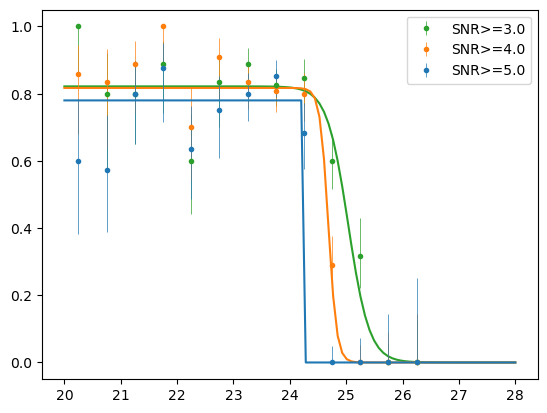

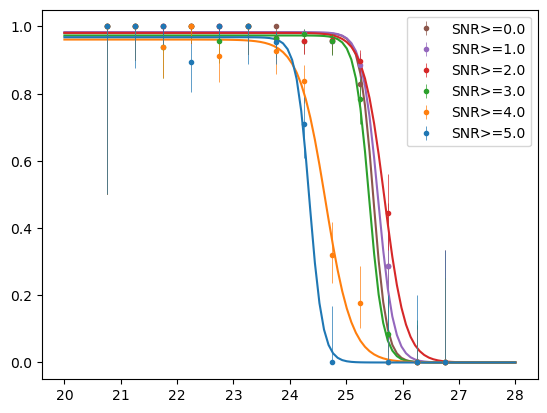

In [73]:
def plot_completeness(t):
    _x = np.linspace(20, 28, 100)
    snr = t[0]['snr']
    
    fit_result = do_fit(t, found_col='found')
    x, y, yerr = bin_detection(t, _x.min(), _x.max(), dm=0.5, found_col='found')
    _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    plt.plot(_x, _y, color=f'C{5 - int(snr)}')
    plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C{5 - int(snr)}", label=f"SNR>={snr}")

fig = plt.figure()
for g in joined_ast.group_by("snr").groups:
    plot_completeness(g)
plt.legend()
plt.show()

fig = plt.figure()
for g in joined_tno.group_by("snr").groups:
    plot_completeness(g)
plt.legend()
plt.show()

In [23]:
do_fit(t.group_by("snr").groups[2])

NameError: name 't' is not defined

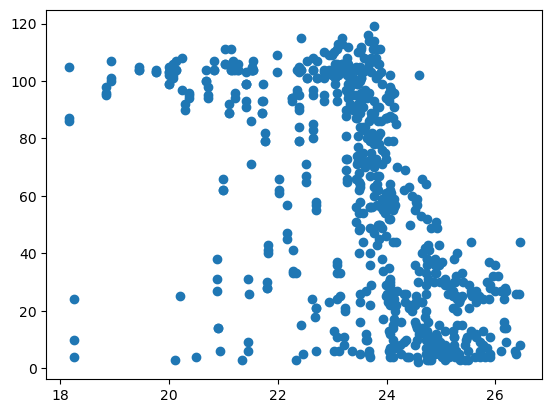

In [24]:
plt.scatter(joined_ast['mag'], joined_ast['votes'])
plt.show()

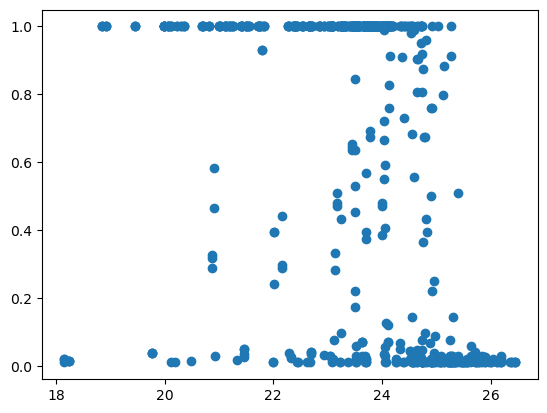

In [25]:
plt.scatter(joined_ast['mag'], joined_ast['ratio'])
plt.show()

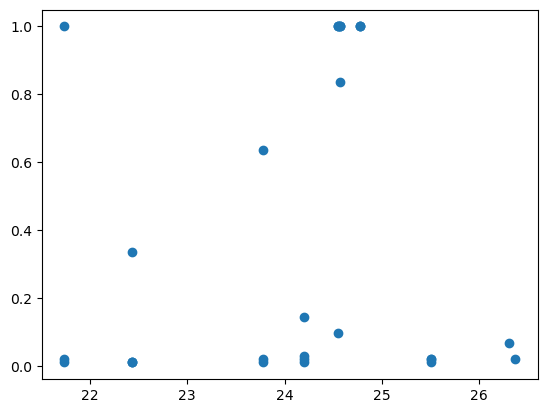

In [413]:
t = astropy.table.join(found_tno, fakes_info_lookup[1], keys=["ORBITID"])
plt.scatter(t['mag'], t['ratio'])
plt.show()

In [396]:
(found_ast['found_in'] < 0).sum()

0

In [397]:
(~found_tno['found']).sum()

0

In [403]:
found_tno

<Table length=2114>
ORBITID  found_in        ratio         found detector   snr  
 int64    int64         float64         bool  int64   float64
-------- -------- -------------------- ----- -------- -------
 2405372        8                  1.0  True        1     1.0
 4279478       22                  1.0  True        1     1.0
 5962014       11                  1.0  True        1     1.0
10041343       27 0.009615384615384616  True        1     1.0
10053463      713 0.009615384615384616  True        1     1.0
14813564      282 0.009615384615384616  True        1     1.0
 2405372       34                  1.0  True        1     2.0
 3881210      571   0.0673076923076923  True        1     2.0
 4279478       98                  1.0  True        1     2.0
 5962014       30                  1.0  True        1     2.0
     ...      ...                  ...   ...      ...     ...
10200778      729 0.019230769230769232  True       62     3.0
12084118      707  0.08653846153846154  True       62     3.0
14649253      431  0.06060606060606061  True       62     3.0
 1241197       57   0.8846153846153846  True       62     5.0
 4637208       20                  1.0  True       62     5.0
 5919819       22                  1.0  True       62     5.0
 5978984       21                  1.0  True       62     5.0
10200778      150                  1.0  True       62     5.0
12084118      116                  1.0  True       62     5.0
14649253      331  0.42424242424242425  True       62     5.0

In [402]:
plt.scatter(found_tno['mag'], found_tno['ratio'])
plt.show()

KeyError: 'mag'

In [92]:
catalog = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/snr_5.0/regular/catalog.pkl"))



In [234]:
((4096*0.263*u.arcsec)*(2048*0.263*u.arcsec)/(0.8)).to(u.arcmin**2)

<Quantity 201.46931484 arcmin2>

In [97]:
pc = images[0].reader.readPhotoCalib()

In [103]:
help(pc.instFluxToMagnitudeArray())

TypeError: PhotoCalib.instFluxToMagnitudeArray() missing 3 required positional arguments: 'instFluxes', 'x', and 'y'

In [105]:
sc = catalog.single_epoch_catalogs[0]
pc.instFluxToMagnitudeArray(sc.peakValue.value, sc.i_x, sc.i_y)

<Magnitude [28.23499353, 27.39686621, 27.7794435 , 28.66130725,
            28.58458939, 27.75168725, 24.33162334, 28.98708857,
            27.68179659, 26.8184352 , 25.88774392, 28.00699926,
            29.02326119, 26.3154194 , 28.87672349, 27.33692917,
            27.74287863, 28.10652418, 28.52354505, 27.38899195,
            28.92649839, 27.3487423 , 27.43107391, 26.14587509,
            28.44400455, 27.42742153, 26.29076731, 26.45671989,
            28.61967874, 29.08372222, 28.61093562, 26.02129161,
            27.82861289, 26.56227906, 28.29977995, 26.69906751,
            27.6586039 , 28.68796041, 26.54122244, 27.00709323,
            28.2527488 , 28.25402843, 27.64391831, 28.47652734,
            27.04681468, 28.05812347, 26.96281251, 28.13005349,
            27.28690943, 28.8580098 , 28.27495895, 28.59056699,
            26.50586172, 26.87318726, 28.10493927, 27.76441256,
            26.12971722, 28.50658587, 28.28718323, 28.43142325,
            28.23740266, 28.47728641, 27

In [111]:
catalog.single_epoch_catalogs[0].catalog

<Row index=0>
  id    f_x     f_y    i_x   i_y  peakValue    significance           ra                dec        
        pix     pix    pix   pix      ct                             rad                rad        
int64 float32 float32 int32 int32  float32       float64           float64            float64      
----- ------- ------- ----- ----- --------- ----------------- ------------------ ------------------
    1   169.0   154.0   169   154 15.473946 6.589827537536621 3.7642675461732833 -0.197769699122686

In [107]:
from salad.measure.forced import forced_exposures

In [108]:
exp = images[0].exposure

In [113]:
catalog.single_epoch_catalogs[0].catalog[0]

<Row index=0>
  id    f_x     f_y    i_x   i_y  peakValue    significance           ra                dec        
        pix     pix    pix   pix      ct                             rad                rad        
int64 float32 float32 int32 int32  float32       float64           float64            float64      
----- ------- ------- ----- ----- --------- ----------------- ------------------ ------------------
    1   169.0   154.0   169   154 15.473946 6.589827537536621 3.7642675461732833 -0.197769699122686

In [119]:
images = read(Path("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_8/images.pkl"))

forced_cats = []
for i, (image, sc) in enumerate(zip(images, catalog.single_epoch_catalogs)):
    print(i)
    exp = image.exposure
    forced_cats.append(forced_exposures([exp for row in sc.catalog], sc.catalog))
    
forced_cat = astropy.table.vstack(forced_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [666]:


mag_ref = 23.7
expected = mag_ref + 5/2*np.log10(np.sqrt(len(images)))
# plt.hist(forced_cat[forced_cat['forced_mag']> 23]['forced_mag'], bins='auto')
# plt.axvline(mag_ref, color='k', ls="-", label="Single Epoch $m_{50}$")
# plt.xlabel("VR")
# plt.ylabel("Number of sources")
# plt.legend()
# # plt.savefig("figures/forced_cat.png")
# # plt.savefig("figures/forced_cat.pdf")
# plt.show()

In [523]:
expected

26.321291674123476

In [94]:
catalog.peakValue

<Column name='peakValue' dtype='float32' unit='ct' description='value of [smoothed] image at peak position' length=10518>
15.473946
 33.48513
23.540792
 10.44902
11.214056
24.150358
563.57166
7.7403936
25.756084
57.045895
134.43146
19.089685
      ...
15.038752
 14.97374
  9.57219
166.26584
 15.70337
40.216236
 18.19254
 92.42618
11.938061
 458.1247
49.956345
22.598974

In [14]:
found[found['snr'] == 1.0]

<Table length=383>
ORBITID  found_in  ratio  found detector   snr  
 int64    int64   float64  bool  int64   float64
-------- -------- ------- ----- -------- -------
 2405372        8     1.0  True        1     1.0
 4279478       22     1.0  True        1     1.0
 5962014       11     1.0  True        1     1.0
10041343       -1    -1.0 False        1     1.0
10053463       -1    -1.0 False        1     1.0
14813564       -1    -1.0 False        1     1.0
  683271       -1    -1.0 False        3     1.0
 1432951        1     1.0  True        3     1.0
 3078902       10     1.0  True        3     1.0
 3288254        0     1.0 False        3     1.0
     ...      ...     ...   ...      ...     ...
 4065088       -1    -1.0 False       60     1.0
 4725347        4     1.0  True       60     1.0
 6052289        5     1.0  True       60     1.0
10078694       -1    -1.0 False       60     1.0
 1241197        3     1.0  True       62     1.0
 4303622      190     1.0  True       62     1.0
 4637208        1     1.0  True       62     1.0
 5056327       -1    -1.0 False       62     1.0
 5919819        2     1.0  True       62     1.0
 5978984        0     1.0 False       62     1.0

In [29]:
votes

<Table length=296296>
cluster votes detector   snr  
 int64  int32  int64   float64
------- ----- -------- -------
      0    40        1     1.0
      1    38        1     1.0
      2    35        1     1.0
      3    32        1     1.0
      4    29        1     1.0
      5    29        1     1.0
      6    28        1     1.0
      7    28        1     1.0
      8    28        1     1.0
      9    26        1     1.0
    ...   ...      ...     ...
    991     0       62     5.0
    992     0       62     5.0
    993     0       62     5.0
    994     0       62     5.0
    995     0       62     5.0
    996     0       62     5.0
    997     0       62     5.0
    998     0       62     5.0
    999     0       62     5.0
   1000     0       62     5.0

In [49]:
joined

<Table length=1278>
ORBITID  found_in       ratio        found ... binary cluster votes findable
                                           ...                              
 int64    int64        float64        bool ...  bool   int64  int32   bool  
-------- -------- ------------------ ----- ... ------ ------- ----- --------
 2405372        8                1.0  True ...  False       8    28     True
 5962014       11                1.0  True ...  False      11    26     True
 4279478       22                1.0  True ...  False      22    23     True
 5962014       30                1.0  True ...  False      30    38     True
 2405372       34                1.0  True ...  False      34    37     True
 4279478       98                1.0  True ...  False      98    26     True
 2405372      142                1.0  True ...  False     142    20     True
 5962014      150                1.0  True ...  False     150    19     True
 4279478      334                1.0  True ...  False     334    10     True
     ...      ...                ...   ... ...    ...     ...   ...      ...
 5919819       30                1.0  True ...  False      30   104     True
12084118      120                1.0  True ...  False     120    19    False
 1241197      169 0.5961538461538461  True ...   True     169    12     True
10200778      221 0.9807692307692307  True ...  False     221    10    False
 4637208       20                1.0  True ...  False      20   104     True
 5978984       21                1.0  True ...  False      21   104     True
 5919819       22                1.0  True ...  False      22   104     True
 1241197       57 0.8846153846153846  True ...   True      57    48     True
12084118      116                1.0  True ...  False     116    13    False
10200778      150                1.0  True ...  False     150    10    False

In [40]:
# def make_joined(found, votes):
#     joined = []
#     for g in found.group_by("detector").groups:
#         try:
#             info = fakes_info_lookup[g[0]['detector']]
#             joined.append(astropy.table.join(g, info, keys=['ORBITID']))
#         except Exception as e:
#             print(e)
#             print(g)

#     joined = astropy.table.vstack(joined)
#     j_votes = []
#     for r in joined:
#         m = votes[(votes['detector'] == r['detector']) & (votes['snr'] == r['snr'])]
#         if r['found_in'] in m['cluster']:
#             j_votes.append(m[m['cluster'] == r['found_in']][0]['votes'])
#         else:
#             j_votes.append(-1)
#     joined['votes'] = j_votes
#     return joined

# joined_tno = make_joined(found_tno, votes_tno)
# joined_tno = joined_tno[joined_tno['type'] == "tno"]
# joined_ast = make_joined(found_ast, votes_ast)
# joined_ast = joined_ast[joined_ast['type'] == "asteroid"]

In [380]:
votes_ast[0:2]

<Table length=2>
cluster votes detector   snr  
 int64  int32  int64   float64
------- ----- -------- -------
      0   107        1     4.0
      1   106        1     4.0

In [388]:
found_tno[found_tno['found_in'] < 0]

<Table length=0>
ORBITID found_in  ratio  found detector   snr  
 int64   int64   float64  bool  int64   float64
------- -------- ------- ----- -------- -------

In [387]:
joined_ast = astropy.table.join(
    found_ast, 
    votes_ast, 
    keys_left=['found_in', 'detector', 'snr'], 
    keys_right=['cluster', 'detector', 'snr']
)


<Table length=1419>
ORBITID  found_in        ratio         found ... votes detector_2  snr_2 
 int64    int64         float64         bool ... int32   int64    float64
-------- -------- -------------------- ----- ... ----- ---------- -------
11806786        0                  1.0 False ...   104          6     4.0
11806786        0                  1.0 False ...   104          6     5.0
11710336        0                  1.0 False ...   104          7     4.0
11710336        0                  1.0 False ...   104          7     5.0
10995599        0                  1.0 False ...   116         18     3.0
13700317        0                  1.0 False ...   106         19     4.0
13700317        0                  1.0 False ...   106         19     5.0
13309462        0                  1.0 False ...   104         21     5.0
12759912        0                  1.0 False ...   104         22     5.0
11886435        0                  1.0 False ...   110         26     3.0
     ...      ...                  ...   ... ...   ...        ...     ...
 5919641      987 0.019230769230769232  True ...    23         41     3.0
 4666899      991 0.009615384615384616  True ...    22         16     3.0
 2993878      991 0.019230769230769232  True ...     5         34     4.0
   67139      991 0.009615384615384616  True ...    23         60     3.0
10464147      993 0.015384615384615385  True ...     4          3     4.0
 5102431      993 0.019230769230769232  True ...     5         13     4.0
 4418501      994 0.019230769230769232  True ...     5         38     4.0
11161068      995 0.009615384615384616  True ...     4         57     4.0
  719390      997 0.019230769230769232  True ...    23         49     3.0
 2729788      999 0.009615384615384616  True ...     6         22     4.0

In [41]:
joined_ast[joined_ast['snr'] == 3.0]

<Table length=236>
ORBITID  found_in        ratio         found ...   type   binary cluster votes
                                             ...                              
 int64    int64         float64         bool ...   str8    bool   int64  int32
-------- -------- -------------------- ----- ... -------- ------ ------- -----
10049768      161   0.9191919191919192  True ... asteroid  False     161    36
10053463      971 0.009615384615384616 False ... asteroid  False     971    21
10065221        1                  1.0  True ... asteroid  False       1   113
10078694      280 0.009615384615384616 False ... asteroid  False     280    32
10113319        2                  1.0  True ... asteroid  False       2   108
10183346        9                  1.0  True ... asteroid  False       9   103
10198848       16                  1.0  True ... asteroid  False      16    75
10199666        0                  1.0  True ... asteroid  False       0   112
10200295      104 0.009615384615384616 False ... asteroid  False     104    44
     ...      ...                  ...   ... ...      ...    ...     ...   ...
14802134       16                  1.0  True ... asteroid  False      16    79
14813564       15                  1.0  True ... asteroid  False      15    70
14826073        8                  1.0  True ... asteroid  False       8    79
14828230      473 0.057692307692307696 False ... asteroid  False     473    27
14870012      337   0.8846153846153846  True ... asteroid  False     337    29
14929644       11                  1.0  True ... asteroid  False      11    98
14956448      135 0.028846153846153848 False ... asteroid  False     135    38
14964736      547 0.009615384615384616 False ... asteroid  False     547    28
14967241      117                  1.0  True ... asteroid  False     117    37
14969959        9                  1.0  True ... asteroid  False       9   104

In [33]:
joined_tno[joined_tno]

<Table length=1215>
ORBITID found_in       ratio        found ... type binary votes
                                          ...                  
 int64   int64        float64        bool ... str8  bool  int32
------- -------- ------------------ ----- ... ---- ------ -----
2405372        8                1.0  True ...  tno  False    28
2405372      353 0.8365384615384616  True ...  tno  False     6
2405372       34                1.0  True ...  tno  False    37
2405372      142                1.0  True ...  tno  False    20
3881210      571 0.0673076923076923  True ...  tno  False    14
4279478      334                1.0  True ...  tno  False    10
4279478       22                1.0  True ...  tno  False    23
4279478       98                1.0  True ...  tno  False    26
5962014      150                1.0  True ...  tno  False    19
    ...      ...                ...   ... ...  ...    ...   ...
5919819       22                1.0  True ...  tno  False   104
5919819        3                1.0  True ...  tno  False   101
5919819        0                1.0  True ...  tno  False   104
5919819        2                1.0  True ...  tno  False    94
5919819       30                1.0  True ...  tno  False   104
5978984        0                1.0  True ...  tno  False    94
5978984       29                1.0  True ...  tno  False   104
5978984       21                1.0  True ...  tno  False   104
5978984        0                1.0  True ...  tno  False   104
5978984        3                1.0  True ...  tno  False   102

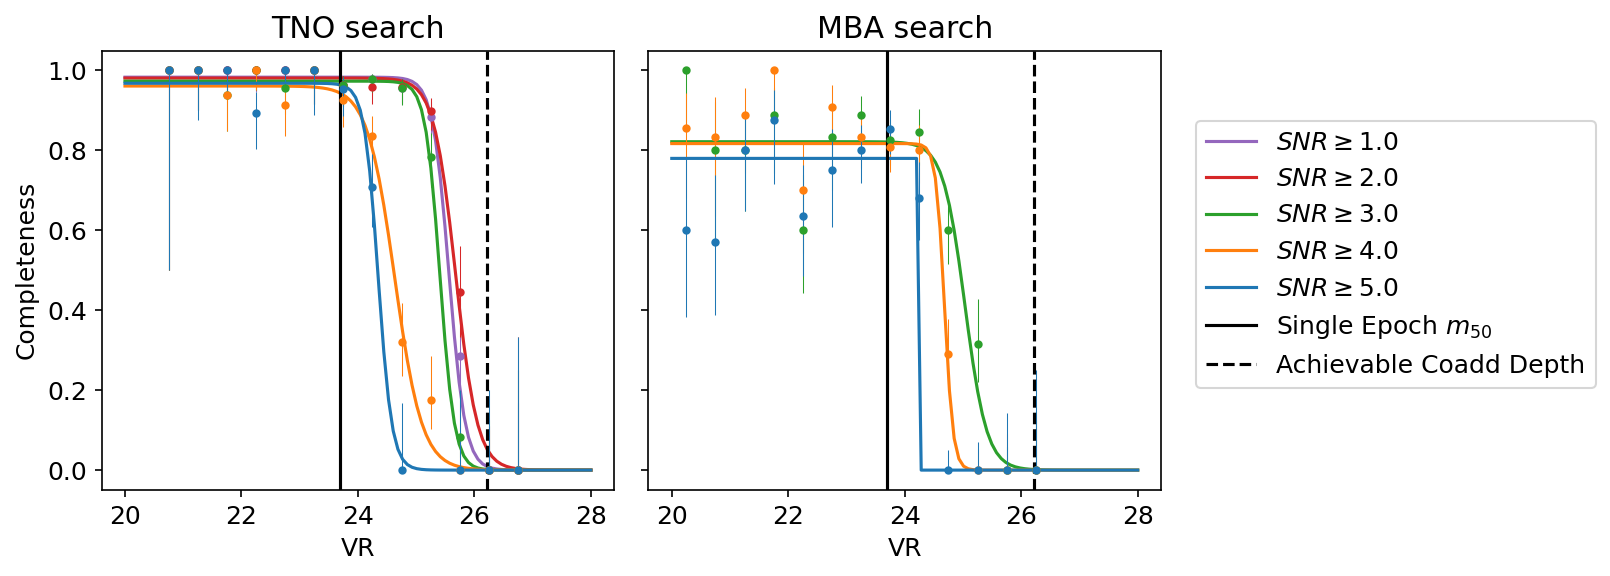

In [670]:
fig = plt.figure(figsize=[8, 4])
axs = np.atleast_1d(fig.subplots(1, 2, sharey=True)).flatten()

_x = np.linspace(20, 28, 100)
for k, j in enumerate([joined_tno, joined_ast]):
    plt.sca(axs[k])
    for i, g in enumerate(j.group_by("snr").groups):
        snr = g[0]['snr']
        if snr == 0.0:
            continue
#         g = g[~g['binary']]
#         g['found'] = g['ratio'] >= 0.5
        x, y, yerr = bin_detection(g, 20, 28)

        fit_result = do_fit(g, found_col='found')
        x, y, yerr = bin_detection(g, _x.min(), _x.max(), dm=0.5, found_col='found')
        _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    #     plt.title(f"snr>={g[0]['snr']}")
        if k == 0:
            plt.plot(_x, _y, color=f'C{5 - int(snr)}', label="$SNR\geq$"+f"{snr}")
        else:
            plt.plot(_x, _y, color=f'C{5 - int(snr)}')
        plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C{5 - int(snr)}")
        
    if k == 0:
        plt.axvline(mag_ref, color='k', ls="-", label="Single Epoch $m_{50}$")
        plt.axvline(expected, color='k', ls='--', label="Achievable Coadd Depth")
    else:
        plt.axvline(mag_ref, color='k', ls="-")
        plt.axvline(expected, color='k', ls='--')
    plt.xlabel("VR")
    if k == 0:
        plt.ylabel("Completeness")
    plt.title(("TNO" if k == 0 else "MBA") + " search")

plt.sca(axs[1])
lgd = plt.figlegend(bbox_to_anchor=[1.35, 0.8])
plt.tight_layout()
plt.savefig("figures/completness_tno_mba.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("figures/completness_tno_mba.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

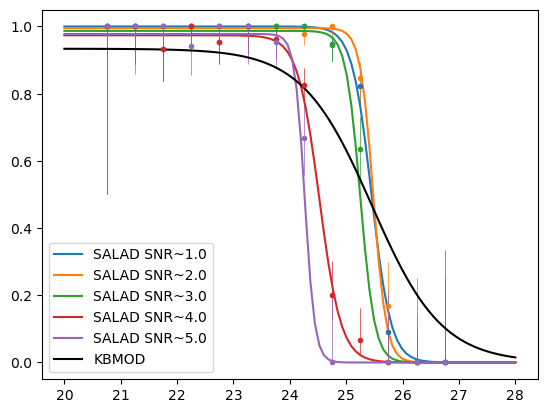

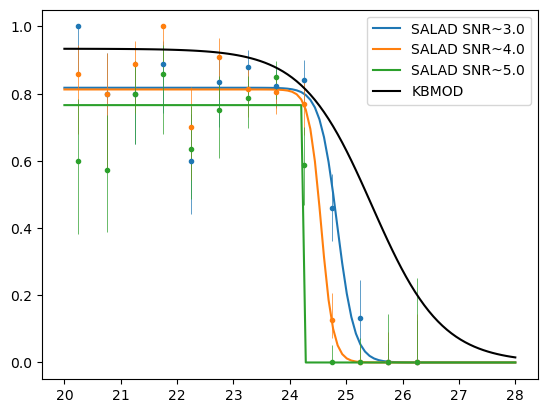

In [51]:
import json

with open("/epyc/projects/kbmod/runs/DEEP/xmatch_catalogs/fitres_per_night_per_stare.json") as f:
    kbmod_results = json.load(f)

kbmod_result = kbmod_results['20190403_A0c']

for joined in [joined_tno, joined_ast]:
    j = joined[
        (joined['found'] | joined['findable']) & 
        (~joined['binary']) & 
#         (joined['type'] == 'tno') & 
        ((joined['ratio'] >= 1.0) | (joined['ratio'] < 0.5))
    ]

    _x = np.linspace(20, 28, 100)
    for i, results in enumerate(j.group_by("snr").groups):
        snr = results[0]['snr']
    #     if snr != 3.0:
    #         continue

        _t = results
        fit_result = do_fit(_t, found_col='found')
        x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found')
        _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    #     plt.title(f"snr>={g[0]['snr']}")
        plt.plot(_x, _y, color=f'C{i}', label=f"SALAD SNR~{snr}")
        plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C{i}")

    _y_kbmod = p(_x, kbmod_result['fit']['c'], kbmod_result['fit']['k'], kbmod_result['fit']['m_50'])
    plt.plot(_x, _y_kbmod, color=f'k', label="KBMOD")

    plt.legend()
    plt.show()

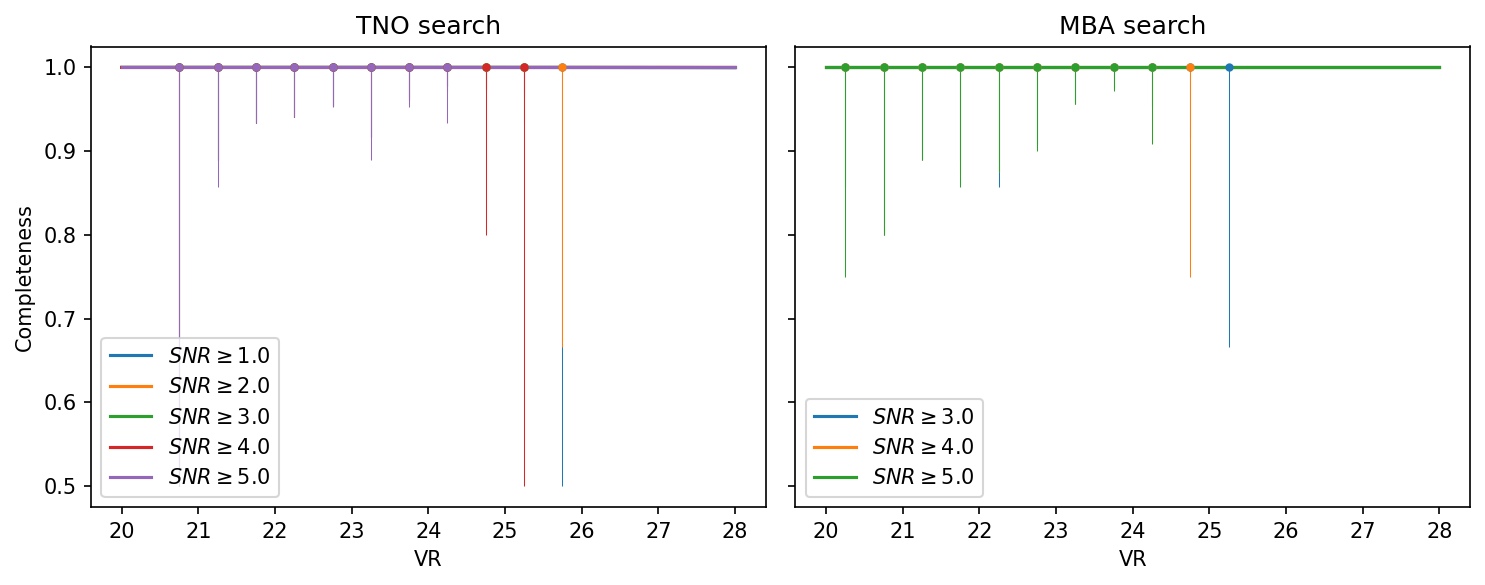

In [48]:
import json

with open("/epyc/projects/kbmod/runs/DEEP/xmatch_catalogs/fitres_per_night_per_stare.json") as f:
    kbmod_results = json.load(f)

kbmod_result = kbmod_results['20190403_A0c']

fig = plt.figure(dpi=150, figsize=[10, 4])
axs = np.atleast_1d(fig.subplots(1, 2, sharey=True)).flatten()

for i, joined in enumerate([joined_tno, joined_ast]):
    plt.sca(axs[i])
    plt.xlabel("VR")
    if i == 0:
        plt.ylabel("Completeness")
    
    plt.title(("TNO" if i == 0 else "MBA") + " search")
    
    j = joined[
        (joined['found'] | joined['findable']) & 
        (~joined['binary']) & 
#         (joined['type'] == 'tno') & 
        ((joined['ratio'] >= 1.0) | (joined['found_in'] == -1))
    ]

    _x = np.linspace(20, 28, 100)
    for i, results in enumerate(j.group_by("snr").groups):
        snr = results[0]['snr']
    #     if snr != 3.0:
    #         continue

        _t = results
        fit_result = do_fit(_t, found_col='found')
        x, y, yerr = bin_detection(_t, _x.min(), _x.max(), dm=0.5, found_col='found')
        _y = p(_x, fit_result['c'], fit_result['k'], fit_result['m_50'])

    #     plt.title(f"snr>={g[0]['snr']}")
        plt.plot(_x, _y, color=f'C{i}', label="$SNR\geq$" + f"{snr}")
        plt.errorbar(x, y, yerr=yerr, fmt='o', lw=0.5, ms=3, c=f"C{i}")

#     _y_kbmod = p(_x, kbmod_result['fit']['c'], kbmod_result['fit']['k'], kbmod_result['fit']['m_50'])

#     plt.plot(_x, _y_kbmod, color=f'k', label="KBMOD")
    plt.legend()
    plt.tight_layout()
plt.show()

In [36]:
def number_of_results(votes, snr, detector, v):
    m = (votes['snr'] == float(snr)) & (votes['detector'] == detector) & (votes['votes'] >= v)
    return m.sum()

In [37]:
(
    (votes['snr'] == 5.0) & 
    (votes['detector'] == 6) & 
    (votes['votes'] > 15)
).sum()

192

In [469]:
number_of_results()

<function __main__.number_of_results(votes, snr, detector, v)>

In [34]:
def roc(t, votes):
    fit_results = []
    n_fakes = []
    n_fakes_found = []
    n_results = []

    x = np.arange(t['votes'].max())            
    for i, Nmin in enumerate(x): # enumerate Nmin up to max votes
        _t = t.copy()
        included = _t['votes'] >= Nmin
        _t['found'][~included] = False 

        n = 0
        for g in _t.group_by(["snr", "detector"]).groups:
            n += number_of_results(votes, g[0]['snr'], g[0]['detector'], Nmin) # number of clusters with votes>=Nmin

        num_fakes = included.sum()
        num_fakes_found = _t['found'].sum()
        
        n_fakes.append(num_fakes)
        n_fakes_found.append(num_fakes_found)
        n_results.append(n)
        f = do_fit(_t, found_col='found')
        fit_results.append(f)

#     plt.show()            
    return x, fit_results, np.array(n_fakes), np.array(n_fakes_found), np.array(n_results)

In [56]:
roc(joined_ast.group_by("snr").groups[0], votes_ast)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118]),
 [{'c': 0.8217451128906648,
   'k': 5.326923271707763,
   'm_50': 25.035302197072966,
   'sigma_c': 0.030520983339147875,
   'sigma_k': 1.428748653886667,
   'sigma_m_50': 0.08188854078020628},
  {'c': 0.8217451128906648,
   'k': 5.326923271707763,
   'm_50': 25.035302197072966,
   'sigma_c': 0.030520983339147875,
   'sig

In [365]:
roc(joined_ast[joined_ast['snr'] == 3.0], votes_ast[votes_ast['snr'] == 3.0])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118]),
 [{'c': 0.8156629473660526,
   'k': 5.6631358207338796,
   'm_50': 25.06461329850009,
   'sigma_c': 0.03059999763843165,
   'sigma_k': 1.5943483729206467,
   'sigma_m_50': 0.0813887161871204},
  {'c': 0.8156629473660526,
   'k': 5.6631358207338796,
   'm_50': 25.06461329850009,
   'sigma_c': 0.03059999763843165,
   'sigma

In [57]:
def make_roc_lookup(j, votes):
    lookup = {}
    for g in j.group_by("snr").groups:
        snr = g[0]['snr']
        lookup[snr] = roc(g, votes)
    return lookup

In [186]:
joined_ast

<Table length=888>
ORBITID  found_in       ratio        ... binary        votes        findable
                                     ...                                    
 int64    int64        float64       ...  bool         object         bool  
-------- -------- ------------------ ... ------ ------------------- --------
 3881210       -1               -1.0 ...  False                  -1    False
 4279478       -1               -1.0 ...  False                  -1    False
 5962014       -1               -1.0 ...  False                  -1    False
10041343       -1               -1.0 ...  False                  -1     True
13039521       -1               -1.0 ...  False                  -1     True
13776855       12 0.6730769230769231 ...  False votes\n-----\n   71     True
14621325        7                1.0 ...  False votes\n-----\n   93     True
14813564       67                1.0 ...  False votes\n-----\n   27     True
 1432951      217                1.0 ...  False votes\n-----\n   17    False
     ...      ...                ... ...    ...                 ...      ...
 5607064       -1               -1.0 ...  False                  -1    False
 5919819      194                1.0 ...  False votes\n-----\n   17    False
 5919819      247                1.0 ...  False votes\n-----\n   17    False
 5978984      168                1.0 ...  False votes\n-----\n   18    False
 5978984      190                1.0 ...  False votes\n-----\n   20    False
10200778       12                1.0 ...  False votes\n-----\n   55     True
10200778       17                1.0 ...  False votes\n-----\n   57     True
12084118       11                1.0 ...  False votes\n-----\n   63     True
12084118        9                1.0 ...  False votes\n-----\n   89     True
14649253       -1               -1.0 ...  False                  -1     True

In [74]:
roc_lookup = {"tno": {}, "ast": {}}
# joined = joined_tno
# not_in_clusters = joined['found_in'] == -1
# joined['found'] = joined['ratio'] >= 0.5
# included = joined['found'] | joined['findable'] | not_in_clusters
# j = joined[
#     (joined['type'] == 'tno') & 
#     (~joined['binary']) & 
#     included
# ]
roc_lookup['tno'] = make_roc_lookup(joined_tno, votes_tno)

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))


In [80]:
# joined = joined_ast
# not_in_clusters = joined['found_in'] == -1
# joined['found'] = joined['ratio'] >= 0.5
# included = joined['found'] | joined['findable'] | not_in_clusters
# j = joined[
#     (joined['type'] == 'asteroid') & 
#     included
# ]

roc_lookup['ast'] = make_roc_lookup(joined_ast, votes_ast)

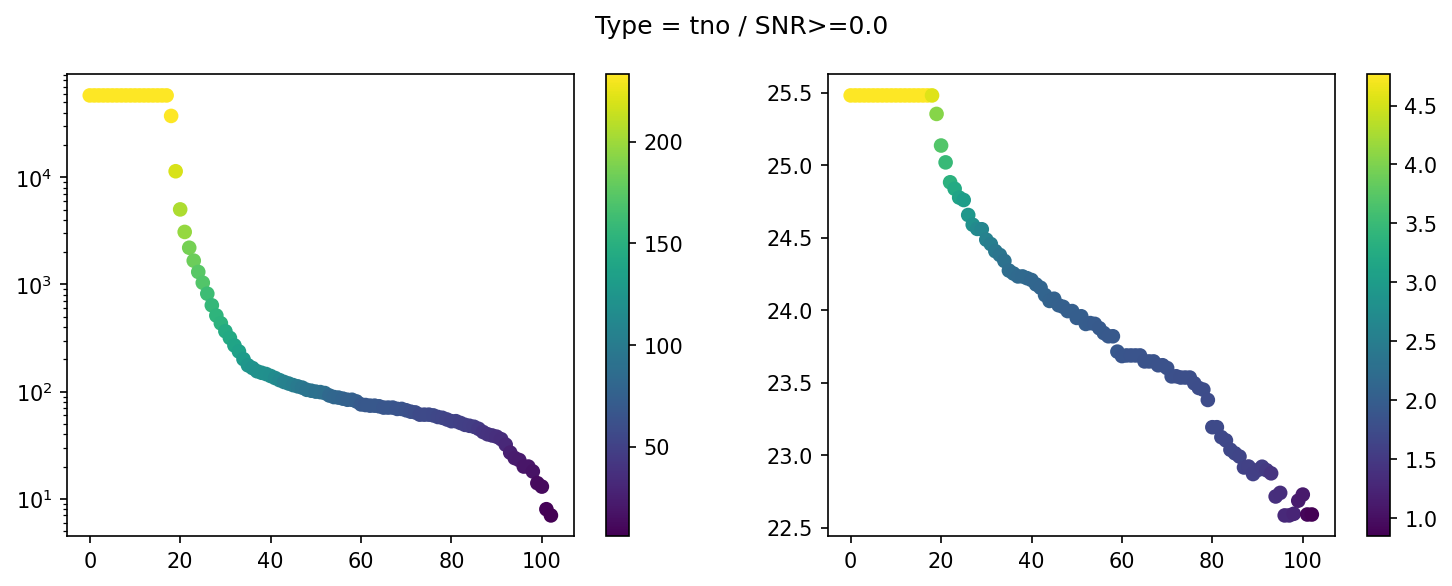

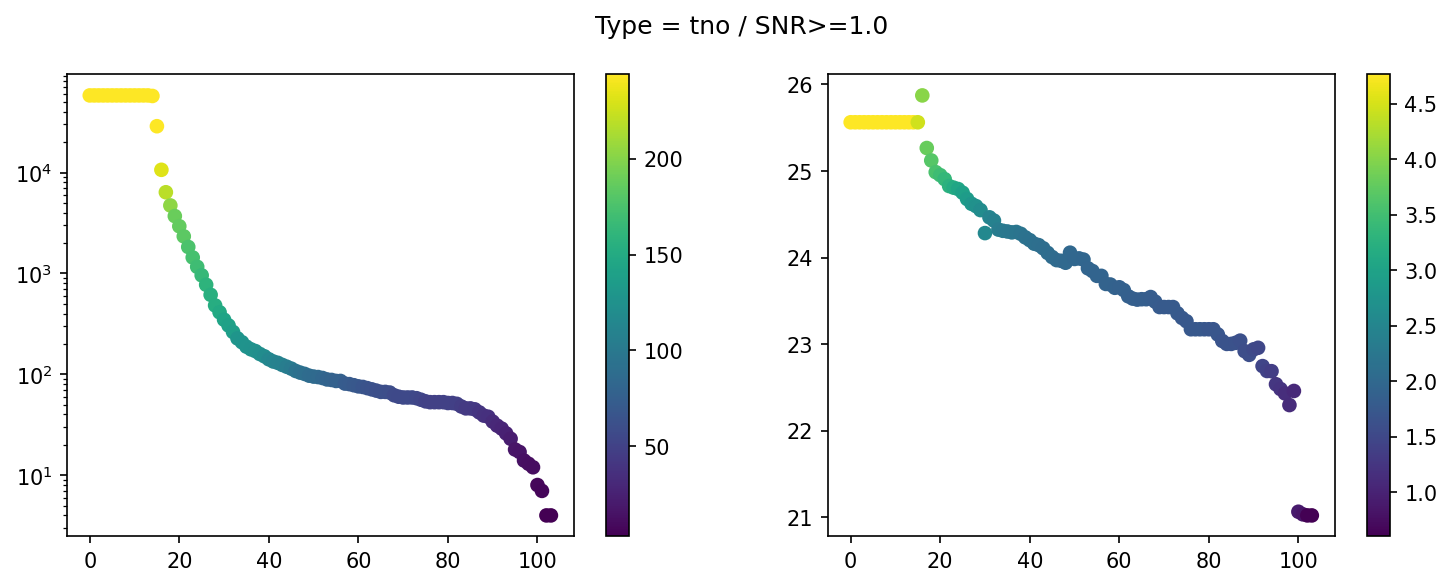

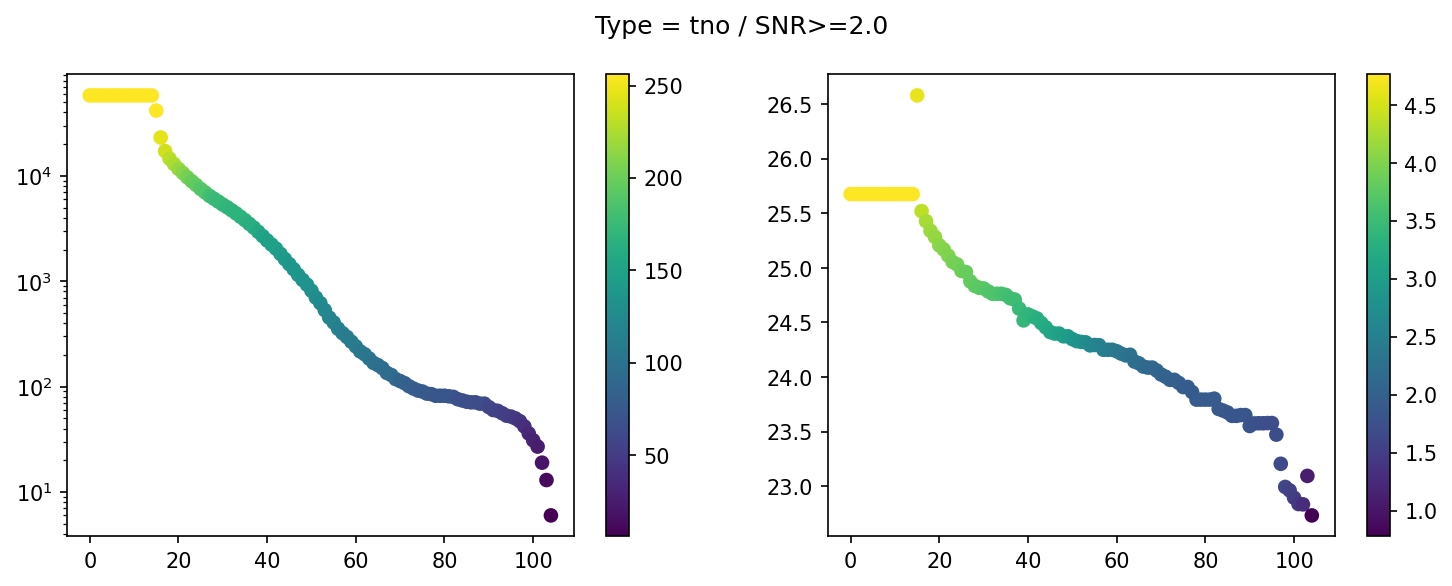

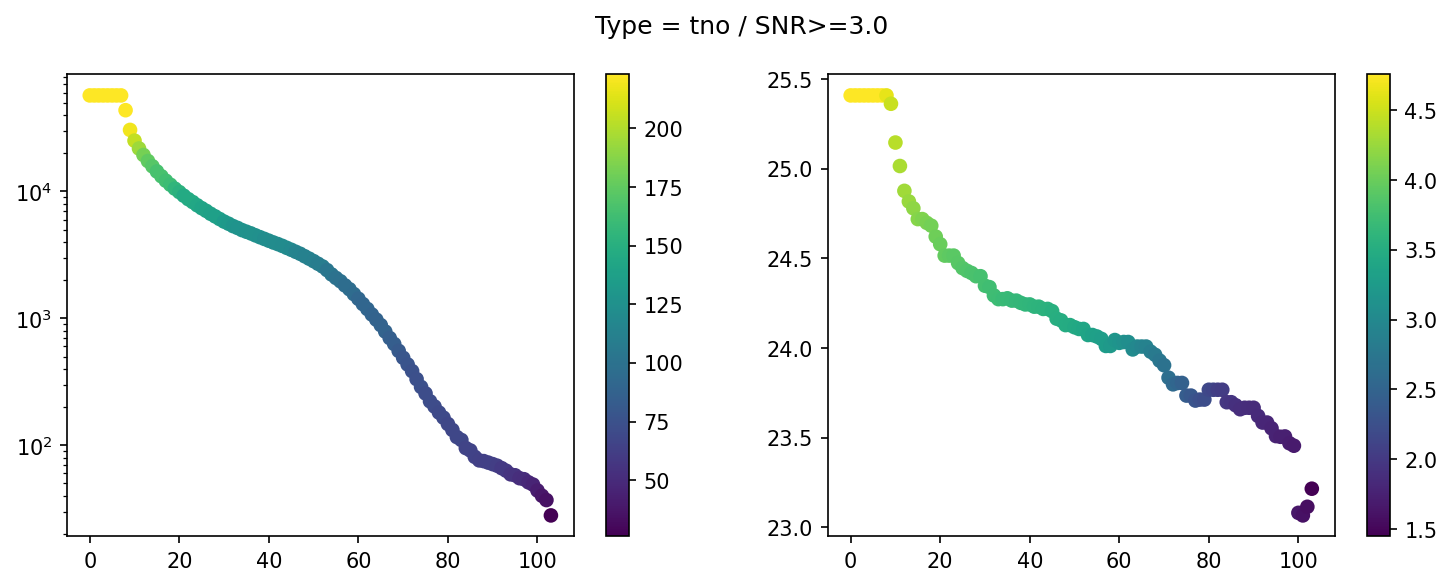

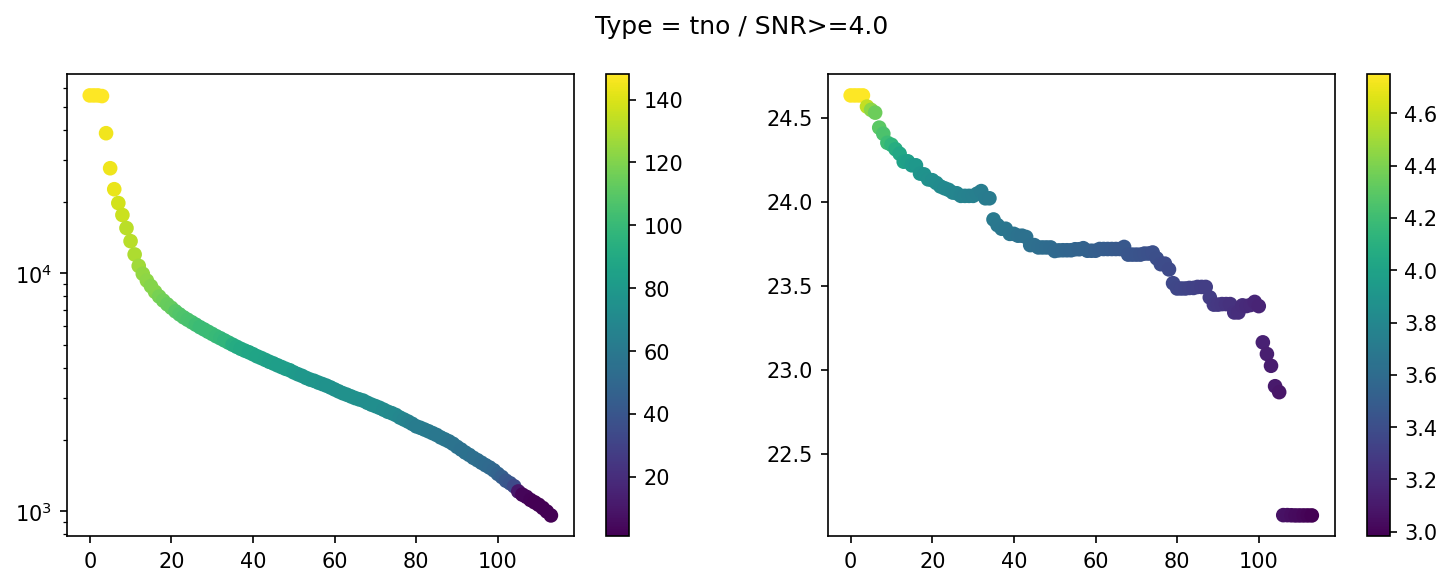

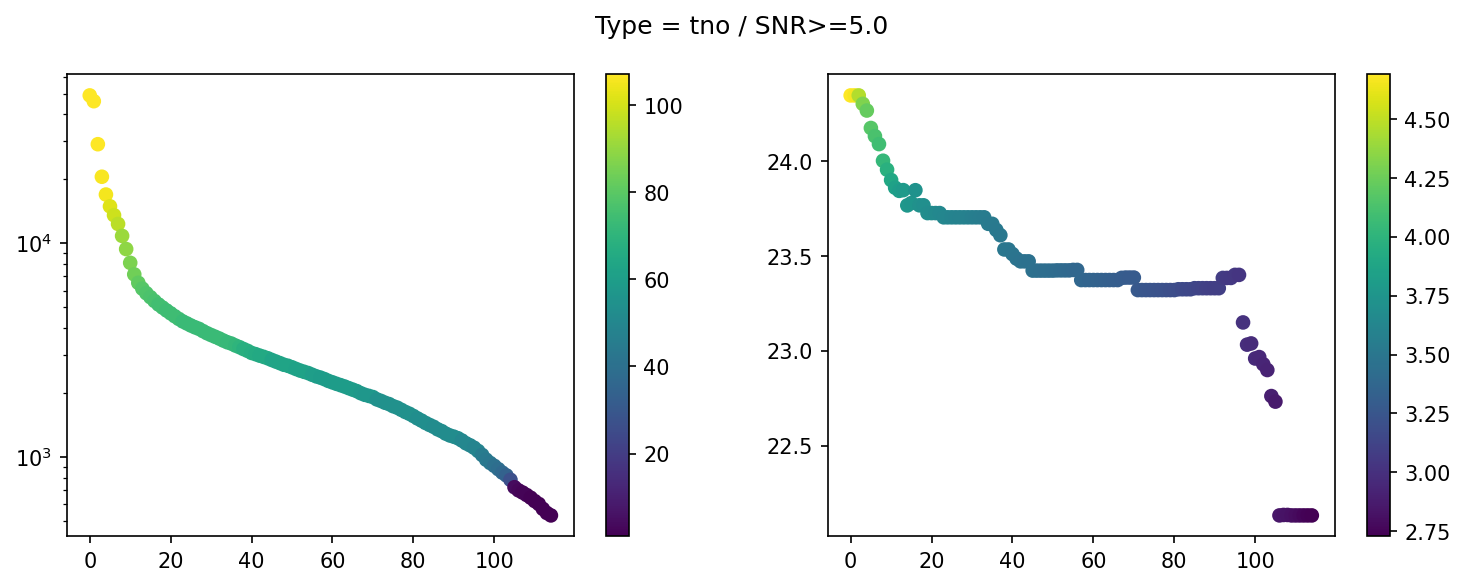

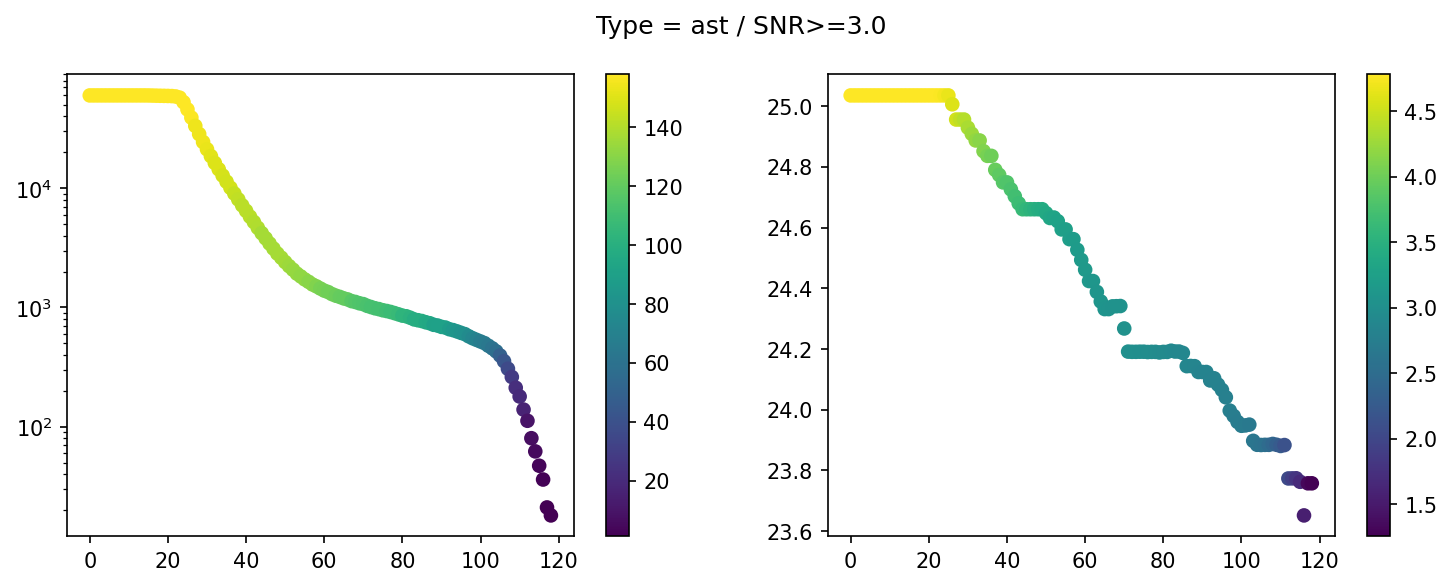

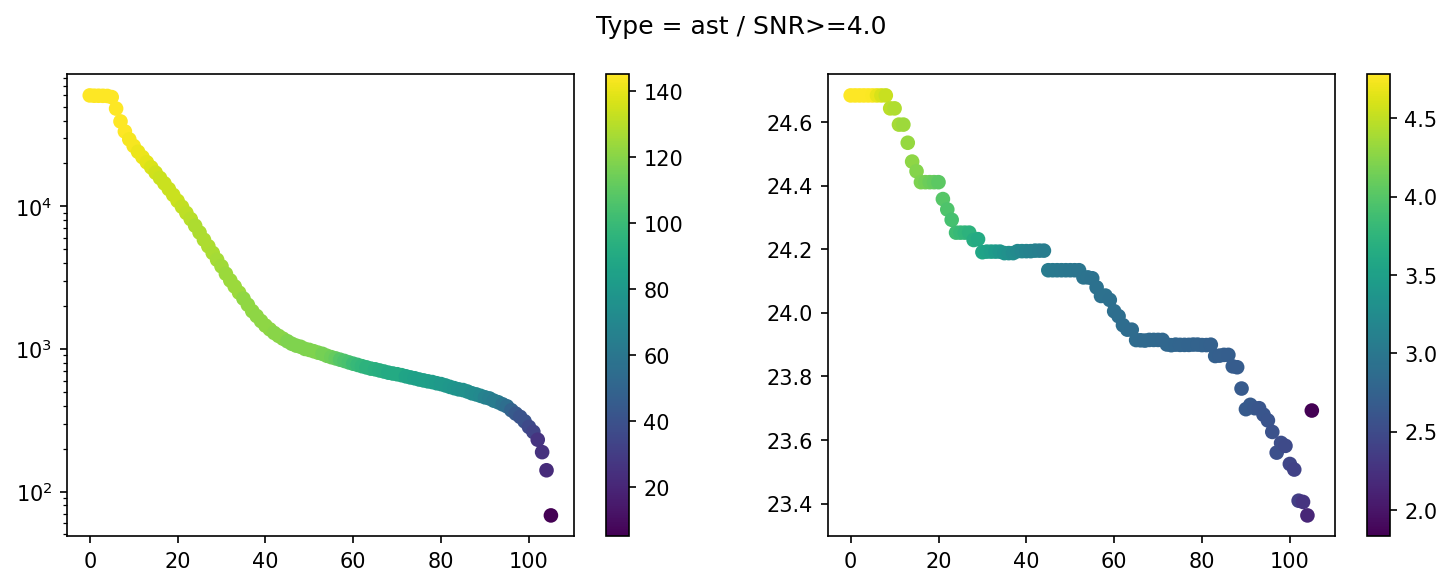

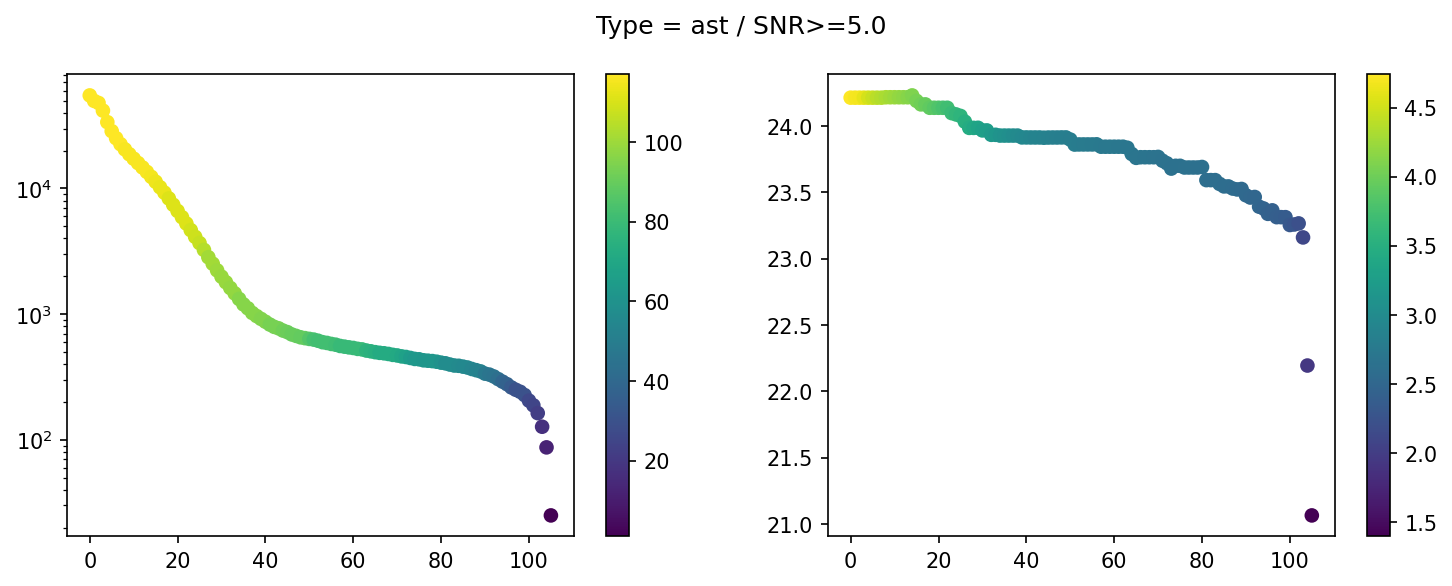

In [81]:
for t in roc_lookup:
    for snr in roc_lookup[t]:
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
        m_50 = [f['m_50'] for f in fit_results]
        m_50_err = [f['sigma_m_50'] for f in fit_results]

        fig = plt.figure(dpi=150, figsize=(12, 4))
        axs = fig.subplots(1, 2)
        axs = np.atleast_1d(axs).flatten()

        plt.sca(axs[0])
        plt.scatter(x, n_results, c=n_fakes_found)
        plt.yscale("log")
        plt.colorbar()

        plt.sca(axs[1])
        plt.scatter(x, m_50, c=np.log10(n_results))
        plt.colorbar()
        fig.suptitle(f"Type = {t} / SNR>={snr}")
        plt.show()

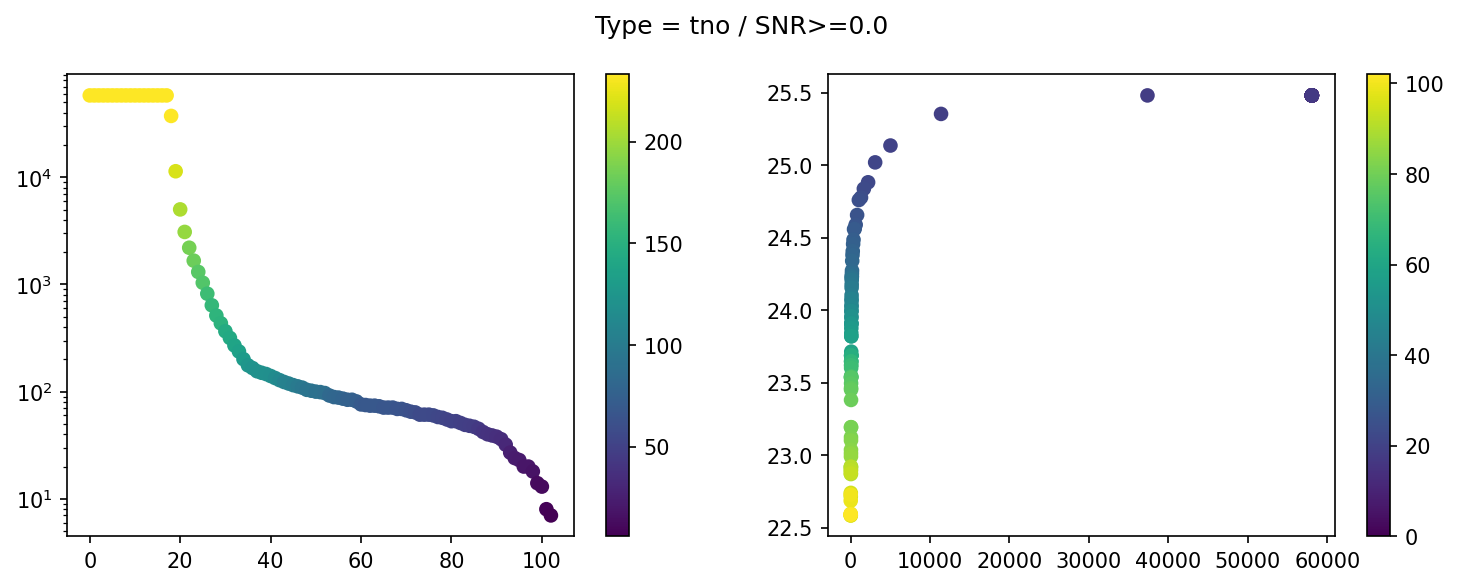

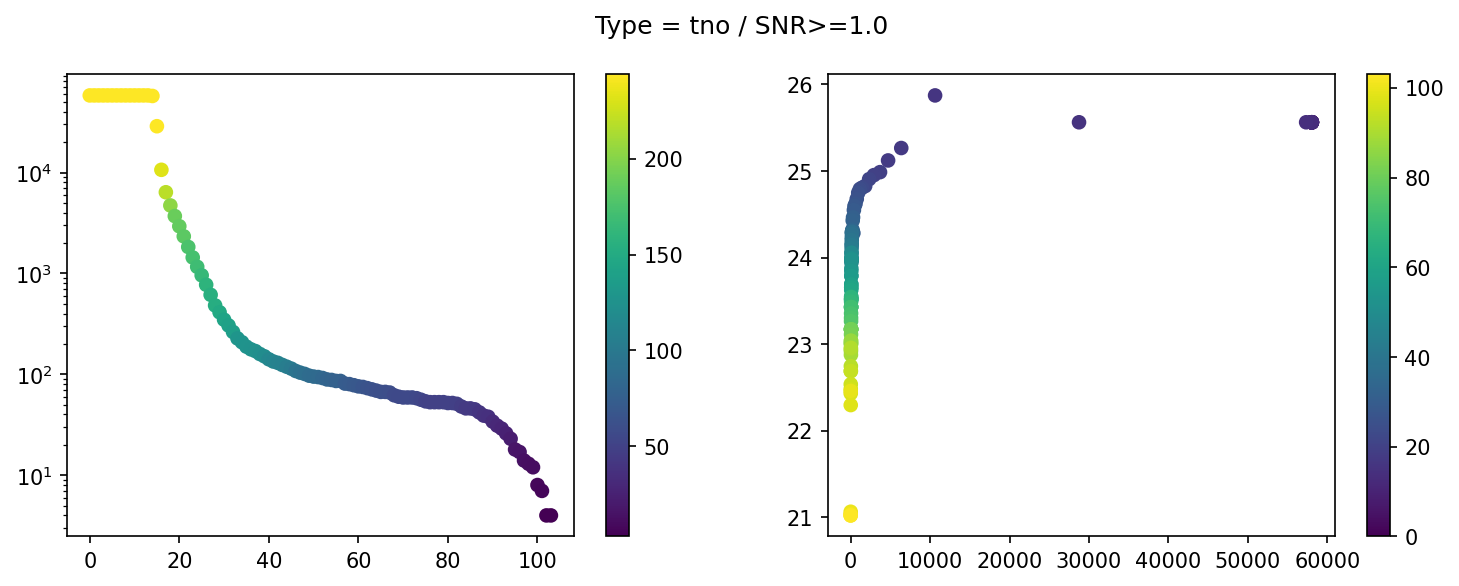

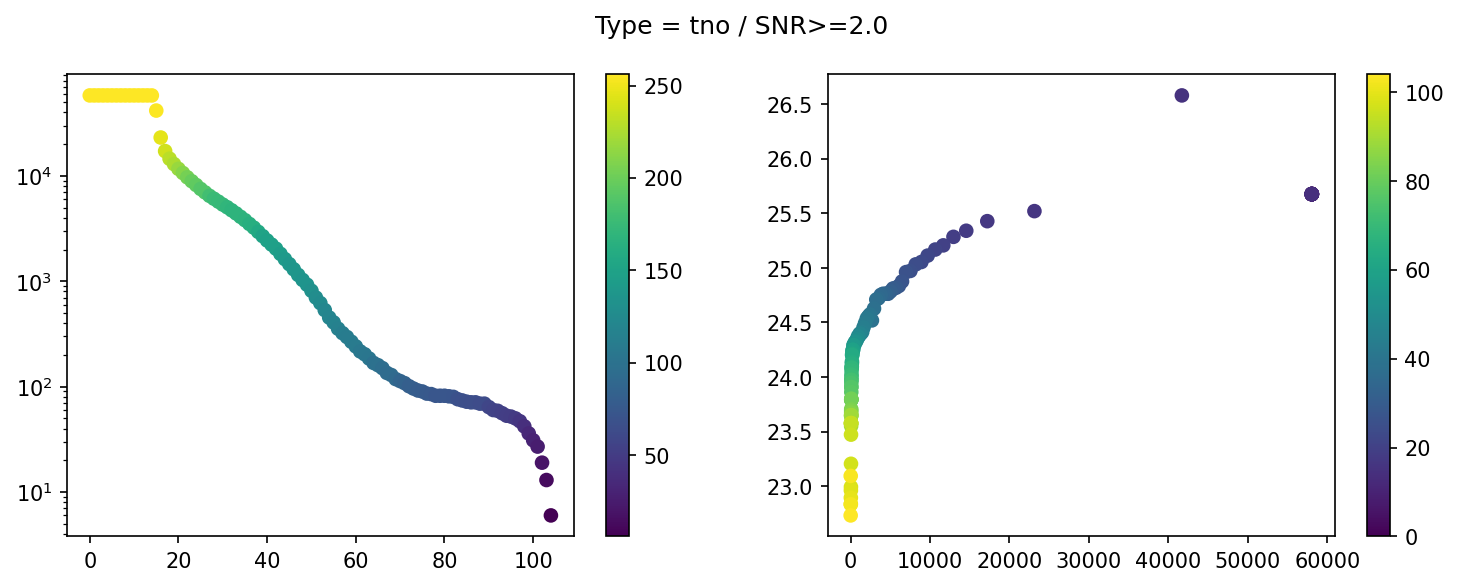

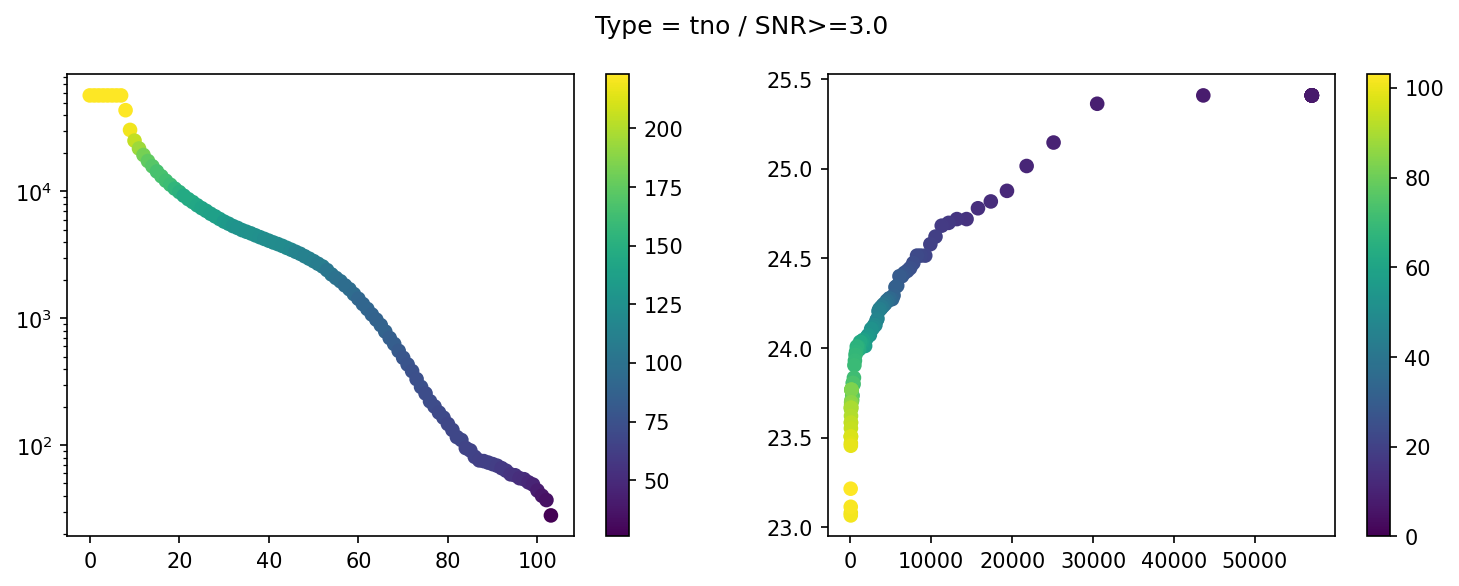

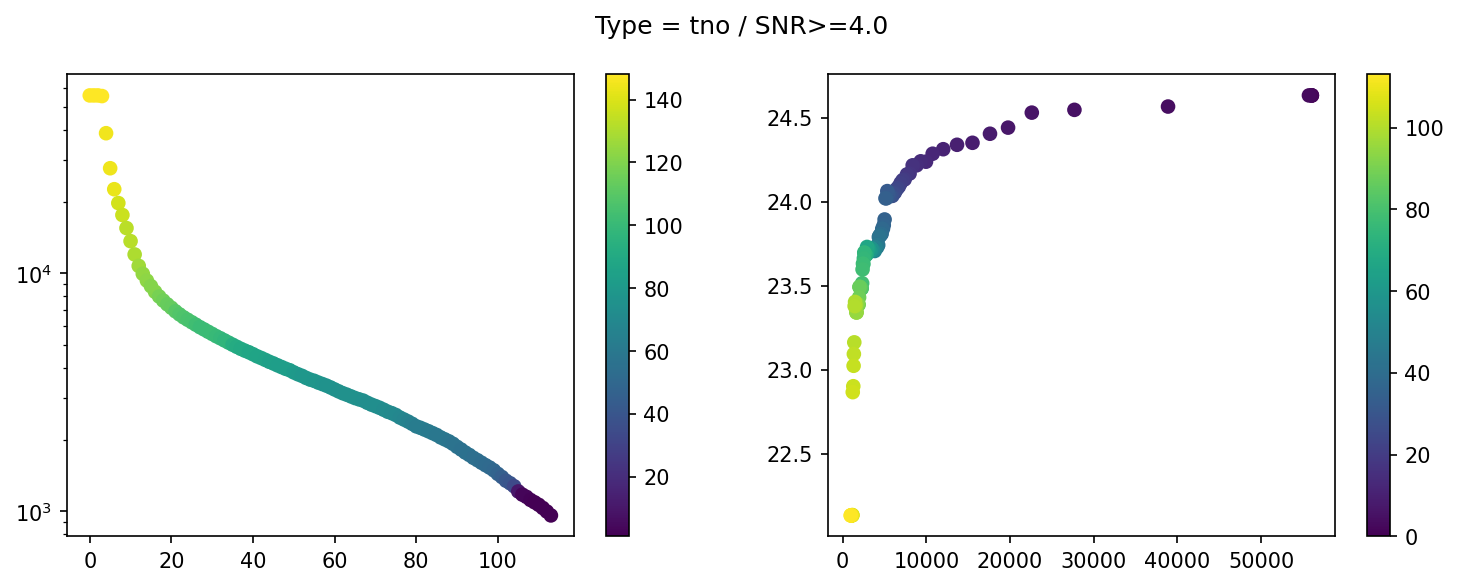

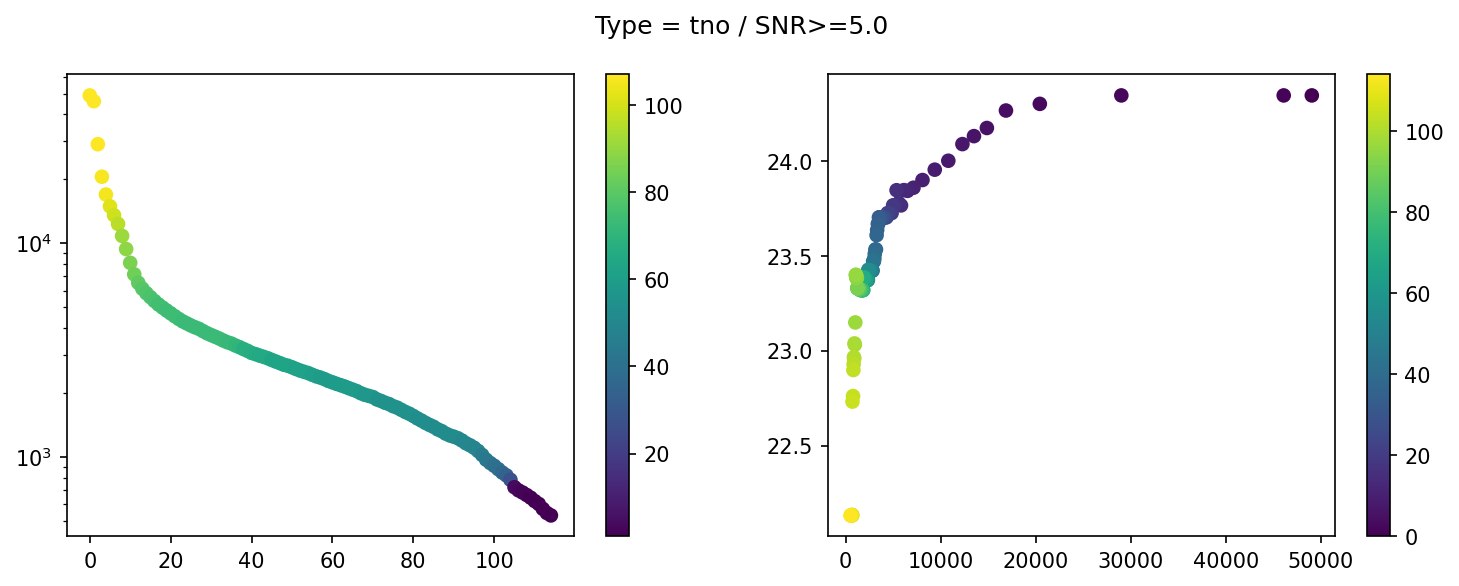

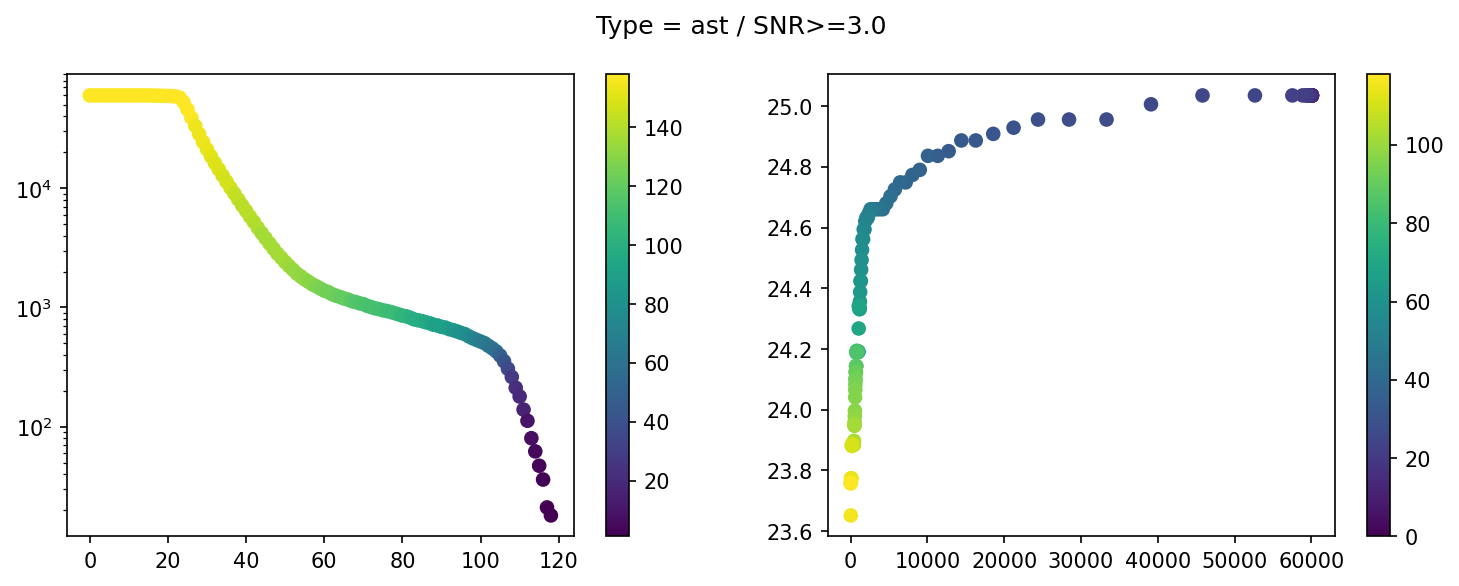

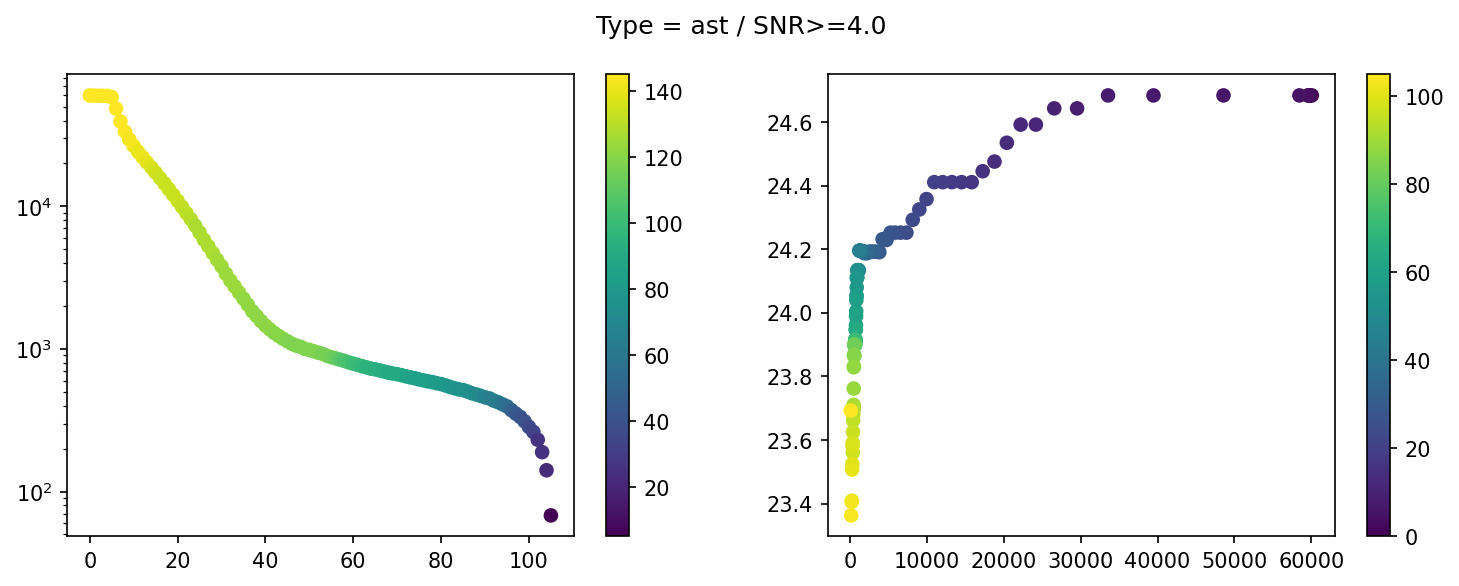

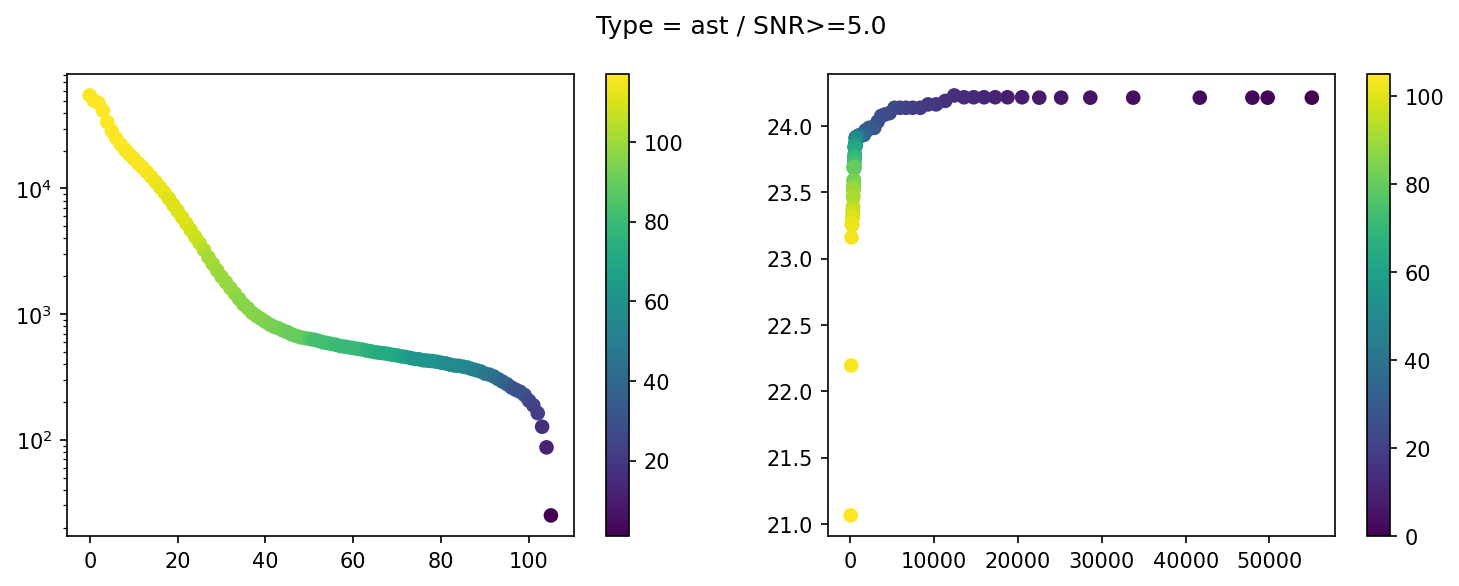

In [82]:
for t in roc_lookup:
    for snr in roc_lookup[t]:
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
        m_50 = [f['m_50'] for f in fit_results]
        m_50_err = [f['sigma_m_50'] for f in fit_results]

        fig = plt.figure(dpi=150, figsize=(12, 4))
        axs = fig.subplots(1, 2)
        axs = np.atleast_1d(axs).flatten()

        plt.sca(axs[0])
        plt.scatter(x, n_results, c=n_fakes_found)
        plt.yscale("log")
        plt.colorbar()

        plt.sca(axs[1])
        plt.scatter(n_results, m_50, c=x)
        plt.colorbar()
        fig.suptitle(f"Type = {t} / SNR>={snr}")
        plt.show()

In [478]:
# mag_ref = 23.75


In [360]:
roc_lookup['ast'][3.0]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118]),
 [{'c': 0.8156629473660526,
   'k': 5.6631358207338796,
   'm_50': 25.06461329850009,
   'sigma_c': 0.03059999763843165,
   'sigma_k': 1.5943483729206467,
   'sigma_m_50': 0.0813887161871204},
  {'c': 0.8156629473660526,
   'k': 5.6631358207338796,
   'm_50': 25.06461329850009,
   'sigma_c': 0.03059999763843165,
   'sigma

In [364]:
roc_lookup['ast'][4.0]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105]),
 [{'c': 0.8117638099723188,
   'k': 13.661963426626144,
   'm_50': 24.69211236189177,
   'sigma_c': 0.03082286585341615,
   'sigma_k': 7.264799554811733,
   'sigma_m_50': 0.05365862029633703},
  {'c': 0.8117638099723188,
   'k': 13.661963426626144,
   'm_50': 24.69211236189177,
   'sigma_c': 0.03082286585341615,
   'sigma_k': 7.264799554811733,
   'sigma_m_50': 0.05365862029633703},
  {'c': 0.

In [1]:
roc_lookup['tno'][1.0]

NameError: name 'roc_lookup' is not defined

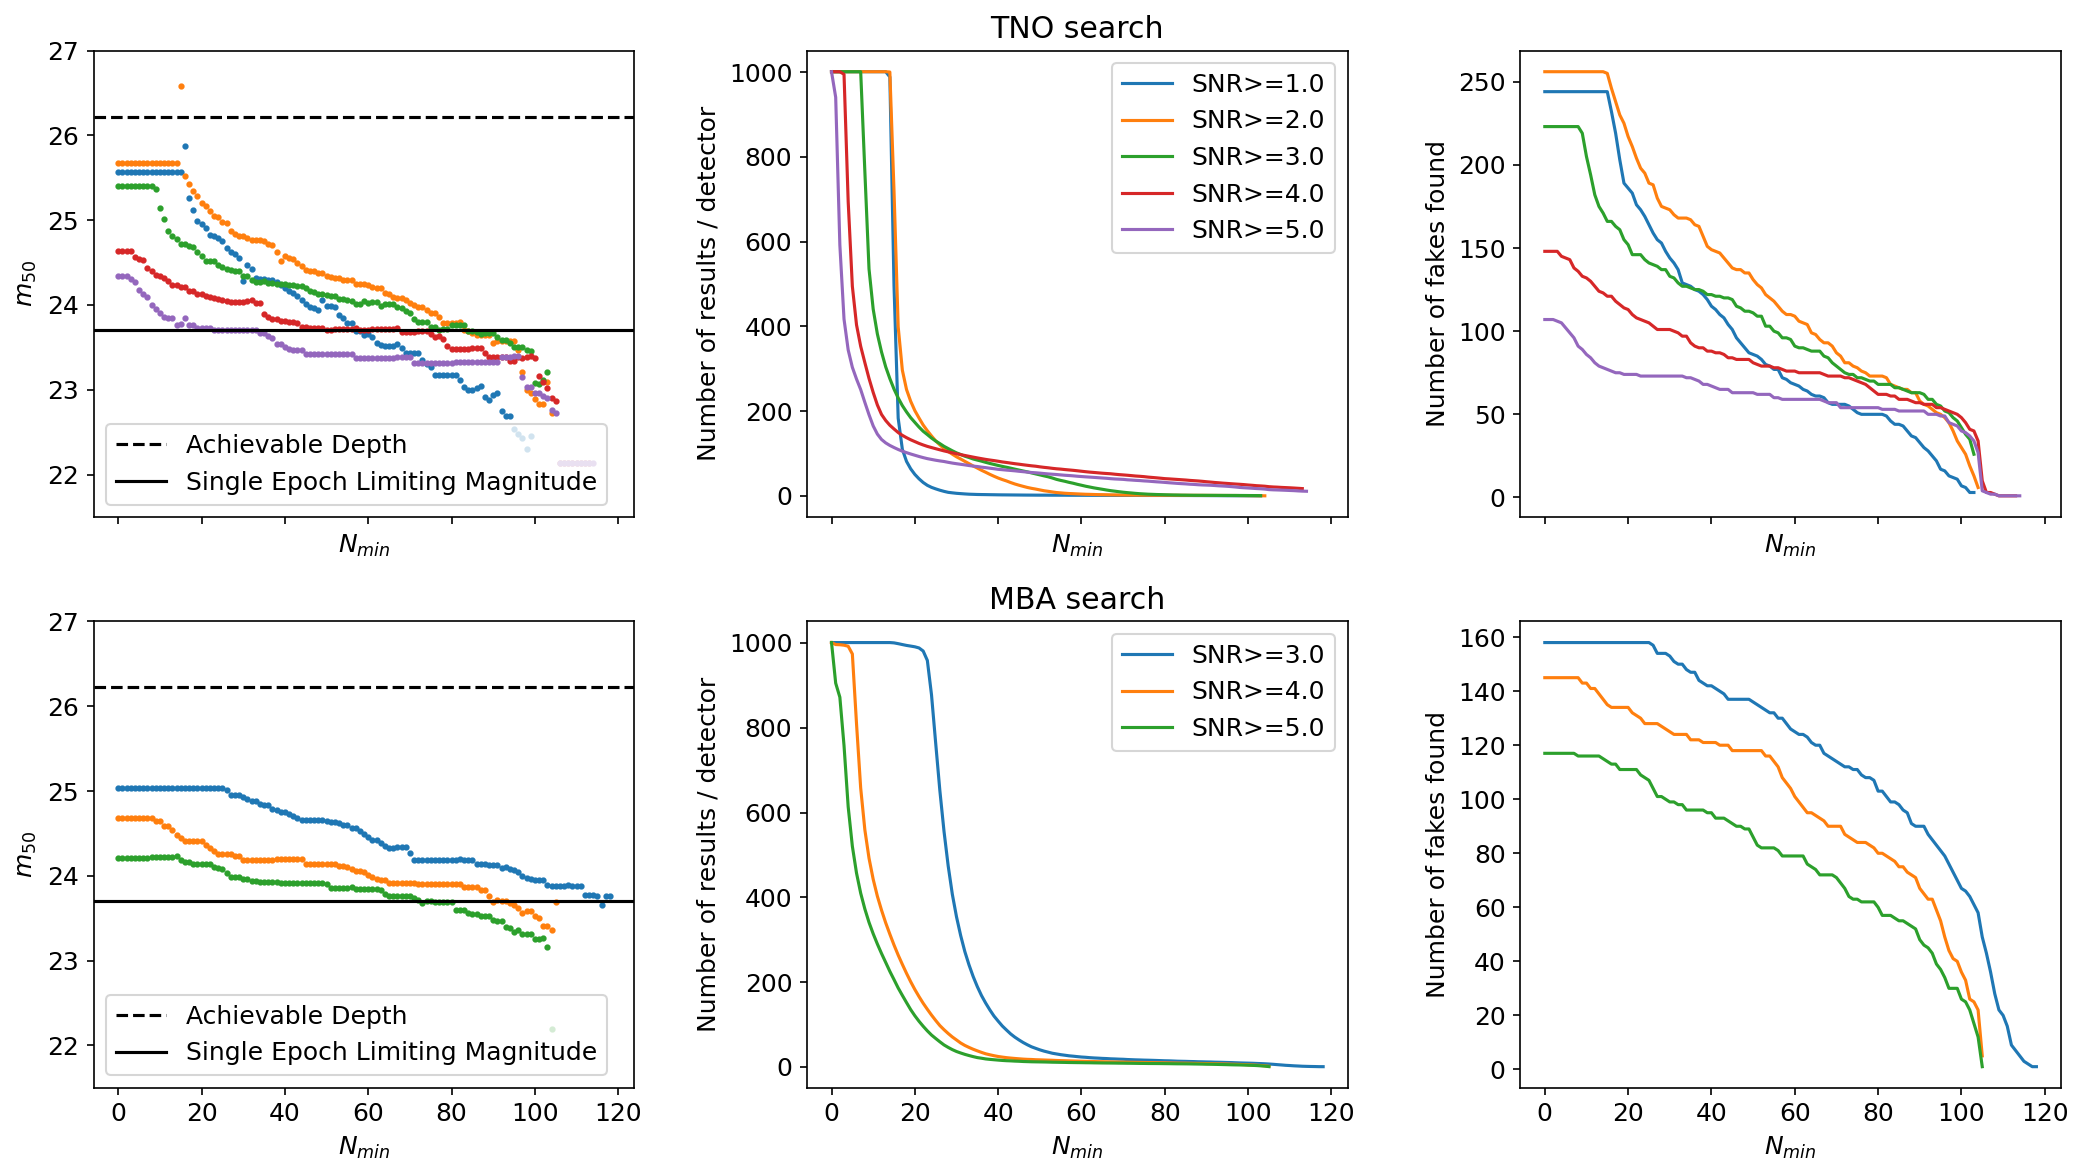

In [683]:
fig = plt.figure(dpi=150, figsize=(14, 8))
axs_2d = fig.subplots(2, 3, sharex=True)


predicted_Nmin = {
    "tno": {
        0.0: 20,
        1.0: 18,
        2.0: 20,
        3.0: 8,
        4.0: 3,
        5.0: 1,
    },
    "ast": {
        1.0: None,
        2.0: None,
        3.0: 35,
        4.0: 6,
        5.0: 2,
    },
}

_r = {t: {d : roc_lookup[t][d] for d in roc_lookup[t] if d not in [0.0]} for t in roc_lookup}
# print(_r)
for i, t in enumerate(_r):
    for j, snr in enumerate(_r[t]):
#         if snr == 0.0:
#             continue

        if t == "ast":
            d = joined_ast
        else:
            d = joined_tno
        n_detectors = len(set(d[d['snr'] == snr]['detector']))        
        
        axs = axs_2d[i]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
#         plt.errorbar(x, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2, label=f"SNR>={snr}")
        plt.scatter(x, m_50, s=4)
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
#         plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(x, n_results / n_detectors, color=f'C{j}', label=f"SNR>={snr}")
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
        
        plt.sca(axs[2])
        plt.plot(x, n_fakes_found)
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
    #     plt.colorbar()
        plt.sca(axs[0])
        plt.xlabel("$N_{min}$")
        plt.ylabel("$m_{50}$")

        if j == 0:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")

        plt.ylim(21.5, 27)
        plt.legend(loc='lower left')
        plt.sca(axs[1])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of results / detector")
        plt.title({"tno": "TNO", "ast": "MBA"}.get(t) + " search")
        plt.legend()

        plt.sca(axs[2])
        plt.xlabel("$N_{min}$")
        plt.ylabel("Number of fakes found")
    

fig.tight_layout()
plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
plt.show()

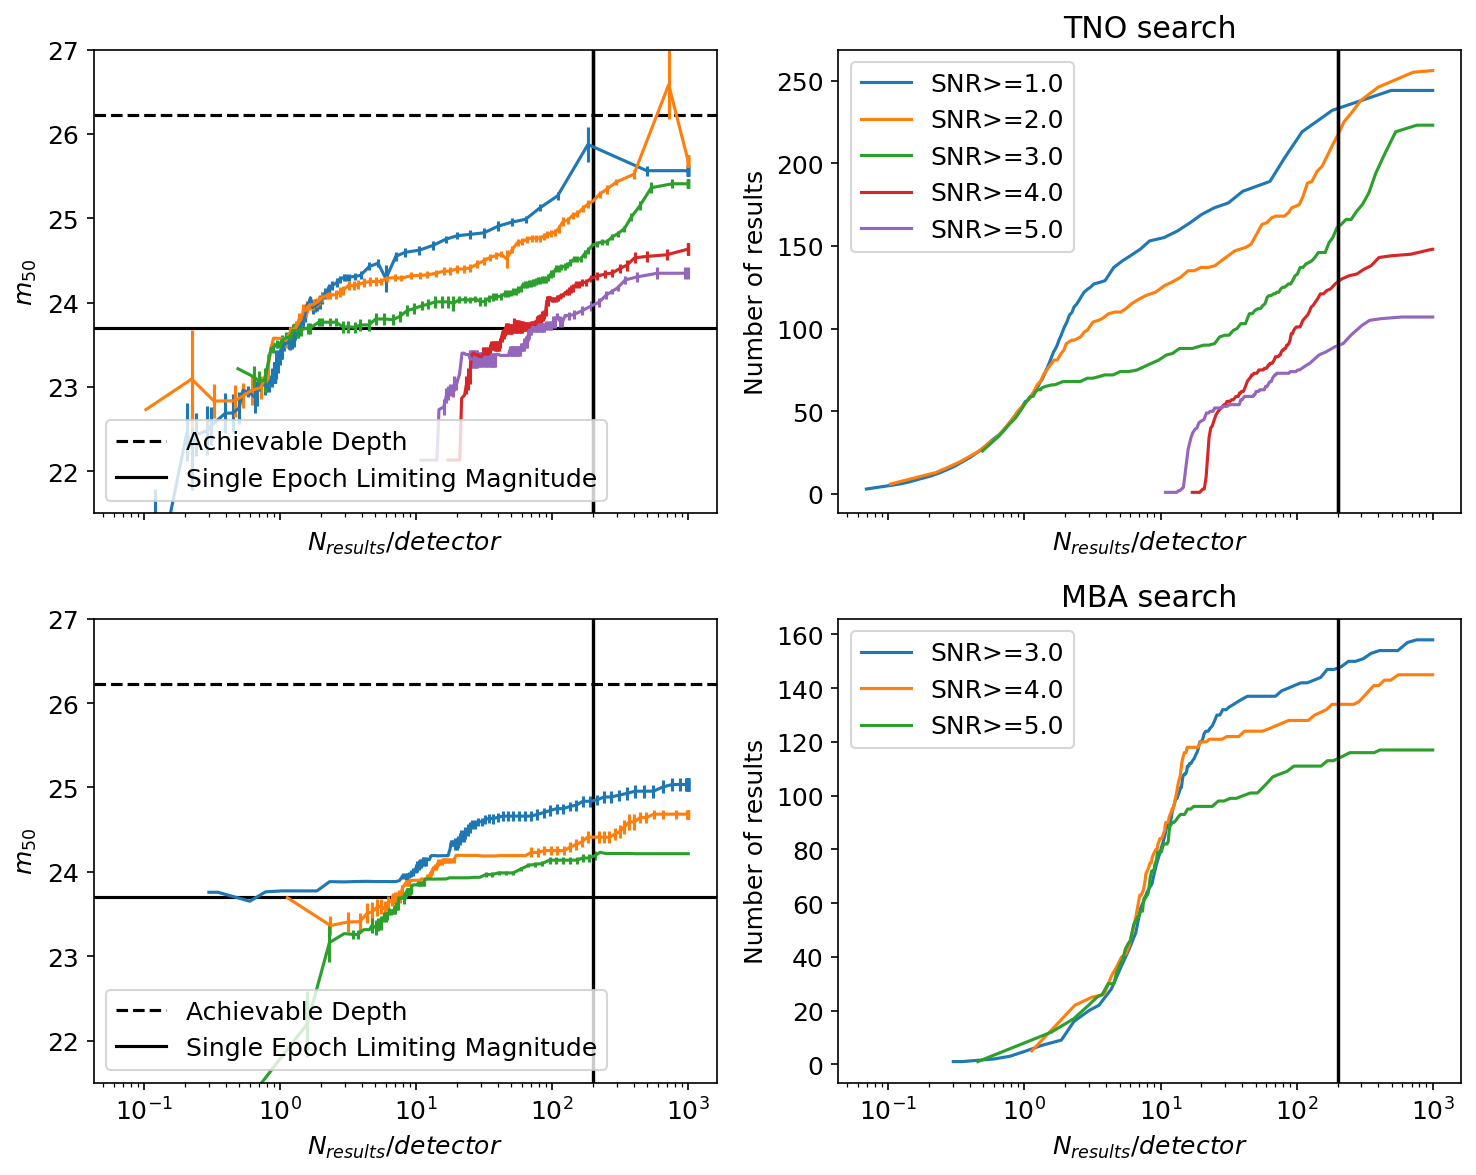

In [682]:
fig = plt.figure(dpi=150, figsize=(10, 8))
axs_2d = fig.subplots(2, 2, sharex=True)


predicted_Nmin = {
    "tno": {
        0.0: 20,
        1.0: 18,
        2.0: 20,
        3.0: 8,
        4.0: 3,
        5.0: 1,
    },
    "ast": {
        1.0: None,
        2.0: None,
        3.0: 35,
        4.0: 6,
        5.0: 2,
    },
}
    
for i, t in enumerate(_r):
    did_line = False
    for j, snr in enumerate(_r[t]):
        if snr == 0:
            continue
        axs = axs_2d[i]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
        

        if t == "ast":
            d = joined_ast
        else:
            d = joined_tno
        n_detectors = len(set(d[d['snr'] == snr]['detector']))        
        
#         n_detectors = len(set(j['detector']))
#         
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        m = m_50_err > 1
        m_50_err[m] = np.nan
        plt.sca(axs[0])
#         plt.errorbar(x, m_50, yerr=m_50_err, fmt='o', lw=1, ms=2, label=f"SNR>={snr}")
#         plt.scatter(n_results / n_detectors, m_50, s=4, color=f'C{j}')
        plt.errorbar(n_results / n_detectors, m_50, yerr=m_50_err, ms=4, color=f'C{j}')
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
    #     plt.yscale("log")
    #     plt.colorbar()

        plt.sca(axs[1])
        plt.plot(n_results / n_detectors, n_fakes_found, color=f'C{j}', label=f"SNR>={snr}")
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
        
#         plt.sca(axs[2])
#         plt.plot(n_results, m_50)
#         plt.axvline(predicted_Nmin[t][snr], color=f"C{j}", ls='--')
    #     plt.colorbar()
        plt.sca(axs[0])
        plt.xscale("log")
        plt.xlabel("$N_{results} / detector$")
        plt.ylabel("$m_{50}$")
        plt.axvline(200, color='k')

        if not did_line:
#             plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
#             plt.axhline(mag_ref, color='k', ls=':', label="Single Epoch Limiting Magnitude")
#             plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
            plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
            plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
            did_line = True

        plt.ylim(21.5, 27)
        plt.legend(loc='lower left')
        plt.sca(axs[1])
        plt.axvline(200, color='k')
        plt.xlabel("$N_{results} / detector$")
        plt.ylabel("Number of results")
        plt.title({"tno": "TNO", "ast": "MBA"}.get(t) + " search")
        plt.legend()

#         plt.sca(axs[2])
#         plt.xlabel("$N_{min}$")
#         plt.ylabel("Number of fakes found")
    

fig.tight_layout()
# plt.savefig(f"figures/m50_and_num_results_vs_Nmin.pdf")
# plt.savefig(f"figures/m50_and_num_results_vs_Nmin.png")
plt.show()

/tmp/ipykernel_19519/1922016591.py:18: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


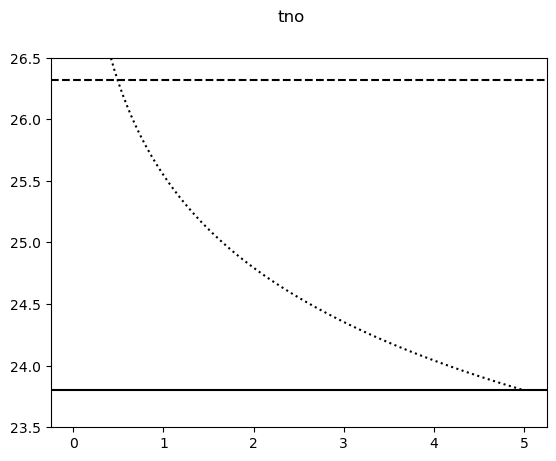

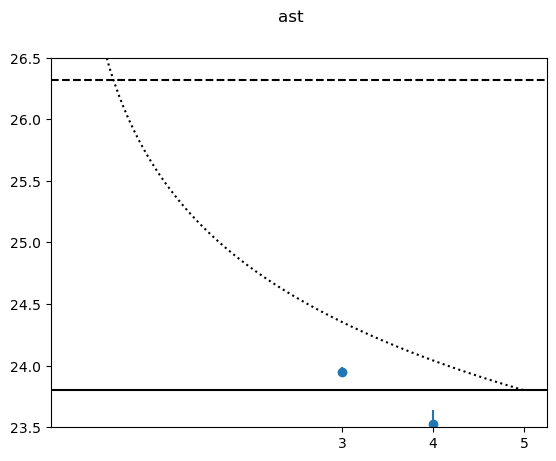

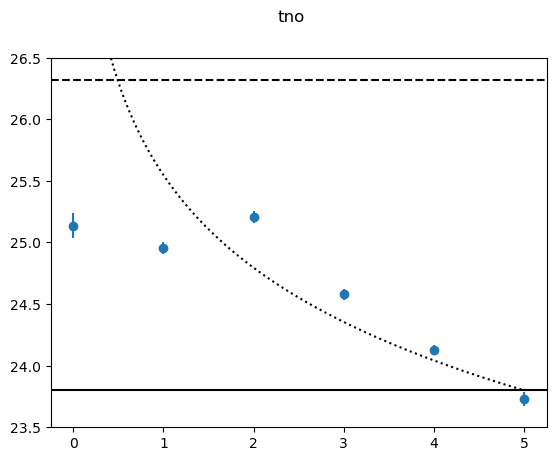

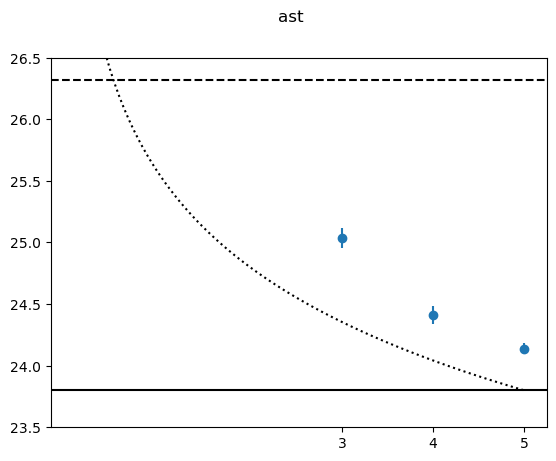

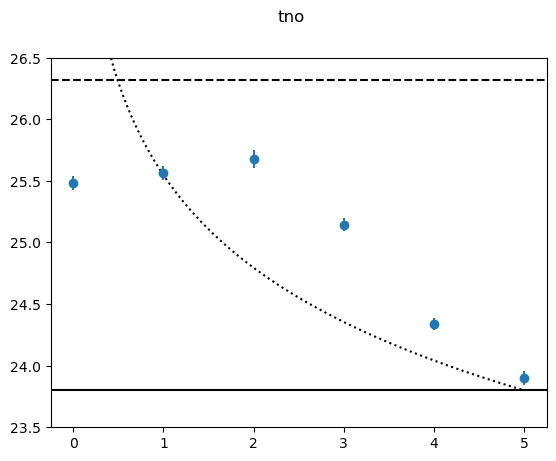

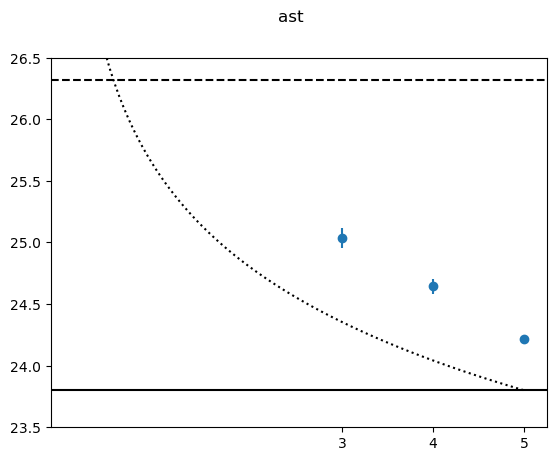

In [96]:
# fix N_min=20 and then compare
for N_min in [100, 20, 10]:
    for t in roc_lookup:
        fig = plt.figure()
        _x = []
        _y = []
        _y_err = []
        for snr in roc_lookup[t]:
            x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
            m_50 = np.array([f['m_50'] for f in fit_results])
            m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
            _x.append(snr)
            _y.append(m_50[x == N_min][0])
            _y_err.append(m_50_err[x == N_min][0])
        plt.errorbar(_x, _y, yerr=_y_err, fmt='o')
        plt.xticks(_x)
        __x = np.linspace(0, 5, 100)
        __y = mag_ref - 5/2*np.log10(np.array(__x)/5)
        plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
        plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
        plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
        # plt.scatter(_x, _y)
        plt.ylim(23.5, 26.5)

        fig.suptitle(f"{t}")
        plt.show()

In [536]:
n_results[x == N_min]

array([33741])

In [537]:
n_fakes_found[x == N_min]

array([117])

In [583]:
t = "ast"
snr = 5.0

if t == "ast":
    j = joined_ast
else:
    j = joined_tno
    
n_detectors = len(set(j[j['snr'] == snr]['detector']))
N_min = N_min_lookup[t][snr]

x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]

m_50 = np.array([f['m_50'] for f in fit_results])
m_50_err = np.array([f['sigma_m_50'] for f in fit_results])

N_min, n_fakes_found[x == N_min], n_results[x == N_min] / n_detectors

(4, array([117]), array([613.47272727]))

/tmp/ipykernel_19519/2878082529.py:33: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


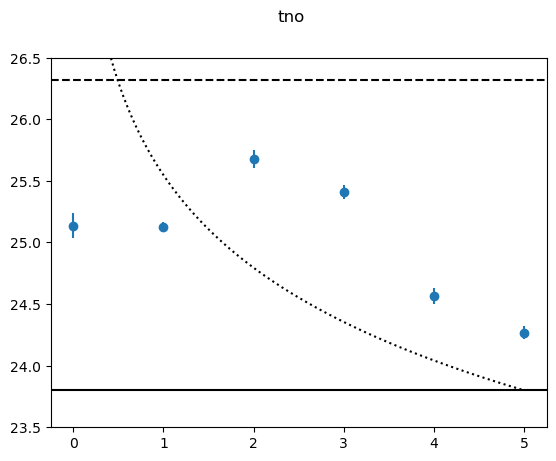

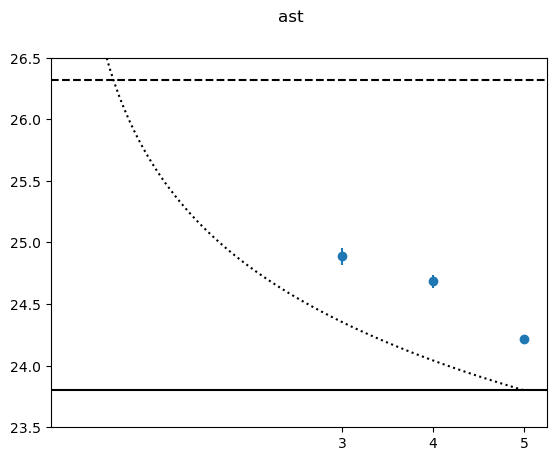

In [86]:
# fix N_min=20 and then compare
N_min_lookup = {
    "ast": {
        5.0: 4,
        4.0: 6,
        3.0: 32,
    },
    "tno": {
        5.0: 4,
        4.0: 4,
        3.0: 8,
        2.0: 10,
        1.0: 18,
        0.0: 20,
    }
}
for t in roc_lookup:
    fig = plt.figure()
    _x = []
    _y = []
    _y_err = []
    for snr in roc_lookup[t]:
        N_min = N_min_lookup[t][snr]
        x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
        m_50 = np.array([f['m_50'] for f in fit_results])
        m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
        _x.append(snr)
        _y.append(m_50[x == N_min][0])
        _y_err.append(m_50_err[x == N_min][0])
    plt.errorbar(_x, _y, yerr=_y_err, fmt='o')
    plt.xticks(_x)
    __x = np.linspace(0, 5, 100)
    __y = mag_ref - 5/2*np.log10(np.array(__x)/5)
    plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
    plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
    plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
    # plt.scatter(_x, _y)
    plt.ylim(23.5, 26.5)
    
    fig.suptitle(f"{t}")
    plt.show()

In [136]:
(5/2)*np.log10(np.sqrt(len(images)))

2.5212916741234754

In [501]:
len(set(joined_tno[joined_tno['snr'] == 1.0]['detector']))

58

In [663]:
roc_lookup.keys()

dict_keys(['tno', 'ast'])

tno 1.0 17
tno 2.0 29
tno 3.0 30
tno 4.0 30
tno 5.0 19
ast 3.0 41
ast 4.0 26
ast 5.0 22


/tmp/ipykernel_19519/4238565290.py:41: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


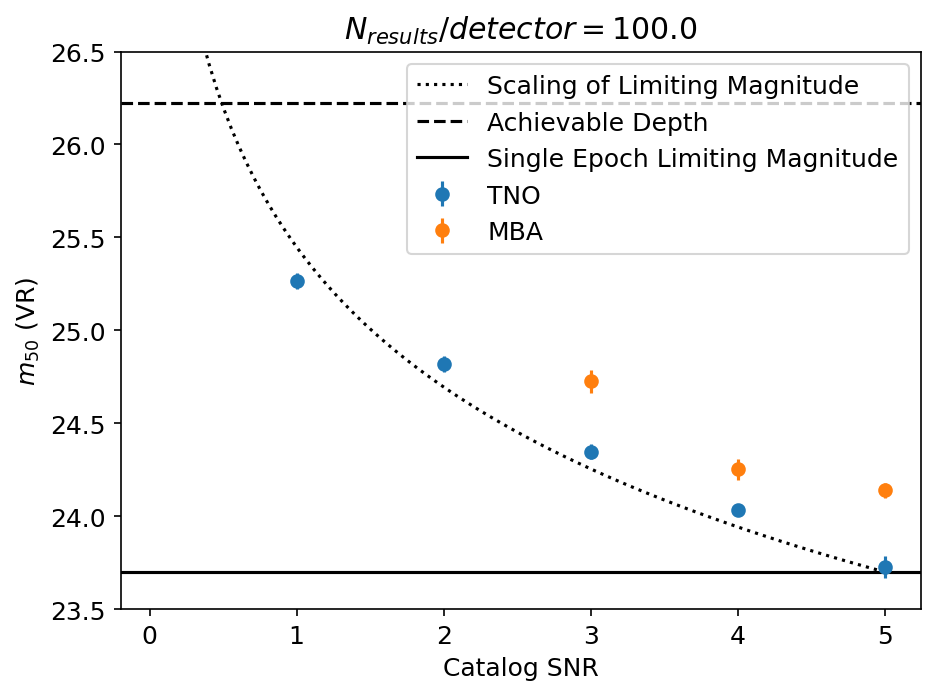

tno 1.0 16
tno 2.0 20
tno 3.0 18
tno 4.0 12
tno 5.0 9
ast 3.0 35
ast 4.0 19
ast 5.0 15


/tmp/ipykernel_19519/4238565290.py:41: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


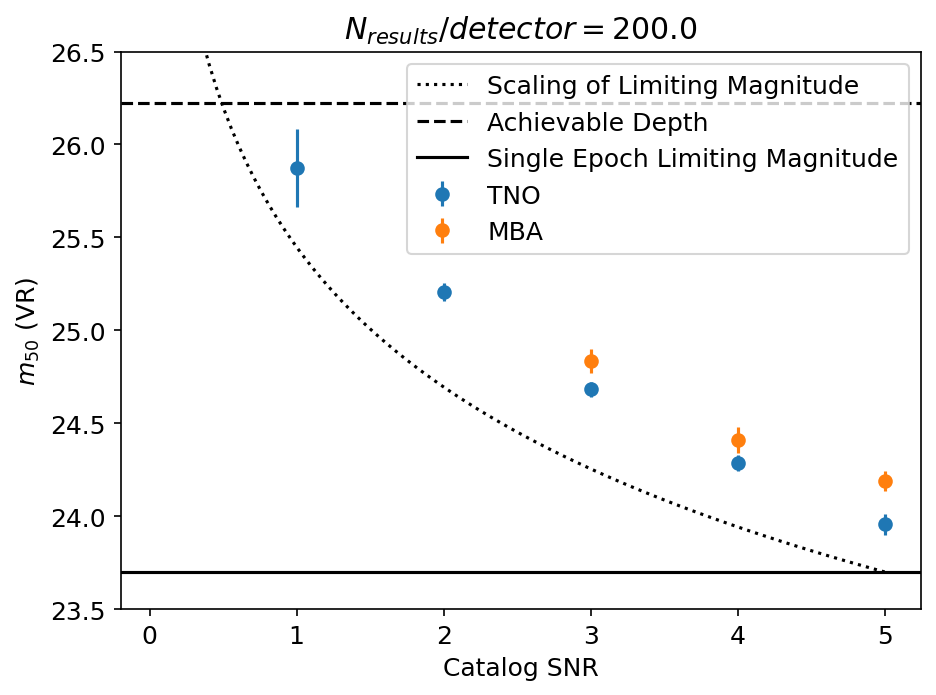

tno 1.0 16
tno 2.0 17
tno 3.0 13
tno 4.0 8
tno 5.0 5
ast 3.0 31
ast 4.0 15
ast 5.0 11


/tmp/ipykernel_19519/4238565290.py:41: RuntimeWarning: divide by zero encountered in log10
  __y = mag_ref - 5/2*np.log10(np.array(__x)/5)


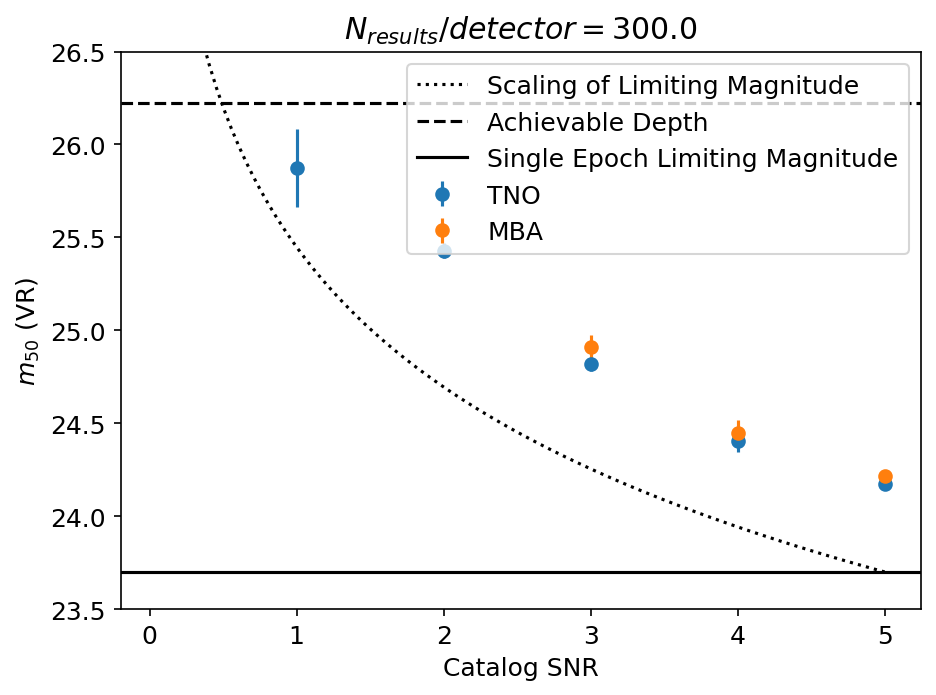

In [684]:
# fix number of results and then compare

N_results = int(2e2) * 60
for n in [1e2, 2e2, 3e2]:
    plt.figure()
    for t in roc_lookup:
#         if t == 'ast':
#             continue
            
        _x = []
        _y = []
        _y_err = []
        
        for snr in roc_lookup[t]:
            if snr == 0:
                continue
            if t == "ast":
                j = joined_ast
            else:
                j = joined_tno
            n_detectors = len(set(j[j['snr'] == snr]['detector']))
            N_results = int(n) * n_detectors
            
            x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
            m_50 = np.array([f['m_50'] for f in fit_results])
            m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
            closest = np.argmin(np.abs(np.array(n_results) - N_results))
            print(t, snr, closest)
            fpr = n_fakes_found / N_results
            _x.append(snr)
            _y.append(m_50[closest])
            _y_err.append(m_50_err[closest])

        plt.errorbar(_x, _y, yerr=_y_err, fmt='o', label={"tno": "TNO", "ast": "MBA"}.get(t))
        
#         print(t, _x, _y, _y_err)
#         for i, j, k in zip(_x, _y, _y_err):
#             print("{}")
#         plt.scatter(_x, _y, label="Search")#label={"tno": "TNO", "ast": "MBA"}.get(t))
    __x = np.linspace(0, 5, 100)
    __y = mag_ref - 5/2*np.log10(np.array(__x)/5)
    plt.plot(__x, __y, color='k', ls=":", label="Scaling of Limiting Magnitude")
    plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
    plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")
    # plt.scatter(_x, _y)
    plt.ylim(23.5, 26.5)
    plt.legend()
#     plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel("Catalog SNR")
    plt.ylabel("$m_{50}$ (VR)")
    plt.title("$N_{results}/detector = $" + str(N_results/n_detectors))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/m50_Nresults_{n}.pdf")
    plt.savefig(f"figures/m50_Nresults_{n}.png")
    plt.show()

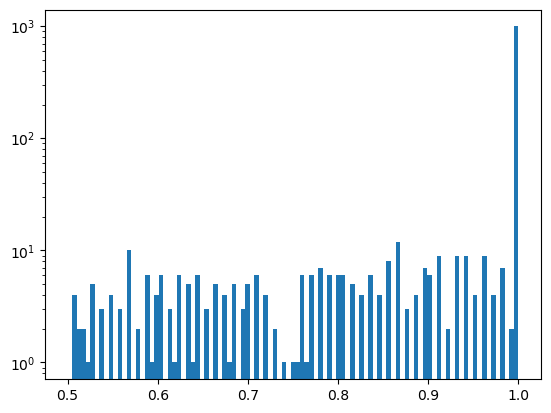

In [84]:
plt.hist(joined['ratio'], bins=np.linspace(0.5, 1, 100))
plt.yscale("log")
plt.show()

In [114]:
len(x), len(y), len(c)

(115, 115, 115)

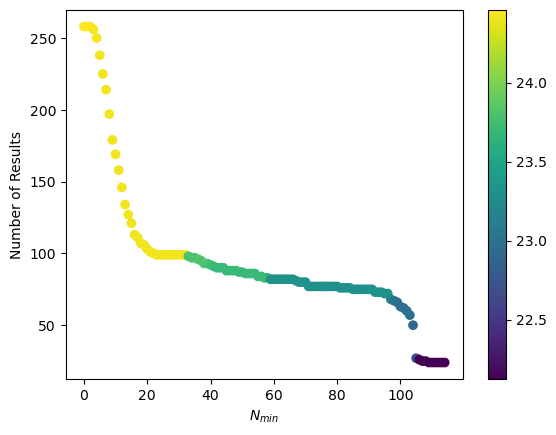

In [ ]:
def number_of_votes()

In [36]:
joined

<Table length=1731>
ORBITID  found_in       ratio        found ...   type   binary findable
                                           ...                         
 int64    int64        float64        bool ...   str8    bool    bool  
-------- -------- ------------------ ----- ... -------- ------ --------
 2405372       34                1.0  True ...      tno  False     True
 2405372      142                1.0  True ...      tno  False     True
 2405372      353 0.8365384615384616  True ...      tno  False     True
 3881210       -1               -1.0 False ...      tno  False     True
 4279478      334                1.0  True ...      tno  False     True
 4279478       98                1.0  True ...      tno  False     True
 5962014       -1               -1.0 False ...      tno  False     True
 5962014       30                1.0  True ...      tno  False     True
 5962014      150                1.0  True ...      tno  False     True
     ...      ...                ...   ... ...      ...    ...      ...
10200778       -1               -1.0 False ... asteroid  False    False
10200778      221 0.9807692307692307  True ... asteroid  False    False
10200778      150                1.0  True ... asteroid  False    False
12084118      116                1.0  True ... asteroid  False    False
12084118       -1               -1.0 False ... asteroid  False    False
12084118       -1               -1.0 False ... asteroid  False    False
12084118      120                1.0  True ... asteroid  False    False
14649253       -1               -1.0 False ... asteroid  False    False
14649253       -1               -1.0 False ... asteroid  False    False
14649253       -1               -1.0 False ... asteroid  False    False

In [32]:
joined[joined['snr'] == 2.0]

<Table length=429>
ORBITID  found_in  ratio  found ...        mag           type   binary findable
                                ...                                            
 int64    int64   float64  bool ...      float64         str8    bool    bool  
-------- -------- ------- ----- ... ------------------ -------- ------ --------
 2405372       34     1.0  True ... 24.573885428055313      tno  False     True
 3881210       -1    -1.0 False ... 26.306819324841076      tno  False     True
 4279478       98     1.0  True ...  24.78000547555636      tno  False     True
 5962014       30     1.0  True ... 24.547227600193064      tno  False     True
10041343       -1    -1.0 False ... 22.428972985079255 asteroid  False     True
10053463       -1    -1.0 False ... 25.510115611523307 asteroid  False     True
13039521       -1    -1.0 False ...  26.37503625610578 asteroid  False     True
13776855       -1    -1.0 False ...  23.78130932704984 asteroid  False     True
14621325       -1    -1.0 False ... 21.734400979336424 asteroid  False     True
     ...      ...     ...   ... ...                ...      ...    ...      ...
 3412939       22     1.0  True ...  24.38392420099058      tno  False     True
 4725347        4     1.0  True ...  24.07090805675387      tno  False     True
 6052289        2     1.0  True ...  24.11693329509613      tno  False     True
10078694       -1    -1.0 False ... 25.274432010735573 asteroid  False     True
13266070       -1    -1.0 False ...  24.95997623670055 asteroid  False     True
 1241197        2     1.0  True ... 23.049066019490304      tno   True     True
 4637208        1     1.0  True ... 22.039726287312643      tno  False     True
 5919819        3     1.0  True ... 22.639904394328944      tno  False     True
 5978984        0     1.0 False ...  21.81083583935606      tno  False     True
12084118       -1    -1.0 False ...  23.76034844291051 asteroid  False     True

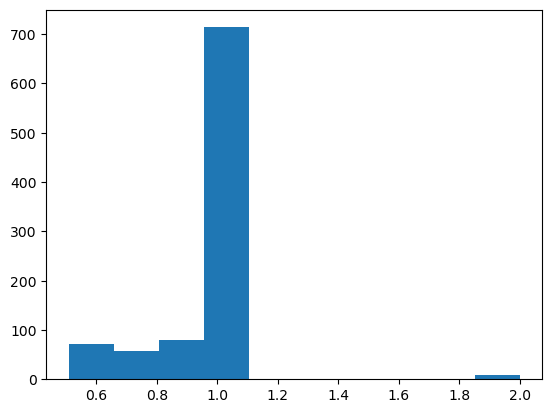

In [52]:
plt.hist(found[found['found'] > 0]['ratio'])
plt.show()

In [27]:
next(iter(Path("/epyc/projects/salad/search/tno_search").rglob("snr_[2-5].0/regular/tno_all")))

PosixPath('/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_1/snr_2.0/regular/tno_all')

In [9]:
astropy.table.join(fakes_info(read(fakes)), found(read(p / "gathered_match_line.pkl")), keys=['ORBITID'])

<Table length=10>
ORBITID           vra                   vdec         ... binary found ratio
                deg / d               deg / d        ...                   
 int64          float64               float64        ...  bool  int64 int64
-------- --------------------- --------------------- ... ------ ----- -----
 2405372  -0.01950935166310317  0.004005313270790564 ...  False    34     1
 3881210  -0.00918594583080613 0.0031365914998971365 ...  False    -1    -1
 4279478 -0.011176547258878494  0.005099762757632685 ...  False    98     1
 5962014 -0.013244086661610222  0.004038602096829615 ...  False    30     1
10041343  -0.29713809493156784  -0.09604963855455591 ...  False    -1    -1
10053463  -0.15100897047828574 0.0029864641685746636 ...  False    -1    -1
13039521  -0.14286354030928058 0.0033363187450130703 ...  False    -1    -1
13776855   -0.1256695303635021   0.18511983953004849 ...  False    -1    -1
14621325  -0.14885474993460884    0.1526942159246714 ...  False    -1    -1
14813564  -0.16369936876236016 -0.017466331230992248 ...  False    -1    -1

In [5]:
fakes = p.parent.parent.parent / "fakes.pkl"
read(fakes)

<Table length=1581>
         RA                 DEC         EXPNUM ...        MAG           type  
      float64             float64       int32  ...      float64         str8  
------------------- ------------------- ------ ... ------------------ --------
-143.72882910879343 -11.106944662458458 845872 ...  24.57391687931244      tno
 -143.7288624900713 -11.106937869665813 845873 ... 24.573916266268277      tno
  -143.728897146489 -11.106930816621732 845874 ...  24.57391563011338      tno
 -143.7289305288149 -11.106924022113985 845875 ... 24.573915017641063      tno
-143.72896397440036 -11.106917213968794 845876 ...  24.57391440429809      tno
-143.72899745526885 -11.106910397861132 845877 ... 24.573913790598304      tno
 -143.7290309373121 -11.106903580718491 845878 ... 24.573913177166727      tno
-143.72906456905224 -11.106896732280601 845879 ...  24.57391256128364      tno
-143.72909787304528 -11.106889949757942 845880 ...  24.57391195168931      tno
-143.72913137267156 -11.106883126550924 845881 ... 24.573911338801455      tno
                ...                 ...    ... ...                ...      ...
-143.81394355361405 -11.113200514319399 845974 ... 26.341978352828956 asteroid
 -144.0000463520077 -10.996342312724083 845974 ... 21.717001871971796 asteroid
-143.72719027744859  -11.13600887721796 845974 ...  26.04134904191994 asteroid
-144.00030124350656 -10.996078627330409 845975 ...  21.71673918637945 asteroid
-143.74824949656715 -11.038534414975945 845975 ... 25.500679917228886 asteroid
-143.81418832065023 -11.113194091129568 845975 ... 26.341121249691824 asteroid
-143.72739429473057 -11.135800622627773 845975 ... 26.041348351603315 asteroid
-143.81379639636933 -11.006286151621328 845975 ... 24.200577440823142 asteroid
-143.97144442609365 -10.991472802585331 845975 ... 23.770562631366126 asteroid
 -143.8131851239082   -11.0750001831737 845975 ...  22.42851848697325 asteroid

In [9]:
import re

def read_search(p):
    mem = re.compile(".*Maximum resident set size.*: (\d+)")
    user = re.compile(".*User time.*: (\d+.\d+)")
    system = re.compile(".*System time.*: (\d+.\d+)")
    
    search_start = re.compile(".*start projecting (\d+.\d+)")
    search_end = re.compile(".*end cluster (\d+.\d+)")
    
    n_dir = re.compile(".*projecting.*using (\d+) directions")
    hough = re.compile(".*creating hough space with shape \((\d+), (\d+), (\d+)\)")
    
    with open(p, "r") as f:
        lm = None
        lu = None
        ls = None
        l_search_start = None
        l_search_end = None
        l_n_dir = None
        l_hough = None
        for line in f:
            m = mem.match(line)
            if m:
                lm = int(m.groups()[0])
                continue

            m = user.match(line)
            if m:
                lu = float(m.groups()[0])
                continue

            m = system.match(line)
            if m:
                ls = float(m.groups()[0])
                continue

            m = search_start.match(line)
            if m:
                l_search_start = float(m.groups()[0])
                continue
                
            m = search_end.match(line)
            if m:
                l_search_end = float(m.groups()[0])
                continue
                
            m = n_dir.match(line)
            if m:
                l_n_dir = float(m.groups()[0])
                continue
                
            m = hough.match(line)
            if m:
                l_hough = np.product(list(map(float, m.groups())))
                continue
                
            if lm and lu and ls and l_search_start and l_search_end and l_n_dir:
                break
        return {
            "mem": lm if lm else np.nan,
            "user": lu if lu else np.nan,
            "system": ls if ls else np.nan,
            "start": l_search_start if l_search_start else np.nan,
            "end": l_search_end if l_search_end else np.nan,
            "n_dir": l_n_dir if l_n_dir else np.nan,
            "hough": l_hough if l_hough else np.nan,
        }


    
def get_usage(prefix):
    values = []
    for p in Path(prefix).rglob("search.stderr"):
        label = p.parent.name
        time_type = p.parent.parent.name
        snr = float(p.parent.parent.parent.name.split("_")[1])
        detector = int(p.parent.parent.parent.parent.name.split("_")[1])
        d = read_search(p)
        d.update({
            "label": label,
            "snr": snr,
            "detector": detector,
            "time": time_type,            
        })
        values.append(d)

    return astropy.table.Table(values)

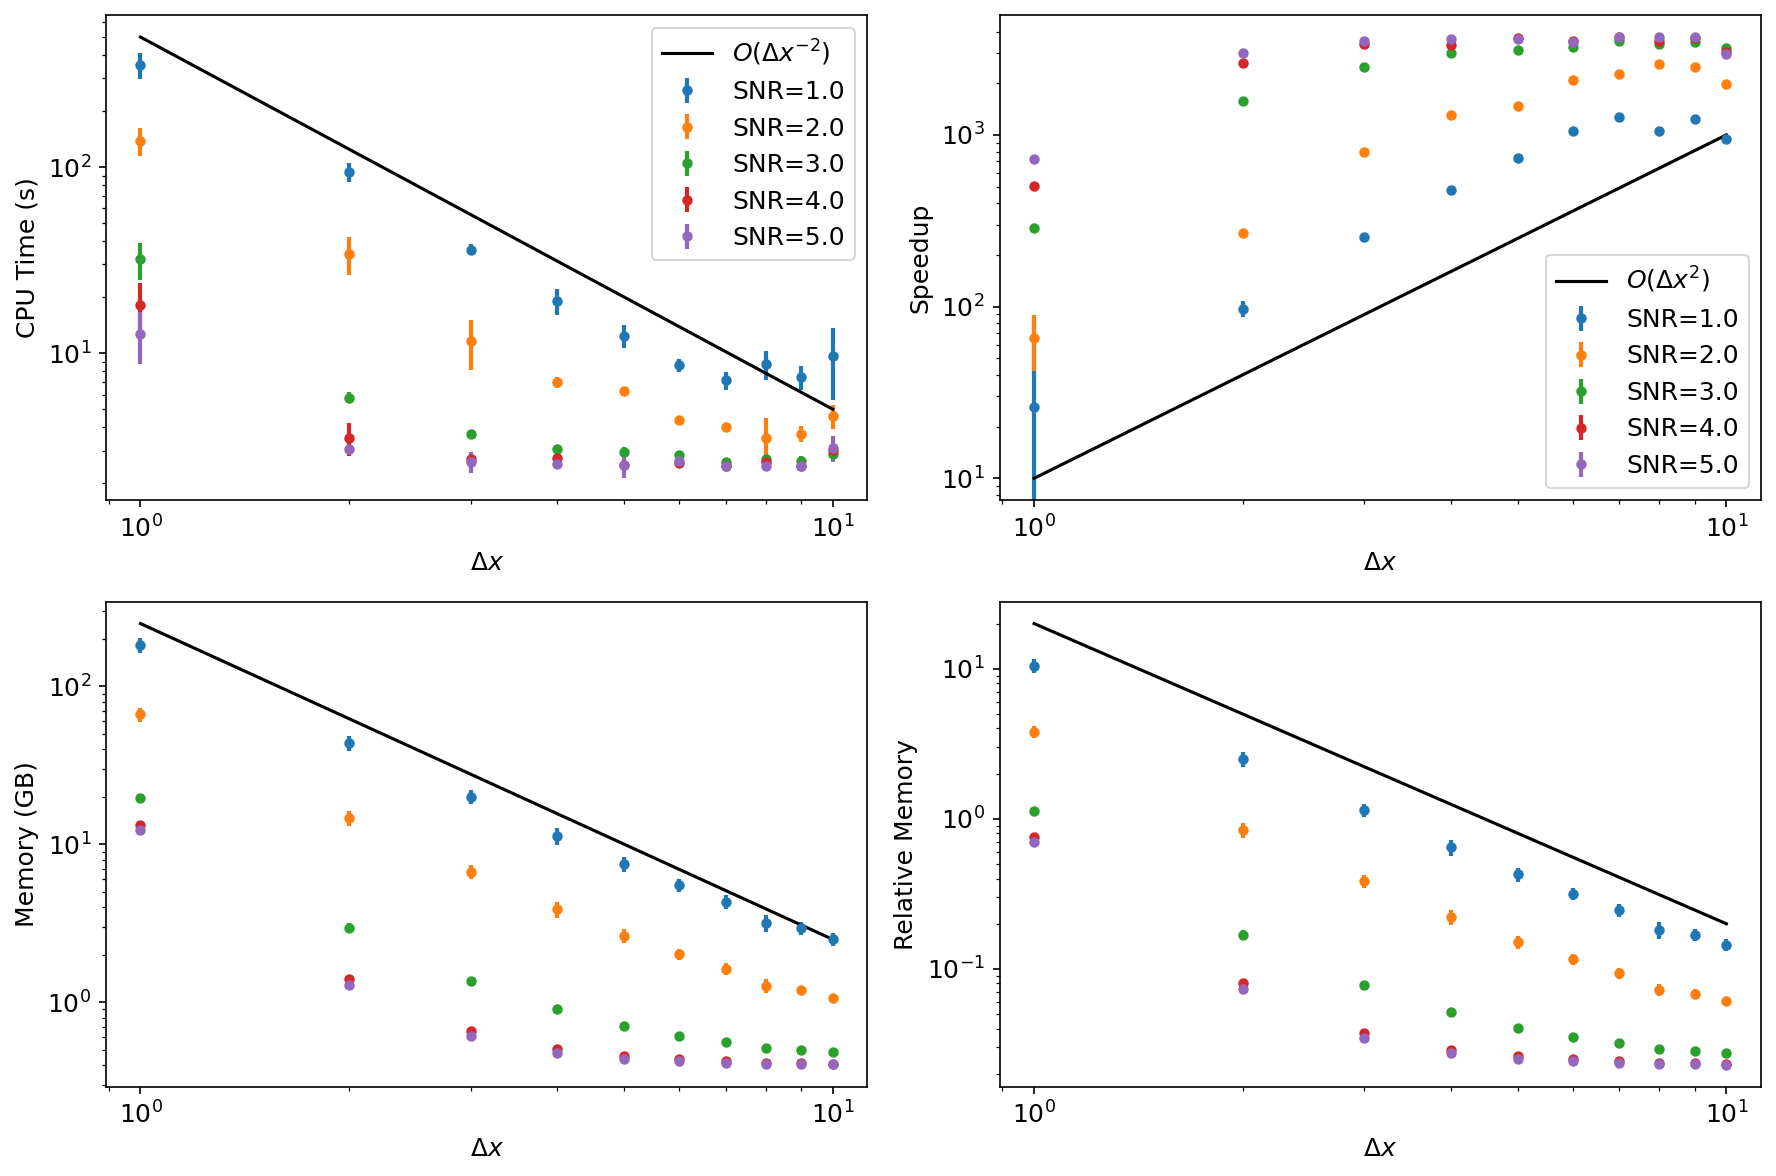

In [11]:
from glob import glob

kbmod_time = (9349.267453432083 - 202.79421305656433)
kbmod_mem = 18323264

usages = []
for p in glob("/epyc/projects/salad/search/tno_search/DEEP/20190403/A0c/detector_*/*/regular/tno_runtime_experiment*"):    
    usages.append(get_usage(p))
    
usages = astropy.table.vstack(usages)
usages['dx'] = list(map(lambda x : float(re.compile(".*_dx_(\d+)").match(x).groups()[0]), usages['label']))

fig = plt.figure(figsize=(12, 8))
axs = fig.subplots(2, 2)


for g in usages.group_by("snr").groups:
    x = []
    cpu = []
    cpu_err = []
    mem = []
    mem_err = []
    ndir = []
    ndir_err = []
    hough = []
    hough_err = []
    
    for d in g.group_by("dx").groups:
#         print(d)
        _x = d['dx']
        t = d['end'] - d['start']
        m = d['mem']
        n = d['n_dir']
        h = d['hough']
        
        if isinstance(d, astropy.table.Row):
            x.append(_x)
            cpu.append(t)
            cpu_err.append(0)
            mem.append(m)
            mem_err.append(0)
            ndir.append(n)
            ndir_err.append(0)
            hough.append(h)
            hough_err.append(0)
        else:
            x.append(_x[0])
            cpu.append(np.median(t))
            cpu_err.append(np.std(t))
            mem.append(np.median(m))
            mem_err.append(np.std(m))
            ndir.append(np.median(n))
            ndir_err.append(np.std(n))
            hough.append(np.median(h))
            hough_err.append(np.std(h))
        
    x = np.array(x)
    cpu = np.array(cpu)
    cpu_err = np.array(cpu_err)
    mem = np.array(mem)
    mem_err = np.array(mem_err)
    ndir = np.array(ndir)
    ndir_err = np.array(ndir_err)
    hough = np.array(hough)
    hough_err = np.array(hough_err)
    
#     print(x, y, yerr)
    plt.sca(axs[0, 0])
    plt.errorbar(x, cpu, yerr=cpu_err, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)
    plt.sca(axs[0, 1])
    plt.errorbar(x, kbmod_time/cpu, yerr=cpu_err, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)
    plt.sca(axs[1, 0])
    plt.errorbar(x, mem/2**20, yerr=mem_err/2**20, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)
    plt.sca(axs[1, 1])
    plt.errorbar(x, mem/kbmod_mem, yerr=mem_err/kbmod_mem, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)
#     plt.sca(axs[2, 0])
#     plt.errorbar(x, ndir, yerr=ndir_err, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)
#     plt.sca(axs[2, 1])
#     plt.errorbar(x, hough, yerr=hough_err, label=f'SNR={g[0]["snr"]}', fmt='o', ms=4, lw=2)

    
_x = np.linspace(1, 10, 100)
# plt.plot(_x, 50*  _x**4, color='k', label=r"$O(\Delta x^{4})$")
# plt.plot(_x, 100 * _x**3, color='k', ls='--', label=r"$O(\Delta x^{3})$")

plt.sca(axs[0, 0])

plt.plot(_x, 5e2 * _x**-2, color='k', label=r"$O(\Delta x^{-2})$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta x$")
plt.ylabel("CPU Time (s)")
plt.legend()
# plt.legend(loc='lower left')

plt.sca(axs[0, 1])
plt.plot(_x, 1e1 * _x**2, color='k', label=r"$O(\Delta x^{2})$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Speedup")
plt.legend()


plt.sca(axs[1, 0])
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Memory (GB)")
plt.plot(_x, 2.5e2 * _x**-2, color='k', label=r"$O(\Delta x^{-2})$")

plt.sca(axs[1, 1])

plt.plot(_x, 2e1 * _x**-2, color='k', label=r"$O(\Delta x^{-2})$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Relative Memory")
# plt.legend()


# plt.sca(axs[2, 0])
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel(r"$\Delta x$")
# plt.ylabel(r"$\vert \mathcal{V} \vert$")
# plt.plot(_x, 2e3 * _x**-2, color='k', label=r"$O(\Delta x^{-2})$")
# plt.legend()

# plt.sca(axs[2, 1])
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel(r"$\Delta x$")
# plt.ylabel(r"$\vert \mathcal{V} \vert \times \Omega / \Delta x^2$")
# plt.plot(_x, 2e9 * _x**-4, color='k', label=r"$O(\Delta x^{-4})$")
# plt.legend()

fig.tight_layout()
# plt.savefig("figures/cpu_mem_dx_scaling.pdf")
# plt.savefig("figures/cpu_mem_dx_scaling.png")
plt.show()

In [316]:
mem

array([12878560.,  1345680.,   637674.,   500990.,   461176.,   443590.,
         434756.,   427530.,   425732.,   423074.])

In [10]:
usage = get_usage()

TypeError: get_usage() missing 1 required positional argument: 'prefix'

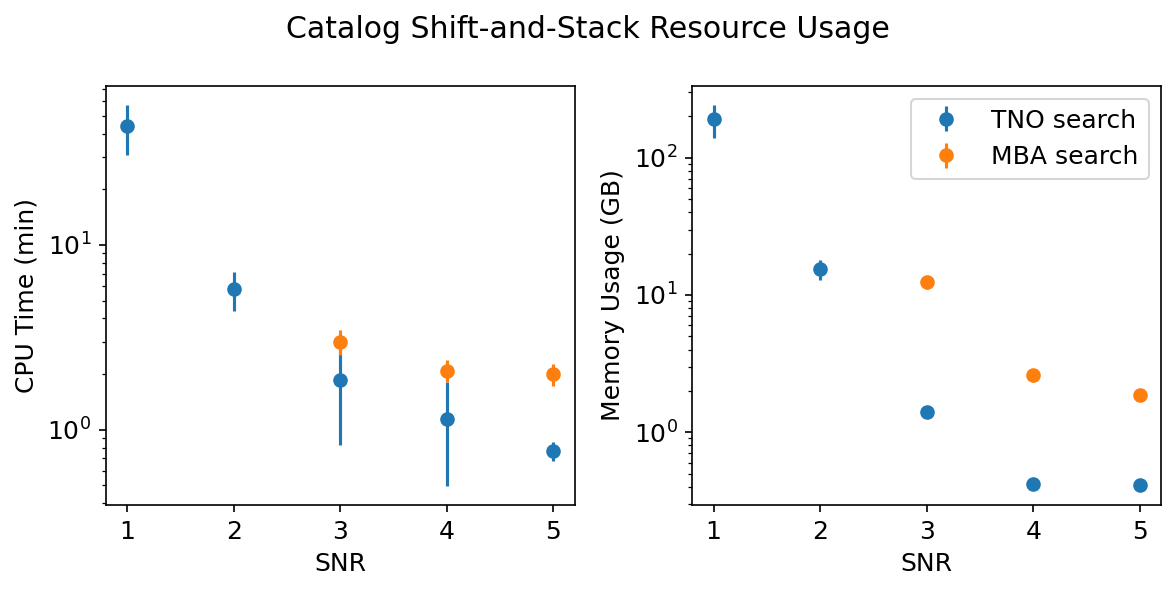

In [769]:
fig = plt.figure(figsize=[8, 4])
axs = np.atleast_1d(fig.subplots(1, 2)).flatten()

for l in ["tno_all", "ast_all"]:
    g1 = usage[(usage['time'] == "regular") & (usage['label'] == l)]
    l = g1[0]['label']
    if l not in ["ast_all", "tno_all"]:
        continue
    l_mem = []
    l_mem_err = []
    l_snr = []
    l_user = []
    l_system = []
    l_cpu = []
    l_cpu_err = []
    for g2 in g1.group_by("snr").groups:
        s = g2[0]['snr']
        if s == 0:
            continue
        mem = g2['mem']
        user = g2['user']
        system = g2['system']
        
        l_snr.append(s)
        l_mem.append(np.median(mem))
        l_mem_err.append(np.std(mem))
        l_user.append(np.median(user))
        l_system.append(np.median(system))
        l_cpu.append(np.median(user + system))
        l_cpu_err.append(np.std(user + system))

    plt.sca(axs[1])
    plt.errorbar(
        l_snr, np.array(l_mem)/2**20, 
        yerr=np.array(l_mem_err)/2**20,
        label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search",
        fmt='o',
    )
    plt.sca(axs[0])
    plt.errorbar(
        l_snr, (np.array(l_cpu)) / 60, 
        yerr=(np.array(l_cpu_err)) / 60, 
        label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search",
        fmt='o',
    )
#     plt.sca(axs[2])
#     plt.scatter(l_snr, np.array(l_system), label=f'{l}')

plt.sca(axs[1])
plt.yscale("log")
plt.legend()
plt.xticks(np.arange(1, 6))
plt.xlabel("SNR")
plt.ylabel("Memory Usage (GB)")

plt.sca(axs[0])
plt.yscale("log")
plt.xticks(np.arange(1, 6))
plt.xlabel("SNR")
plt.ylabel("CPU Time (min)")

# plt.sca(axs[2])
# plt.yscale("log")
# plt.xticks(l_snr)
# plt.xlabel("SNR")
# plt.ylabel("System Time (min)")

fig.suptitle("Catalog Shift-and-Stack Resource Usage")
plt.tight_layout()
plt.savefig("figures/cpu_and_mem.pdf")
plt.savefig("figures/cpu_and_mem.png")
plt.show()

tno 1.0 16
tno 2.0 20
tno 3.0 18
tno 4.0 12
tno 5.0 9


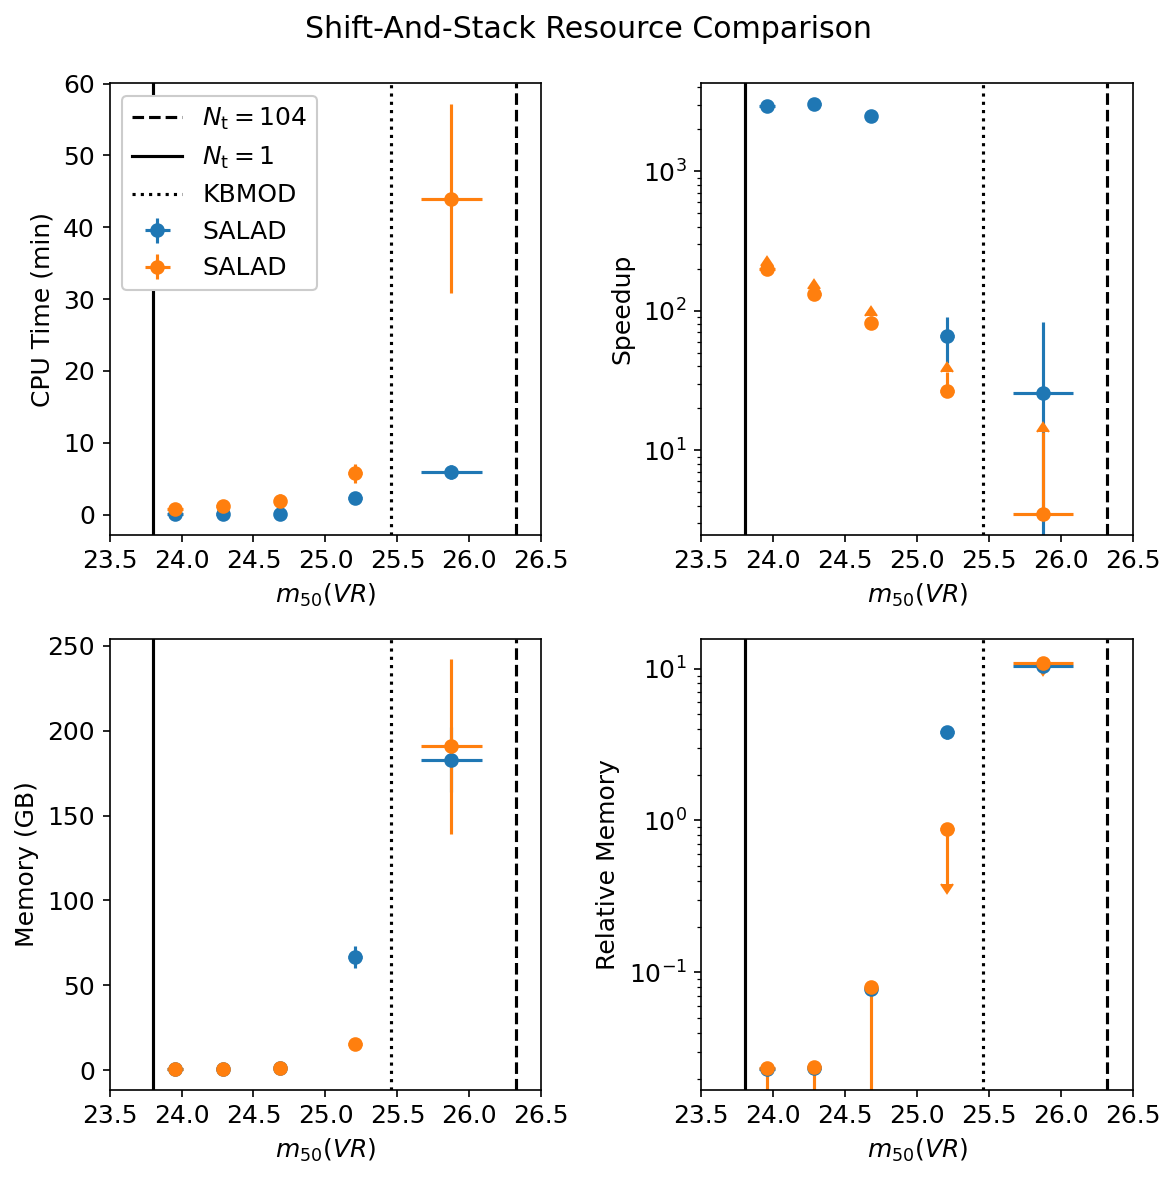

In [522]:
salad_results_snr = []
salad_results_cpu = []
salad_results_cpu_err = []
salad_results_mem = []
salad_results_mem_err = []
g1 = usage[(usage['time'] == "regular") & (usage['label'] == 'tno_all')]
for g2 in g1.group_by("snr").groups:
    s = g2[0]['snr']
    if s == 0:
        continue
    mem = g2['mem']
    user = g2['user']
    system = g2['system']

    salad_results_snr.append(s)
    salad_results_cpu.append(np.median(user + system))
    salad_results_cpu_err.append(np.std(user + system))
    salad_results_mem.append(np.median(mem))
    salad_results_mem_err.append(np.std(mem))

salad_results_snr = np.array(salad_results_snr)
salad_results_cpu = np.array(salad_results_cpu)[np.argsort(salad_results_snr)]
salad_results_cpu_err = np.array(salad_results_cpu_err)[np.argsort(salad_results_snr)]
salad_results_mem = np.array(salad_results_mem)[np.argsort(salad_results_snr)]
salad_results_mem_err = np.array(salad_results_mem_err)[np.argsort(salad_results_snr)]

salad_snr = []
salad_cpu = []
salad_cpu_err = []
salad_mem = []
salad_mem_err = []

for dx, snr in zip([1, 1, 3, 10, 10], [1, 2, 3, 4, 5]):
    t = usages[(usages['snr'] == snr) & (usages['dx'] == dx)]
    cpu = np.median(t['end'] - t['start'])
    cpu_err = np.std(t['end'] - t['start'])
    mem = np.median(t['mem'])
    mem_err = np.std(t['mem'])
    salad_snr.append(snr)
    salad_cpu.append(cpu)
    salad_cpu_err.append(cpu_err)
    salad_mem.append(mem)
    salad_mem_err.append(mem_err)
    
salad_snr = np.array(salad_snr)
salad_cpu = np.array(salad_cpu)[np.argsort(salad_snr)]
salad_cpu_err = np.array(salad_cpu_err)[np.argsort(salad_snr)]
salad_mem = np.array(salad_mem)[np.argsort(salad_snr)]
salad_mem_err = np.array(salad_mem_err)[np.argsort(salad_snr)]

n = 2e2
t = 'tno'
_x = []
_y = []
_y_err = []

for snr in roc_lookup[t]:
    if snr == 0:
        continue
    if t == "ast":
        j = joined_ast
    else:
        j = joined_tno
    n_detectors = len(set(j[j['snr'] == snr]['detector']))
    N_results = int(n) * n_detectors

    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    print(t, snr, closest)
    fpr = n_fakes_found / N_results
    _x.append(snr)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])


salad_m_50 = np.array(_y)[np.argsort(_x)]
salad_m_50_err = np.array(_y_err)[np.argsort(_x)]

# fig = plt.figure(figsize=[8, 4])
# axs = np.atleast_1d(fig.subplots(1, 2)).flatten()
# plt.sca(axs[0])
# plt.scatter(np.array(l_mem)/2**20, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("Memory (GB)")

# plt.xscale("log")
# plt.sca(axs[1])
# plt.scatter(np.array(l_user) / 60, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("CPU Time (min)")

# plt.xscale("log")
# plt.show()


fig = plt.figure(dpi=150, figsize=[8, 8])
axs = np.atleast_1d(fig.subplots(2, 2)).flatten()

plt.sca(axs[0])
plt.errorbar(
    salad_m_50, 
    salad_cpu / 60, 
    xerr=salad_m_50_err,
    yerr=salad_cpu_err/60,
    label="SALAD",
    marker='o',
    linestyle='none'
)
plt.errorbar(
    salad_m_50, 
    salad_results_cpu / 60, 
    xerr=salad_m_50_err,
    yerr=salad_results_cpu_err/60,
    label="SALAD",
    marker='o',
    linestyle='none'
)

plt.ylabel("CPU Time (min)")
plt.xlabel(r"$m_{50} (VR)$")

# plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="$N_{\mathrm{t}} = 104$")
plt.axvline(mag_ref, color='k', ls='-', label=r"$N_{\mathrm{t}} = 1$")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
# plt.axhline((9349.267453432083-202.79421305656433)/60, color='k', ls=":", label="KBMOD")

legend = plt.legend(loc='upper left', facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))

plt.sca(axs[1])

plt.errorbar(
    salad_m_50, 
    sns_cpu / salad_cpu, 
    xerr=salad_m_50_err,
    yerr=salad_cpu_err,
#     lolims=np.array([1 for i in range(len(l_user))], dtype=bool),
    label="SALAD",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.errorbar(
    _y, 
    sns_cpu / np.array(salad_results_cpu), 
#     xerr=None,
    yerr=10*np.ones_like(salad_results_cpu),
    lolims=np.array([1 for i in range(len(salad_results_cpu))], dtype=bool),
    xerr=_y_err,
    label="SALAD",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.ylabel("Speedup")
plt.xlabel(r"$m_{50} (VR)$")
plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="$N_{\mathrm{t}} = 104$")
plt.axvline(mag_ref, color='k', ls='-', label=r"$N_{\mathrm{t}} = 1$")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])

plt.sca(axs[2])

plt.errorbar(
    salad_m_50, 
    salad_mem/2**20,  
    xerr=salad_m_50_err,
    yerr=salad_mem_err/2**20,
    label="SALAD",
    marker='o',
    linestyle='none'
)
plt.errorbar(
    salad_m_50, 
    salad_results_mem/2**20,  
    xerr=salad_m_50_err,
    yerr=salad_results_mem_err/2**20,
    label="SALAD",
    marker='o',
    linestyle='none'
)

plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Memory (GB)")
# plt.yscale("log")

plt.sca(axs[3])

plt.errorbar(
    salad_m_50, 
    (salad_mem / 2**20) / sns_mem, 
    xerr=salad_m_50_err,
    yerr=salad_mem_err / 2**20 / sns_mem,
    label="SALAD",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.errorbar(
    salad_m_50, 
    (np.array(salad_results_mem) / 2**20) / sns_mem, 
    yerr=0.5*np.ones_like(salad_results_mem),
    uplims=0.5*np.ones_like(salad_results_mem).astype(bool),
    xerr=_y_err,
    label="SALAD",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Relative Memory")
plt.yscale("log")
# plt.legend()



fig.suptitle("Shift-And-Stack Resource Comparison")
fig.tight_layout()

# plt.savefig("figures/sns_comparison.pdf")
# plt.savefig("figures/sns_comparison.png")
plt.show()

In [1]:
salad_results_snr = []
salad_results_cpu = []
salad_results_cpu_err = []
salad_results_mem = []
salad_results_mem_err = []
g1 = usage[(usage['time'] == "regular") & (usage['label'] == 'tno_all')]
for g2 in g1.group_by("snr").groups:
    s = g2[0]['snr']
    if s == 0:
        continue
    mem = g2['mem']
    user = g2['user']
    system = g2['system']

    salad_results_snr.append(s)
    salad_results_cpu.append(np.median(user + system))
    salad_results_cpu_err.append(np.std(user + system))
    salad_results_mem.append(np.median(mem))
    salad_results_mem_err.append(np.std(mem))

salad_results_snr = np.array(salad_results_snr)
salad_results_cpu = np.array(salad_results_cpu)[np.argsort(salad_results_snr)]
salad_results_cpu_err = np.array(salad_results_cpu_err)[np.argsort(salad_results_snr)]
salad_results_mem = np.array(salad_results_mem)[np.argsort(salad_results_snr)]
salad_results_mem_err = np.array(salad_results_mem_err)[np.argsort(salad_results_snr)]

salad_snr = []
salad_cpu = []
salad_cpu_err = []
salad_mem = []
salad_mem_err = []

for dx, snr in zip([1, 1, 3, 10, 10], [1, 2, 3, 4, 5]):
    t = usages[(usages['snr'] == snr) & (usages['dx'] == dx)]
    cpu = np.median(t['end'] - t['start'])
    cpu_err = np.std(t['end'] - t['start'])
    mem = np.median(t['mem'])
    mem_err = np.std(t['mem'])
    salad_snr.append(snr)
    salad_cpu.append(cpu)
    salad_cpu_err.append(cpu_err)
    salad_mem.append(mem)
    salad_mem_err.append(mem_err)
    
salad_snr = np.array(salad_snr)
salad_cpu = np.array(salad_cpu)[np.argsort(salad_snr)]
salad_cpu_err = np.array(salad_cpu_err)[np.argsort(salad_snr)]
salad_mem = np.array(salad_mem)[np.argsort(salad_snr)]
salad_mem_err = np.array(salad_mem_err)[np.argsort(salad_snr)]

n = 2e2
t = 'tno'
_x = []
_y = []
_y_err = []

for snr in roc_lookup[t]:
    if snr == 0:
        continue
    if t == "ast":
        j = joined_ast
    else:
        j = joined_tno
    n_detectors = len(set(j[j['snr'] == snr]['detector']))
    N_results = int(n) * n_detectors

    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    print(t, snr, closest)
    fpr = n_fakes_found / N_results
    _x.append(snr)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])


salad_m_50 = np.array(_y)[np.argsort(_x)]
salad_m_50_err = np.array(_y_err)[np.argsort(_x)]

# fig = plt.figure(figsize=[8, 4])
# axs = np.atleast_1d(fig.subplots(1, 2)).flatten()
# plt.sca(axs[0])
# plt.scatter(np.array(l_mem)/2**20, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("Memory (GB)")

# plt.xscale("log")
# plt.sca(axs[1])
# plt.scatter(np.array(l_user) / 60, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("CPU Time (min)")

# plt.xscale("log")
# plt.show()


fig = plt.figure(dpi=150, figsize=[8, 8])
axs = np.atleast_1d(fig.subplots(2, 2)).flatten()

plt.sca(axs[0])
# plt.errorbar(
#     salad_m_50, 
#     salad_cpu / 60, 
#     xerr=salad_m_50_err,
#     yerr=salad_cpu_err/60,
#     label="SALAD",
#     marker='o',
#     linestyle='none'
# )
plt.errorbar(
    salad_m_50, 
    salad_results_cpu / 60, 
    xerr=salad_m_50_err,
    yerr=salad_results_cpu_err/60,
    label="Search",
    marker='o',
    linestyle='none'
)

plt.ylabel("CPU Time (min)")
plt.xlabel(r"$m_{50} (VR)$")

# plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="$N_{\mathrm{t}} = 104$")
plt.axvline(mag_ref, color='k', ls='-', label=r"$N_{\mathrm{t}} = 1$")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
# plt.axhline((9349.267453432083-202.79421305656433)/60, color='k', ls=":", label="KBMOD")

legend = plt.legend(loc='upper left', facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))

plt.sca(axs[1])

# plt.errorbar(
#     salad_m_50, 
#     sns_cpu / salad_cpu, 
#     xerr=salad_m_50_err,
#     yerr=salad_cpu_err,
# #     lolims=np.array([1 for i in range(len(l_user))], dtype=bool),
#     label="SALAD",
#     marker='o',
#     linestyle='none'
# #     label="SALAD"
# )

plt.errorbar(
    _y, 
    sns_cpu / np.array(salad_results_cpu), 
#     xerr=None,
    yerr=10*np.ones_like(salad_results_cpu),
    lolims=np.array([1 for i in range(len(salad_results_cpu))], dtype=bool),
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.ylabel("Speedup")
plt.xlabel(r"$m_{50} (VR)$")
# plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="$N_{\mathrm{t}} = 104$")
plt.axvline(mag_ref, color='k', ls='-', label=r"$N_{\mathrm{t}} = 1$")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])

plt.sca(axs[2])

# plt.errorbar(
#     salad_m_50, 
#     salad_mem/2**20,  
#     xerr=salad_m_50_err,
#     yerr=salad_mem_err/2**20,
#     label="SALAD",
#     marker='o',
#     linestyle='none'
# )
plt.errorbar(
    salad_m_50, 
    salad_results_mem/2**20,  
    xerr=salad_m_50_err,
    yerr=salad_results_mem_err/2**20,
    label="Search",
    marker='o',
    linestyle='none'
)

plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Memory (GB)")
# plt.yscale("log")

plt.sca(axs[3])

# plt.errorbar(
#     salad_m_50, 
#     (salad_mem / 2**20) / sns_mem, 
#     xerr=salad_m_50_err,
#     yerr=salad_mem_err / 2**20 / sns_mem,
#     label="SALAD",
#     marker='o',
#     linestyle='none'
# #     label="SALAD"
# )

plt.errorbar(
    salad_m_50, 
    (np.array(salad_results_mem) / 2**20) / sns_mem, 
    yerr=0.5*np.ones_like(salad_results_mem),
    uplims=0.5*np.ones_like(salad_results_mem).astype(bool),
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
#     label="SALAD"
)

plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Relative Memory")
# plt.yscale("log")
# plt.legend()

fig.suptitle("Shift-And-Stack Resource Comparison")
fig.tight_layout()

# plt.savefig("figures/sns_comparison.pdf")
# plt.savefig("figures/sns_comparison.png")
plt.show()

NameError: name 'usage' is not defined

tno 1.0 16
tno 2.0 20
tno 3.0 18
tno 4.0 12
tno 5.0 9


ValueError: 'x' and 'y' must have the same size

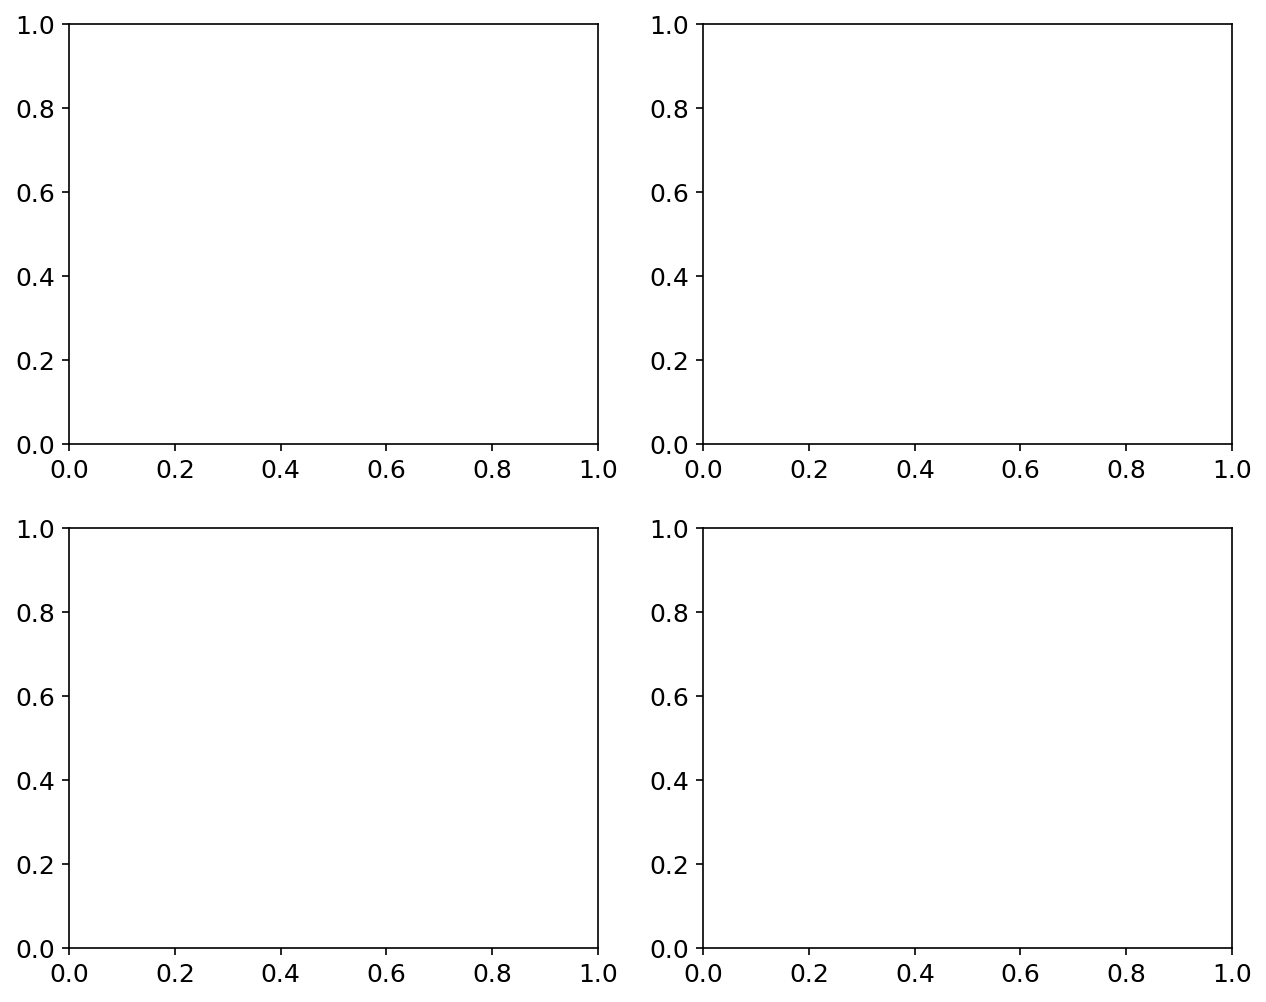

In [685]:

n = 2e2
t = 'tno'
_x = []
_y = []
_y_err = []

for snr in roc_lookup[t]:
    if snr == 0:
        continue
    if t == "ast":
        j = joined_ast
    else:
        j = joined_tno
    n_detectors = len(set(j[j['snr'] == snr]['detector']))
    N_results = int(n) * n_detectors

    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    print(t, snr, closest)
    fpr = n_fakes_found / N_results
    _x.append(snr)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])

# fig = plt.figure(figsize=[8, 4])
# axs = np.atleast_1d(fig.subplots(1, 2)).flatten()
# plt.sca(axs[0])
# plt.scatter(np.array(l_mem)/2**20, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("Memory (GB)")

# plt.xscale("log")
# plt.sca(axs[1])
# plt.scatter(np.array(l_user) / 60, _y)
# plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
# plt.xlabel("CPU Time (min)")

# plt.xscale("log")
# plt.show()


fig = plt.figure(dpi=150, figsize=[10, 8])
axs = np.atleast_1d(fig.subplots(2, 2)).flatten()

plt.sca(axs[0])
plt.errorbar(
    _y, 
    np.array(l_user) / 60, 
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
)
plt.ylabel("CPU Time (min)")
plt.xlabel(r"$m_{50} (VR)$")

# plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="Acheivable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch\nLimiting Magnitude")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
# plt.axhline((9349.267453432083-202.79421305656433)/60, color='k', ls=":", label="KBMOD")

legend = plt.legend(loc='upper left', ncols=1, facecolor='white')
# legend = fig.legend(bbox_to_anchor=[0.4, -0.1, 1, 1], ncols=1, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))


plt.sca(axs[1])

plt.errorbar(
    _y, 
    sns_cpu / np.array(l_user), 
#     xerr=None,
    yerr=10*np.ones_like(l_user),
    lolims=np.array([1 for i in range(len(l_user))], dtype=bool),
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
#     label="SALAD"
)
plt.ylabel("Speedup")
plt.xlabel(r"$m_{50} (VR)$")
# plt.yscale("log")
plt.axvline(expected, color='k', ls='--', label="Acheivable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch\nLimiting Magnitude")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])


plt.sca(axs[2])

plt.errorbar(
    _y, 
    np.array(l_mem)/2**20, 
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
)
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Memory (GB)")
# plt.yscale("log")

plt.sca(axs[3])

plt.errorbar(
    _y, 
    (np.array(l_mem) / 2**20) / sns_mem, 
    yerr=0.5*np.ones_like(l_user),
    uplims=0.5*np.ones_like(l_user).astype(bool),
    xerr=_y_err,
    label="Search",
    marker='o',
    linestyle='none'
#     label="SALAD"
)
plt.xticks([23.5, 24, 24.5, 25, 25.5, 26, 26.5])
plt.axvline(expected, color='k', ls='--', label="Achievable Depth")
plt.axvline(mag_ref, color='k', ls='-', label="Single Epoch Depth")
plt.axvline(kbmod_result['fit']['m_50'], color='k', ls=":", label="KBMOD")
plt.xlabel(r"$m_{50} (VR)$")
plt.ylabel("Relative Memory")
# plt.yscale("log")
# plt.legend()

fig.suptitle("Shift-And-Stack Resource Comparison")
fig.tight_layout()

# plt.savefig("figures/sns_comparison.pdf", bbox_inches='tight')
# plt.savefig("figures/sns_comparison.png")
plt.show()

In [463]:
(9349.267453432083-202.79421305656433) / 60 / 60

2.540687011215422

In [468]:
_y - np.array(kbmod_result['fit']['m_50'])

array([ 0.41723944, -0.24935882, -0.77428797, -1.17073643, -1.50076665])

In [493]:
sns_cpu / 60 / 60

2.5406870148422454

In [494]:
l_user

[2369.0, 297.0, 106.5, 66.0, 45.0]

In [690]:
sns_m50 = kbmod_result['fit']['m_50']
sns_sigma_m50 = kbmod_result['fit']['sigma_m_50']

for i, (m_50, sigma_m_50, cpu, mem) in enumerate(zip(_y, _y_err, l_user, l_mem)):
    s = sns_cpu / cpu
    r = mem / sns_mem
    print(f"""{i+1} & ${m_50:0.2f} \pm {sigma_m_50:0.2f}$ & {cpu/60:0.1f} & {mem/2**20:0.1f} & $\\geq$ {s:0.1f} & $\\leq$ {r/2**20:0.2f} & ${m_50 - sns_m50:0.2f} \pm {(sigma_m_50**2 + sns_sigma_m50**2)**0.5:0.2f}$""", end="")
    if i < 4:
        print(" \\\\ \hline")
    else:
        print("")
#     print(m_50, sigma_m_50, cpu, mem)
# _y_err

1 & $25.87 \pm 0.21$ & 39.5 & 190.8 & $\geq$ 3.9 & $\leq$ 10.92 & $0.42 \pm 0.21$ \\ \hline
2 & $25.21 \pm 0.05$ & 5.0 & 15.4 & $\geq$ 30.8 & $\leq$ 0.88 & $-0.25 \pm 0.05$ \\ \hline
3 & $24.68 \pm 0.04$ & 1.8 & 1.4 & $\geq$ 85.9 & $\leq$ 0.08 & $-0.77 \pm 0.04$ \\ \hline
4 & $24.29 \pm 0.05$ & 1.1 & 0.4 & $\geq$ 138.6 & $\leq$ 0.02 & $-1.17 \pm 0.05$ \\ \hline
5 & $23.96 \pm 0.06$ & 0.8 & 0.4 & $\geq$ 203.3 & $\leq$ 0.02 & $-1.50 \pm 0.06$


In [464]:
sns_cpu / np.array(l_user)

array([  3.86090049,  30.79620624,  85.88237797, 138.58292808,
       203.25496119])

In [466]:
(np.array(l_mem) / 2**20) / sns_mem

array([10.91964347,  0.88213061,  0.08061435,  0.02388832,  0.02357921])

In [449]:
kbmod_result['fit']

{'c': 0.9337558694755008,
 'k': 1.6155916626198876,
 'm_50': 25.456359434396326,
 'sigma_c': 0.0027025522988996433,
 'sigma_k': 0.018616425624865682,
 'sigma_m_50': 0.00781360056071236}

In [450]:
kbmod_result['fit']['m_50'], kbmod_result['fit']['sigma_m_50']

(25.456359434396326, 0.00781360056071236)

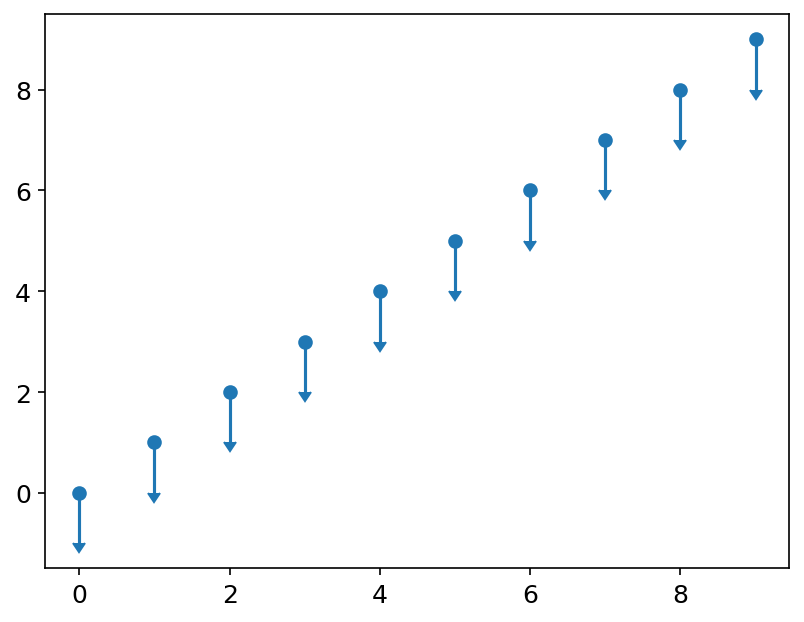

In [418]:
x = np.arange(10)
y = np.arange(10)
yerr = np.ones_like(y)
uplims = np.ones_like(x).astype(bool)
plt.errorbar(x, y, yerr=yerr, uplims=uplims, marker='o', linestyle='none')
plt.show()

In [354]:
kbmod_result['fit']['m_50']

25.456359434396326

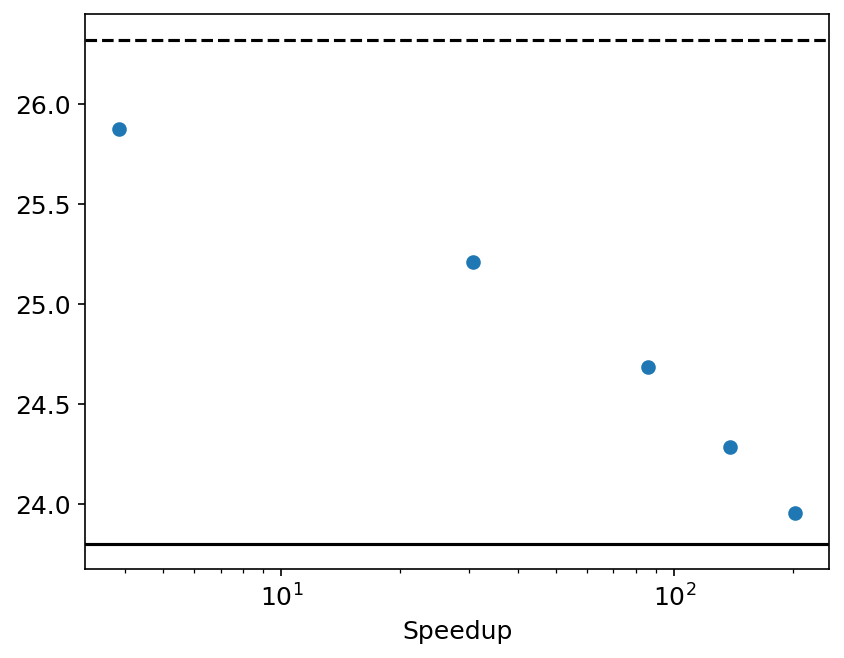

In [332]:
plt.scatter(sns_cpu / np.array(l_user), _y)
plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
plt.xlabel("Speedup")

plt.axhline(expected, color='k', ls='--', label="Achievable Depth")
plt.axhline(mag_ref, color='k', ls='-', label="Single Epoch Limiting Magnitude")

plt.xscale("log")
plt.show()

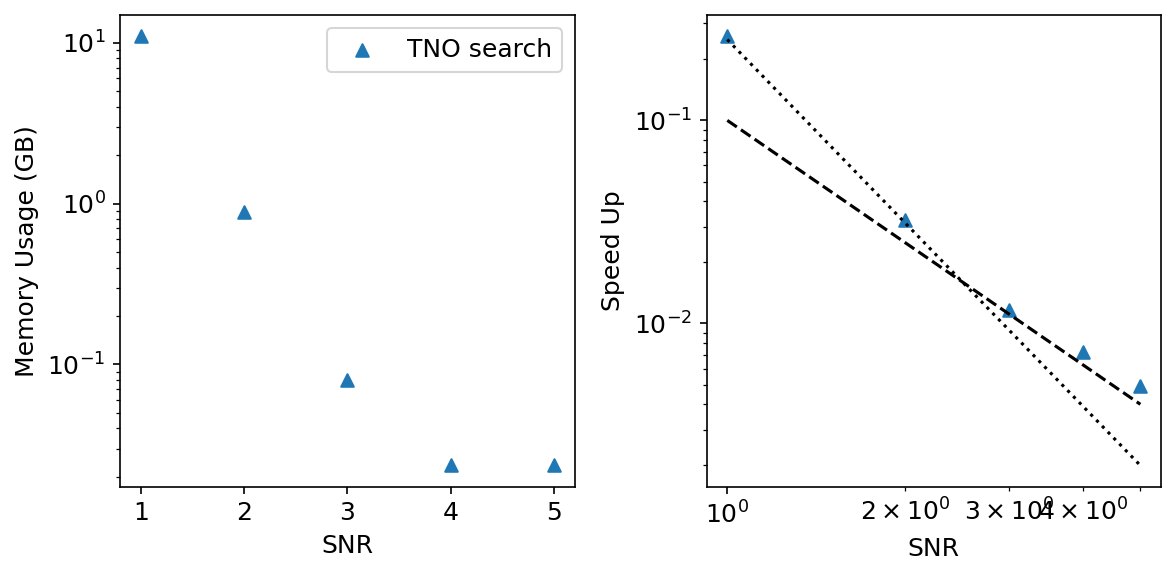

In [689]:
fig = plt.figure(figsize=[8, 4])
axs = np.atleast_1d(fig.subplots(1, 2)).flatten()

sns_cpu = 9349.267453432083-202.7942
sns_mem = 18323264 / 2**20

for g1 in usage[usage['time'] == "regular"].group_by("label").groups:
    l = g1[0]['label']
    if l not in ["tno_all"]:
        continue
    l_mem = []
    l_snr = []
    l_user = []
    l_system = []
    for g2 in g1.group_by("snr").groups:
        s = g2[0]['snr']
        if s == 0:
            continue
        mem = g2['mem']
        user = g2['user']
        system = g2['system']
        
        l_snr.append(s)
        l_mem.append(np.median(mem))
        l_user.append(np.median(user))
        l_system.append(np.median(system))

    plt.sca(axs[0])
    plt.scatter(l_snr, (np.array(l_mem)/2**20)/sns_mem, marker="^", label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search")
    plt.sca(axs[1])
    plt.scatter(l_snr, np.array(l_user)/sns_cpu, marker="^", label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search")
#     plt.sca(axs[2])
#     plt.scatter(l_snr, np.array(l_system), label=f'{l}')

plt.sca(axs[0])
plt.yscale("log")
plt.legend()
plt.xticks(l_snr)
plt.xlabel("SNR")
plt.ylabel("Memory Usage (GB)")

plt.sca(axs[1])
plt.yscale("log")
plt.xscale("log")
# plt.xticks(l_snr)
plt.xlabel("SNR")
plt.ylabel("Speed Up")
# plt.plot(l_snr, list(map(lambda x : 0.5 * x**-4, l_snr)))
plt.plot(l_snr, list(map(lambda x : 0.25 * x**-3, l_snr)), color='k', ls=":")
plt.plot(l_snr, list(map(lambda x : 0.1 * x**-2, l_snr)), color='k', ls='--')

# plt.sca(axs[2])
# plt.yscale("log")
# plt.xticks(l_snr)
# plt.xlabel("SNR")
# plt.ylabel("System Time (min)")

plt.tight_layout()
# plt.savefig("figures/cpu_and_mem.pdf")
# plt.savefig("figures/cpu_and_mem.png")
plt.show()

tno 1.0 16
tno 2.0 20
tno 3.0 18
tno 4.0 12
tno 5.0 9


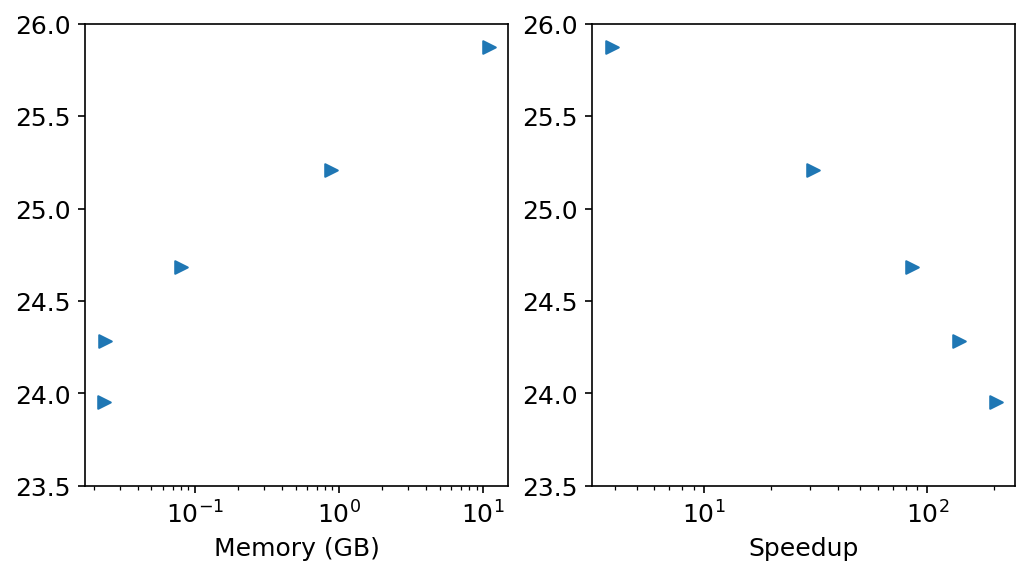

In [326]:
n = 2e2
t = 'tno'
_x = []
_y = []
_y_err = []

for snr in roc_lookup[t]:
    if snr == 0:
        continue
    if t == "ast":
        j = joined_ast
    else:
        j = joined_tno
    n_detectors = len(set(j[j['snr'] == snr]['detector']))
    N_results = int(n) * n_detectors

    x, fit_results, n_fakes, n_fakes_found, n_results = roc_lookup[t][snr]
    m_50 = np.array([f['m_50'] for f in fit_results])
    m_50_err = np.array([f['sigma_m_50'] for f in fit_results])
    closest = np.argmin(np.abs(np.array(n_results) - N_results))
    print(t, snr, closest)
    fpr = n_fakes_found / N_results
    _x.append(snr)
    _y.append(m_50[closest])
    _y_err.append(m_50_err[closest])


fig = plt.figure(figsize=[8, 4])
axs = np.atleast_1d(fig.subplots(1, 2)).flatten()
plt.sca(axs[0])
plt.scatter((np.array(l_mem)/2**20)/sns_mem, _y, marker='>')
plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
plt.xlabel("Memory (GB)")

plt.xscale("log")
plt.sca(axs[1])
plt.scatter((sns_cpu / np.array(l_user)), _y, marker=">")
plt.yticks([23.5, 24, 24.5, 25, 25.5, 26])
plt.xlabel("Speedup")

plt.xscale("log")
plt.show()

In [ ]:
# fig = plt.figure(figsize=[8, 4])
# axs = np.atleast_1d(fig.subplots(1, 2)).flatten()

# for g1 in usage[usage['time'] == "regular"].group_by("label").groups:
#     l = g1[0]['label']
#     if l == "ast_all.bak":
#         continue
#     l_mem = []
#     l_snr = []
#     l_user = []
#     l_system = []
#     for g2 in g1.group_by("snr").groups:
#         s = g2[0]['snr']
#         if s == 0:
#             continue
#         mem = g2['mem']
#         user = g2['user']
#         system = g2['system']
        
#         l_snr.append(s)
#         l_mem.append(np.median(mem))
#         l_user.append(np.median(user))
#         l_system.append(np.median(system))

#     plt.sca(axs[0])
#     plt.scatter(l_snr, np.array(l_mem)/2**20, label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search")
#     plt.sca(axs[1])
#     plt.scatter(l_snr, np.array(l_user) / 60, label={"tno_all": "TNO", "ast_all": "MBA"}.get(l) + " search")
# #     plt.sca(axs[2])
# #     plt.scatter(l_snr, np.array(l_system), label=f'{l}')

# plt.sca(axs[0])
# plt.yscale("log")
# plt.legend()
# plt.xticks(l_snr)
# plt.xlabel("SNR")
# plt.ylabel("Memory Usage (GB)")

# plt.sca(axs[1])
# plt.yscale("log")
# plt.xticks(l_snr)
# plt.xlabel("SNR")
# plt.ylabel("User Time (min)")

# # plt.sca(axs[2])
# # plt.yscale("log")
# # plt.xticks(l_snr)
# # plt.xlabel("SNR")
# # plt.ylabel("System Time (min)")

# plt.tight_layout()
# # plt.savefig("figures/cpu_and_mem.pdf")
# # plt.savefig("figures/cpu_and_mem.png")
# plt.show()

In [702]:
clusters = read(next(iter(Path("/epyc/projects/salad/search/tno_search").rglob("snr_3.0/regular/" + "ast_all"))) / "clusters.pkl")

In [706]:
from salad.regression import regression

[216.05541403 -11.07058663] [216.08752933 -11.06385313]


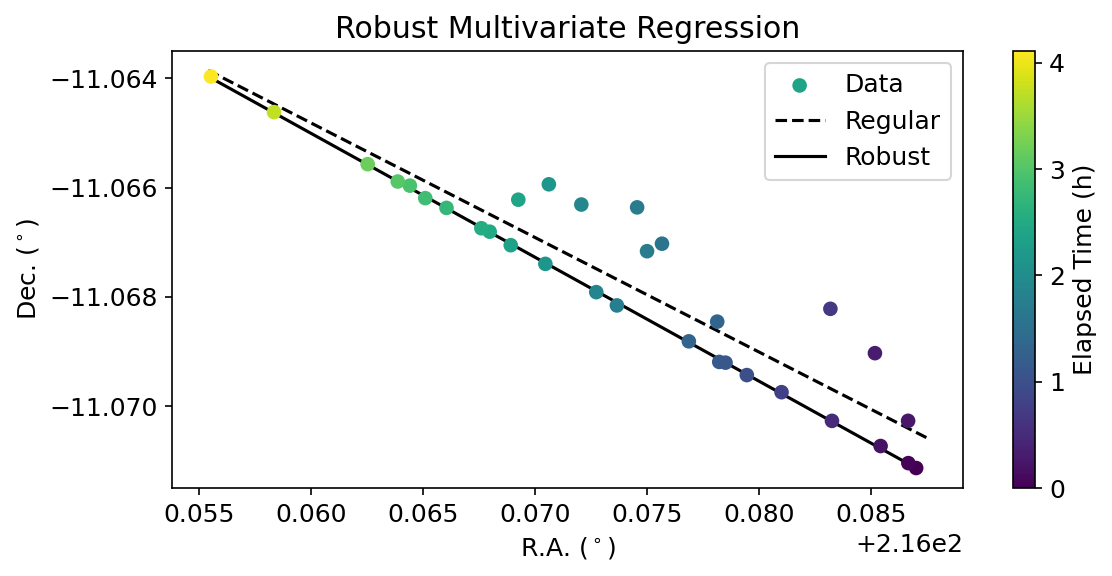

In [760]:
# for k, cluster in clusters.items():
cluster = clusters[list(clusters.keys())[1]]
X = cluster.points
#     x, y, t = X[:, 0], X[:, 1], X[:, 2]
x = X[:, 2, None]
y = X[:, 0:2]
nr = regression(x, y, robust=False)
r = regression(x, y, robust=True)
#     print(nr.beta.shape, x.shape)

nr_y = x @ nr.beta + nr.alpha
r_y = x @ r.beta + r.alpha

# plt.scatter(y[:, 0], y[:, 1], c=r.outliers_r)
# plt.plot(nr_y[:, 0], nr_y[:, 1], color='k', zorder=0)
# plt.plot(r_y[:, 0], r_y[:, 1], color='k', zorder=0)
# plt.xlabel("R.A. ($^\circ$)")
# plt.ylabel("Dec. ($^\circ$)")
# plt.show()

X = np.vstack([X[r.outliers_r], X[~r.outliers_r][::5]])

x = X[:, 2, None]
y = X[:, 0:2]
nr = regression(x, y, robust=False)
r = regression(x, y, robust=True)
#     print(nr.beta.shape, x.shape)

nr_y = x @ nr.beta + nr.alpha
r_y = x @ r.beta + r.alpha


fig = plt.figure(figsize=[8, 4])
plt.scatter(y[:, 0], y[:, 1], c=(x[:, 0] - x[:, 0].min())*24, label="Data")

m1 = np.min(nr_y, axis=0)
m2 = np.max(nr_y, axis=0)
print(m1, m2)
plt.plot([m1[0], m2[0]], [m2[1], m1[1]], color='k', zorder=0, ls="--", label="Regular")

m1 = np.min(r_y, axis=0)
m2 = np.max(r_y, axis=0)
plt.plot([m1[0], m2[0]], [m2[1], m1[1]], color='k', zorder=0, ls="-", label="Robust")

plt.xlabel("R.A. ($^\circ$)")
plt.ylabel("Dec. ($^\circ$)")
# plt.xticks([216.06, 216.08, 216.10])
cbar = plt.colorbar()
cbar.ax.set_ylabel("Elapsed Time (h)")
plt.legend()
plt.title("Robust Multivariate Regression")
plt.tight_layout()
plt.savefig("figures/mcd.pdf")
plt.savefig("figures/mcd.png")
plt.show()

#     print(regression(t[:, None], np.hstack([x, y]).T, robust=True))
#     plt.scatter(x, y, c=t, s=1)
#     plt.show()
# if k > 2:
#     break

In [761]:
n_pk()

NameError: name 'n_pk' is not defined